# Scoring evaluation

In [1]:
from katlas.core import *
from katlas.plot import *
import pandas as pd,numpy as np
from matplotlib import pyplot as plt

## Load PSSM/LO

In [2]:
LO = pd.read_parquet('out/CDDM_pssms_LO_eval_psp_02.parquet')

In [3]:
pspa = pd.read_parquet('raw/overlap_pspa.parquet')

In [4]:
LO.index = LO.index.str.split('_').str[1]
pspa.index = pspa.index.str.split('_').str[1]

In [5]:
LO = LO[LO.index.isin(pspa.index)]

In [6]:
LO.shape, pspa.shape

((312, 943), (312, 236))

## Dataset to be scored

In [2]:
df =pd.read_parquet('out/CDDM_test_set.parquet')

In [3]:
df['site_seq_upper'] = df.site_seq.str.upper()

In [4]:
# only filter those with tested kinase
df = df[df.kinase_protein.isin(pspa.index)].copy()

NameError: name 'pspa' is not defined

In [10]:
df.shape

(2484, 24)

In [5]:
def split_data(df):
    df_st = df[df.kinase_group !='TK'].copy().reset_index(drop=True)
    df_tyr = df[df.kinase_group =='TK'].copy().reset_index(drop=True)
    
    df_st = df_st[df_st.site_seq.str[20]!='y'].copy().reset_index(drop=True)
    df_tyr = df_tyr[df_tyr.site_seq.str[20]=='y'].copy().reset_index(drop=True)
    return df_st, df_tyr

In [12]:
df_st, df_tyr = split_data(df)

## Scoring

In [13]:
group_map = df[['kinase_protein','kinase_group']].drop_duplicates().set_index('kinase_protein')['kinase_group']
TK = group_map[group_map=='TK'].index
ST = group_map[group_map!='TK'].index

In [6]:
def split_ref(ref):
    ref_st = ref[ref.index.isin(ST)].copy()
    ref_tk = ref[ref.index.isin(TK)].copy()
    return ref_st,ref_tk

In [15]:
ref_st,ref_tk = split_ref(LO)

In [16]:
ref_st.shape, ref_tk.shape

((213, 943), (71, 943))

In [7]:
def get_kinase_rank(row_index,df,result):
    kinase = df.loc[row_index, 'kinase_protein']
    scores = result.loc[row_index]
    ranked = scores.sort_values(ascending=False)
    rank = ranked.index.get_loc(kinase) + 1  # +1 to make rank start from 1
    return rank

In [8]:
%%time
human =Data.get_human_site()

CPU times: user 176 ms, sys: 224 ms, total: 400 ms
Wall time: 2.86 s


In [9]:
human['site_seq_upper'] = human.site_seq.str.upper()

In [10]:
human = human.drop_duplicates('site_seq').reset_index()

In [11]:
def score_data(df,ref,seq_col='site_seq',func=sumup,pct_ref=None):
    df_st, df_tyr = split_data(df)
    ref_st,ref_tk = split_ref(ref)
    
    df_st_result = predict_kinase_df(df_st,seq_col=seq_col,ref=ref_st,func=func)
    df_tyr_result = predict_kinase_df(df_tyr,seq_col=seq_col,ref=ref_tk,func=func)
    
    if pct_ref is not None:
        df_st_result = get_pct_df(df_st_result,pct_ref)
        df_tyr_result = get_pct_df(df_tyr_result,pct_ref)
    
    df_st['rank'] = df_st_result.index.to_series().apply(lambda idx: get_kinase_rank(idx,df_st,df_st_result))
    df_tyr['rank'] = df_tyr_result.index.to_series().apply(lambda idx: get_kinase_rank(idx,df_tyr,df_tyr_result))
    
    return df_st,df_tyr,df_st_result,df_tyr_result

In [12]:
def get_ref(df, pssm, seq_col='site_seq', func=sumup, n_chunk=5):
    chunk_size = (len(df) + n_chunk - 1) // n_chunk  # ceiling division
    pct_refs = []
    for i in range(n_chunk):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(df))
        if start >= end:
            break
        print(f"Processing chunk {i+1}/{n_chunk} → rows {start}:{end}")
        sub_df = df.iloc[start:end]
        pct_ref = predict_kinase_df(
            sub_df,
            seq_col=seq_col,
            ref=pssm,
            func=func
        )
        pct_refs.append(pct_ref)
    return pd.concat(pct_refs, ignore_index=True)

In [23]:
# pct_ref = get_ref(human,LO)

In [82]:
df_st_result = predict_kinase_df(df_st,seq_col='site_seq',ref=ref_st,func=sumup)

input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


In [38]:
df_st_result_pct = get_pct_df(df_st_result,pct_ref)

100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 642.51it/s]


In [29]:
pct_ref = predict_kinase_df(human.iloc[:len(human)//2],seq_col='site_seq',ref=LO,func=sumup)

input dataframe has a length 58868
Preprocessing
Finish preprocessing
Merging reference
Finish merging


In [61]:
df_st,df_tyr,df_st_result,df_tyr_result = score_data(df,LO)

In [66]:
df_st['rank'].mean()

41.78866474543708


In [65]:
df_tyr['rank'].mean()

np.float64(22.426315789473684)

## Top 5/10

In [13]:
def top_k_accuracy(df, result, k):
    def is_in_top_k(row_index):
        kinase = df.loc[row_index, 'kinase_protein']
        scores = result.loc[row_index]
        top_k = scores.nlargest(k).index
        return kinase in top_k

    return result.index.to_series().apply(is_in_top_k).mean()

In [76]:
# top10_st = top_k_accuracy(df_st, df_st_result, 10)
# top10_tyr = top_k_accuracy(df_tyr, df_tyr_result, 10)

In [77]:
# print(f"Top-10 ST accuracy: {top10_st:.3f}")
# print(f"Top-10 Tyr accuracy: {top10_tyr:.3f}")

## Group topk

In [14]:
def top_k_accuracy_group(group_indices,df,result, k=10):
    def is_correct(row_index):
        kinase = df.loc[row_index, 'kinase_protein']
        scores = result.loc[row_index]
        top_k = scores.nlargest(k).index
        return kinase in top_k

    return pd.Series(group_indices).apply(is_correct).mean()

In [15]:
def get_topk(df,result,k=10):
    grouped = df.groupby('kinase_group').groups
    
    topk_scores = {
        subfam: top_k_accuracy_group(indices,df,result,k=k)
        for subfam, indices in grouped.items()}
    
    topk_df = pd.DataFrame.from_dict(topk_scores, orient='index', columns=['top10_accuracy']).sort_values('top10_accuracy', ascending=False)
    return topk_df

In [16]:
def get_group_topk(df_st,df_tyr,df_st_result,df_tyr_result):

    topk_st = get_topk(df_st,df_st_result)
    topk_tyr = get_topk(df_tyr,df_tyr_result)
    
    topk = pd.concat([topk_st,topk_tyr]).sort_values('top10_accuracy',ascending=False)

    return topk

In [17]:
def get_results(df_st,df_tyr,df_st_result,df_tyr_result):
    topk = get_group_topk(df_st,df_tyr,df_st_result,df_tyr_result)
    aucdf_st = get_AUCDF(df_st,'rank')
    aucdf_tyr = get_AUCDF(df_tyr,'rank')
    
    return topk, aucdf_st,aucdf_tyr

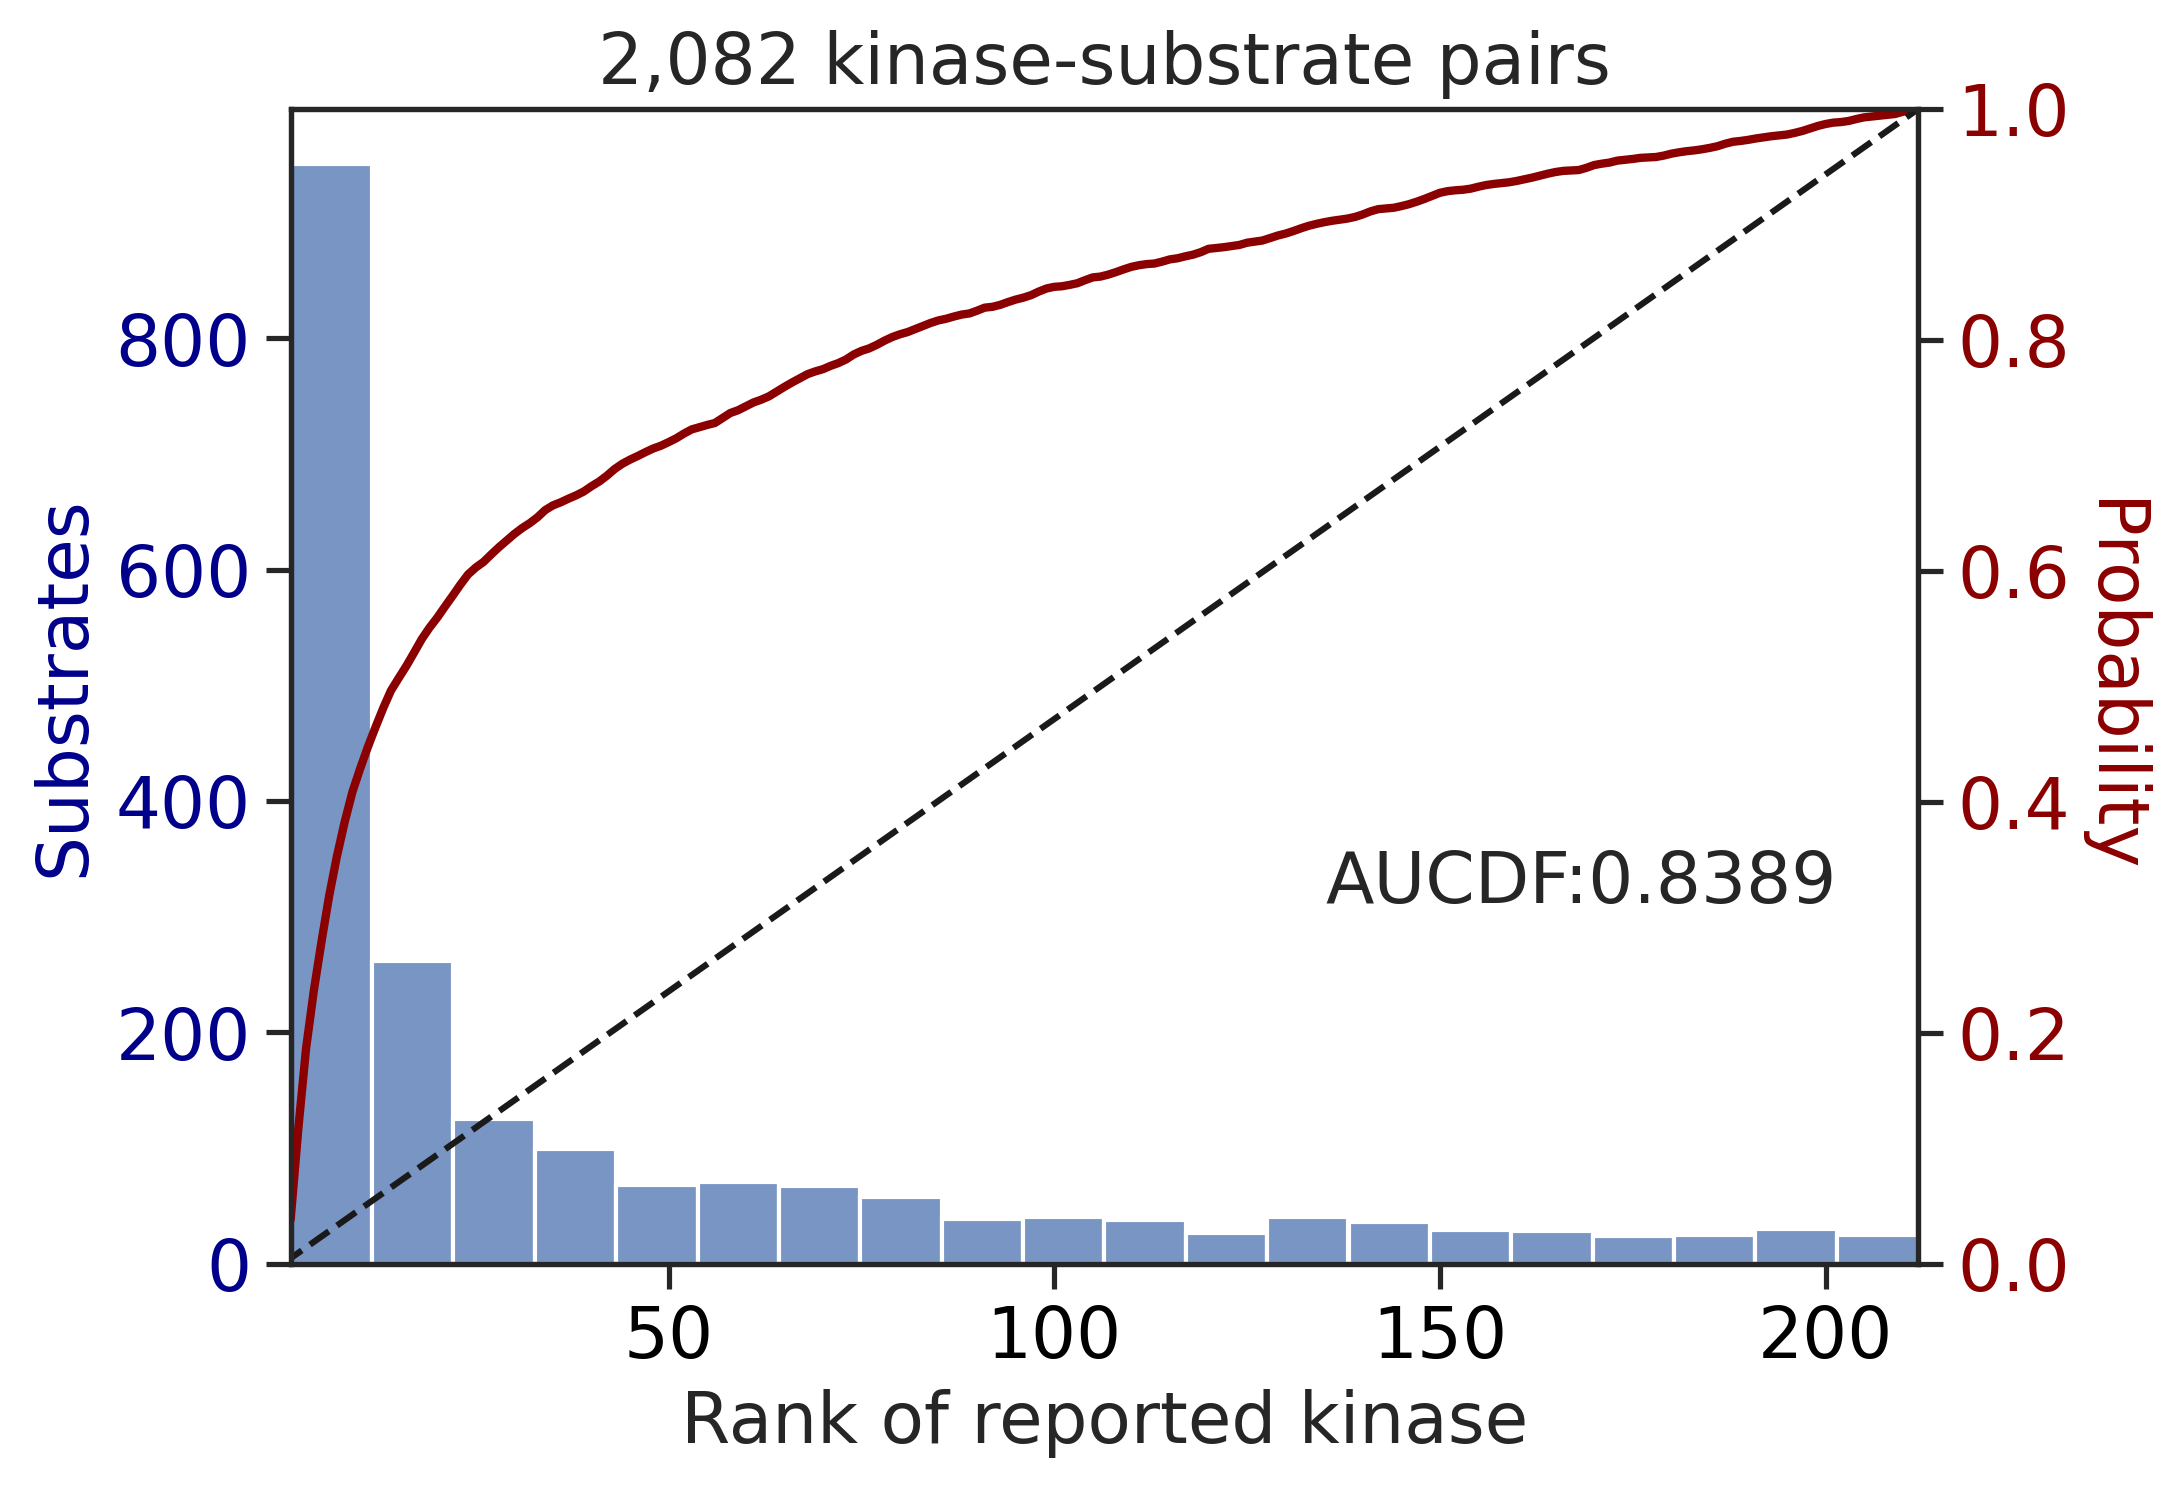

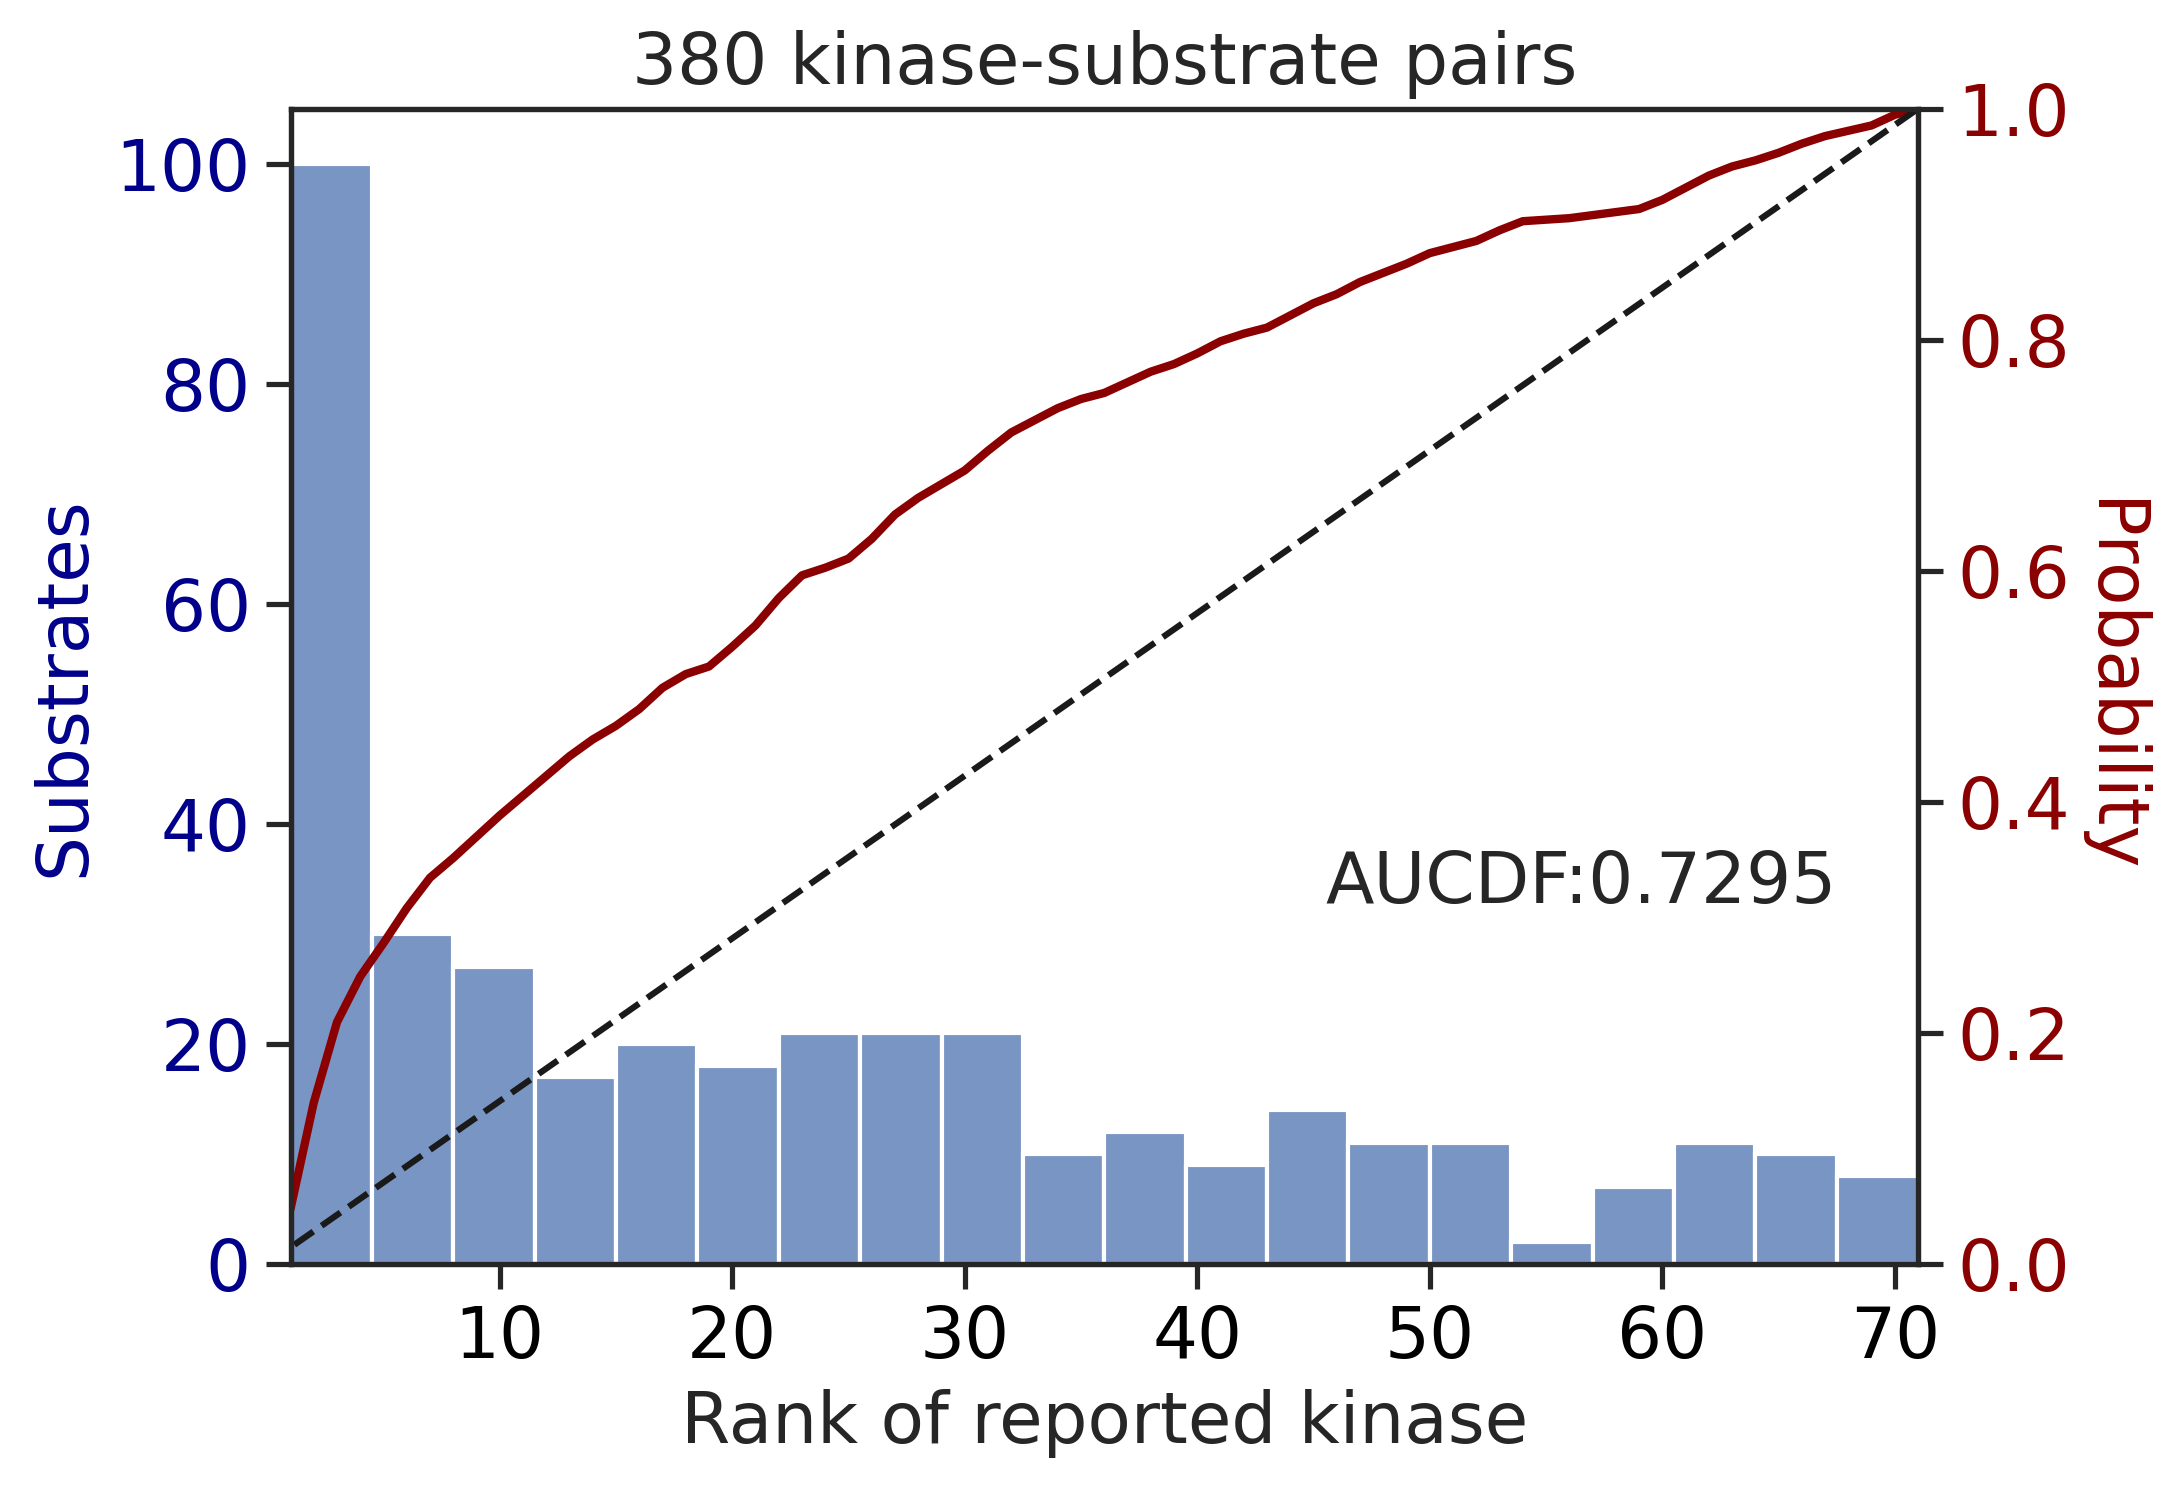

In [122]:
topk,aucdf_st,aucdf_tyr = get_results(df_st,df_tyr,df_st_result,df_tyr_result)

In [123]:
topk

top10_accuracy
CMGC            0.637191
Atypical        0.452055
AGC             0.422397
TK              0.394737
CAMK            0.266289
STE             0.160494
CK1             0.158730
Other           0.153846
NEK             0.125000
TKL             0.097561

percentile later

## Overall

pspa

In [18]:
pspa = pd.read_parquet('raw/overlap_pspa.parquet')
pspa.index = pspa.index.str.split('_').str[1]
pspa.shape

(312, 236)

Data to be scored

In [19]:
df =pd.read_parquet('out/CDDM_test_set.parquet')

In [20]:
df['site_seq_upper'] = df.site_seq.str.upper()

In [21]:
# only filter those with tested kinase
df = df[df.kinase_protein.isin(pspa.index)].copy()

In [22]:
df.shape

(2484, 24)

In [23]:
group_map = df[['kinase_protein','kinase_group']].drop_duplicates().set_index('kinase_protein')['kinase_group']
TK = group_map[group_map=='TK'].index
ST = group_map[group_map!='TK'].index

In [24]:
def prepare_ref(path):
    ref = pd.read_parquet(path)
    ref.index = ref.index.str.split('_').str[1]
    ref = ref[ref.index.isin(pspa.index)]
    print(ref.shape)
    return ref

cddm:

In [25]:
cddm = prepare_ref('out/CDDM_pssms_eval_psp_02.parquet')
cddm_upper = prepare_ref('out/CDDM_pssms_eval_upper_psp_02.parquet')

cddm_lo = prepare_ref('out/CDDM_pssms_LO_eval_psp_02.parquet')
cddm_lo_upper = prepare_ref('out/CDDM_pssms_LO_eval_upper_psp_02.parquet')

(312, 943)
(312, 943)
(312, 943)
(312, 943)


In [26]:
# ref_dict = {
#     'PSPA: PSSM + multiply': (pspa,'site_seq',multiply,False),
#     'CDDM: PSSM + multiply': (cddm, 'site_seq', multiply_23,False),
#     'CDDM: PSSM upper + multiply': (cddm_upper, 'site_seq_upper', multiply_20,False),
#     'CDDM: LO + sum': (cddm_lo, 'site_seq',sumup,False),
#     'CDDM: LO upper + sum': (cddm_lo_upper, 'site_seq_upper',sumup,False),
# }

# for name,(ref,seq_col,func,_) in ref_dict.items():
#     print(name)
#     pct_ref = get_ref(human,pssm=ref,seq_col=seq_col,func=func)
#     pct_ref.to_parquet(f'raw/{name}.parquet')
#     print(pct_ref.head())
#     # break

In [27]:
ref_dict = {
    'PSPA: PSSM + multiply': (pspa,'site_seq',multiply,False),
    'PSPA: PSSM + multiply + pct': (pspa,'site_seq',multiply, True),
    
    'CDDM: PSSM + multiply': (cddm, 'site_seq', multiply_23,False),
    'CDDM: PSSM + multiply + pct': (cddm, 'site_seq', multiply_23, True),
    
    'CDDM: PSSM upper + multiply': (cddm_upper, 'site_seq_upper', multiply_20,False),
    'CDDM: PSSM upper + multiply + pct': (cddm_upper, 'site_seq_upper', multiply_20,True),
    
    'CDDM: LO + sum': (cddm_lo, 'site_seq',sumup,False),
    'CDDM: LO + sum + pct': (cddm_lo, 'site_seq',sumup,True),
    
    'CDDM: LO upper + sum': (cddm_lo_upper, 'site_seq_upper',sumup,False),
    'CDDM: LO upper + sum + pct': (cddm_lo_upper, 'site_seq_upper',sumup,True),
}

In [28]:
set_sns()

---------------------------------------------
PSPA: PSSM + multiply
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 280.99it/s]


input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 556.84it/s]


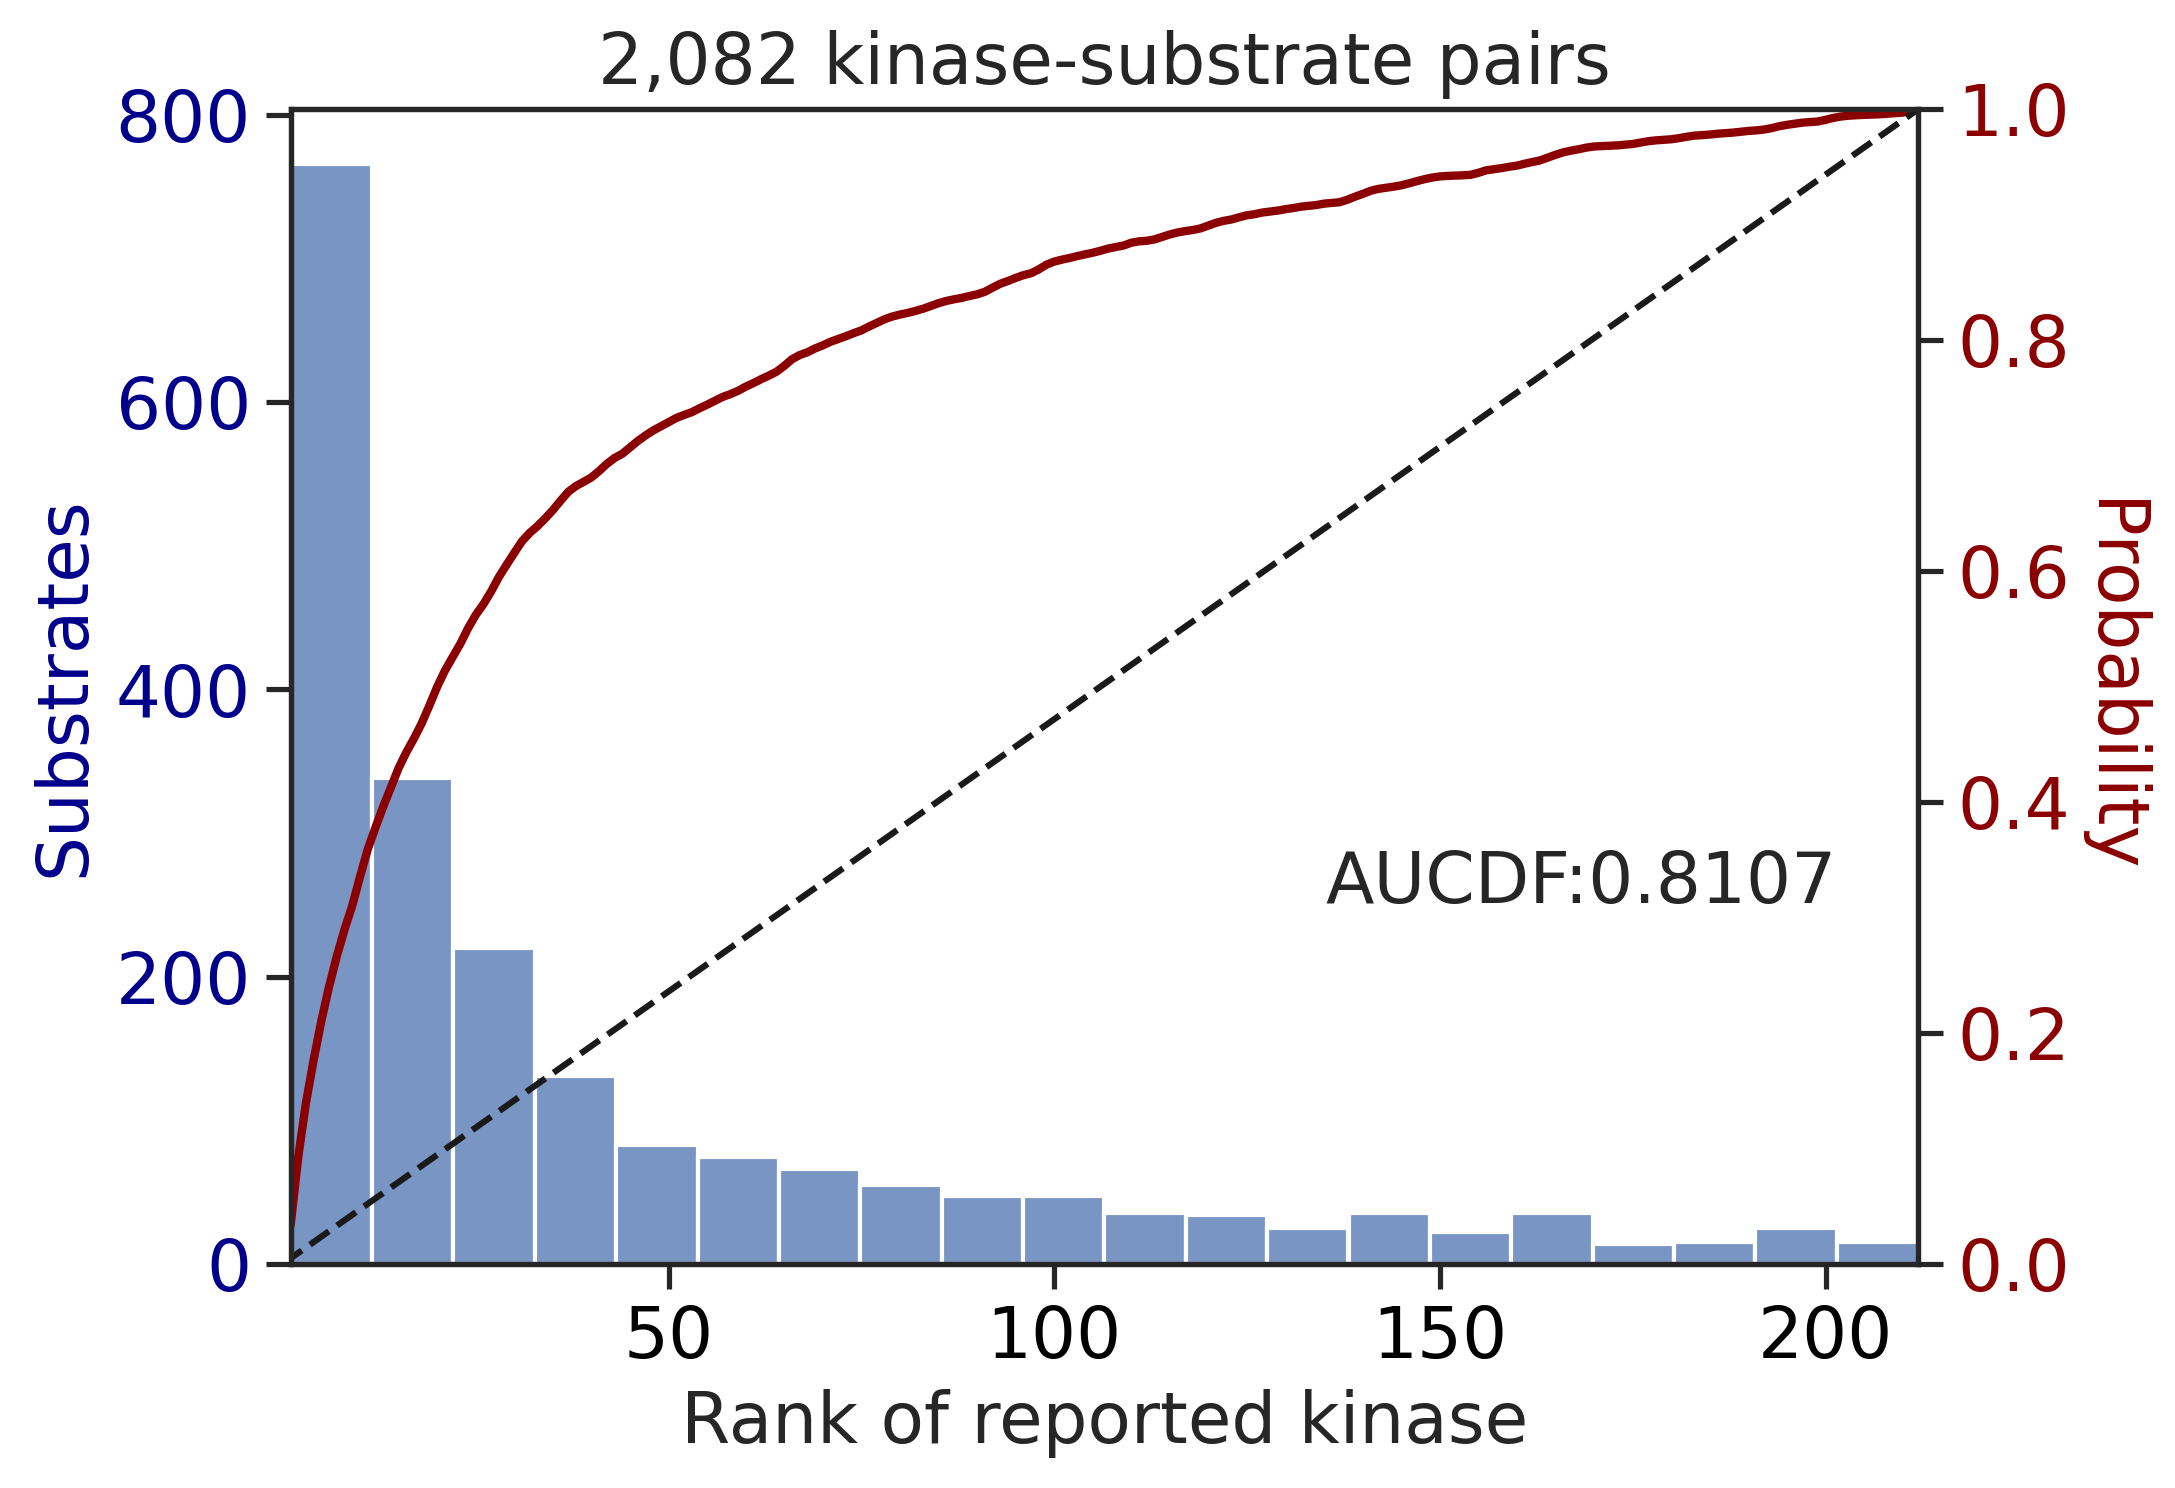

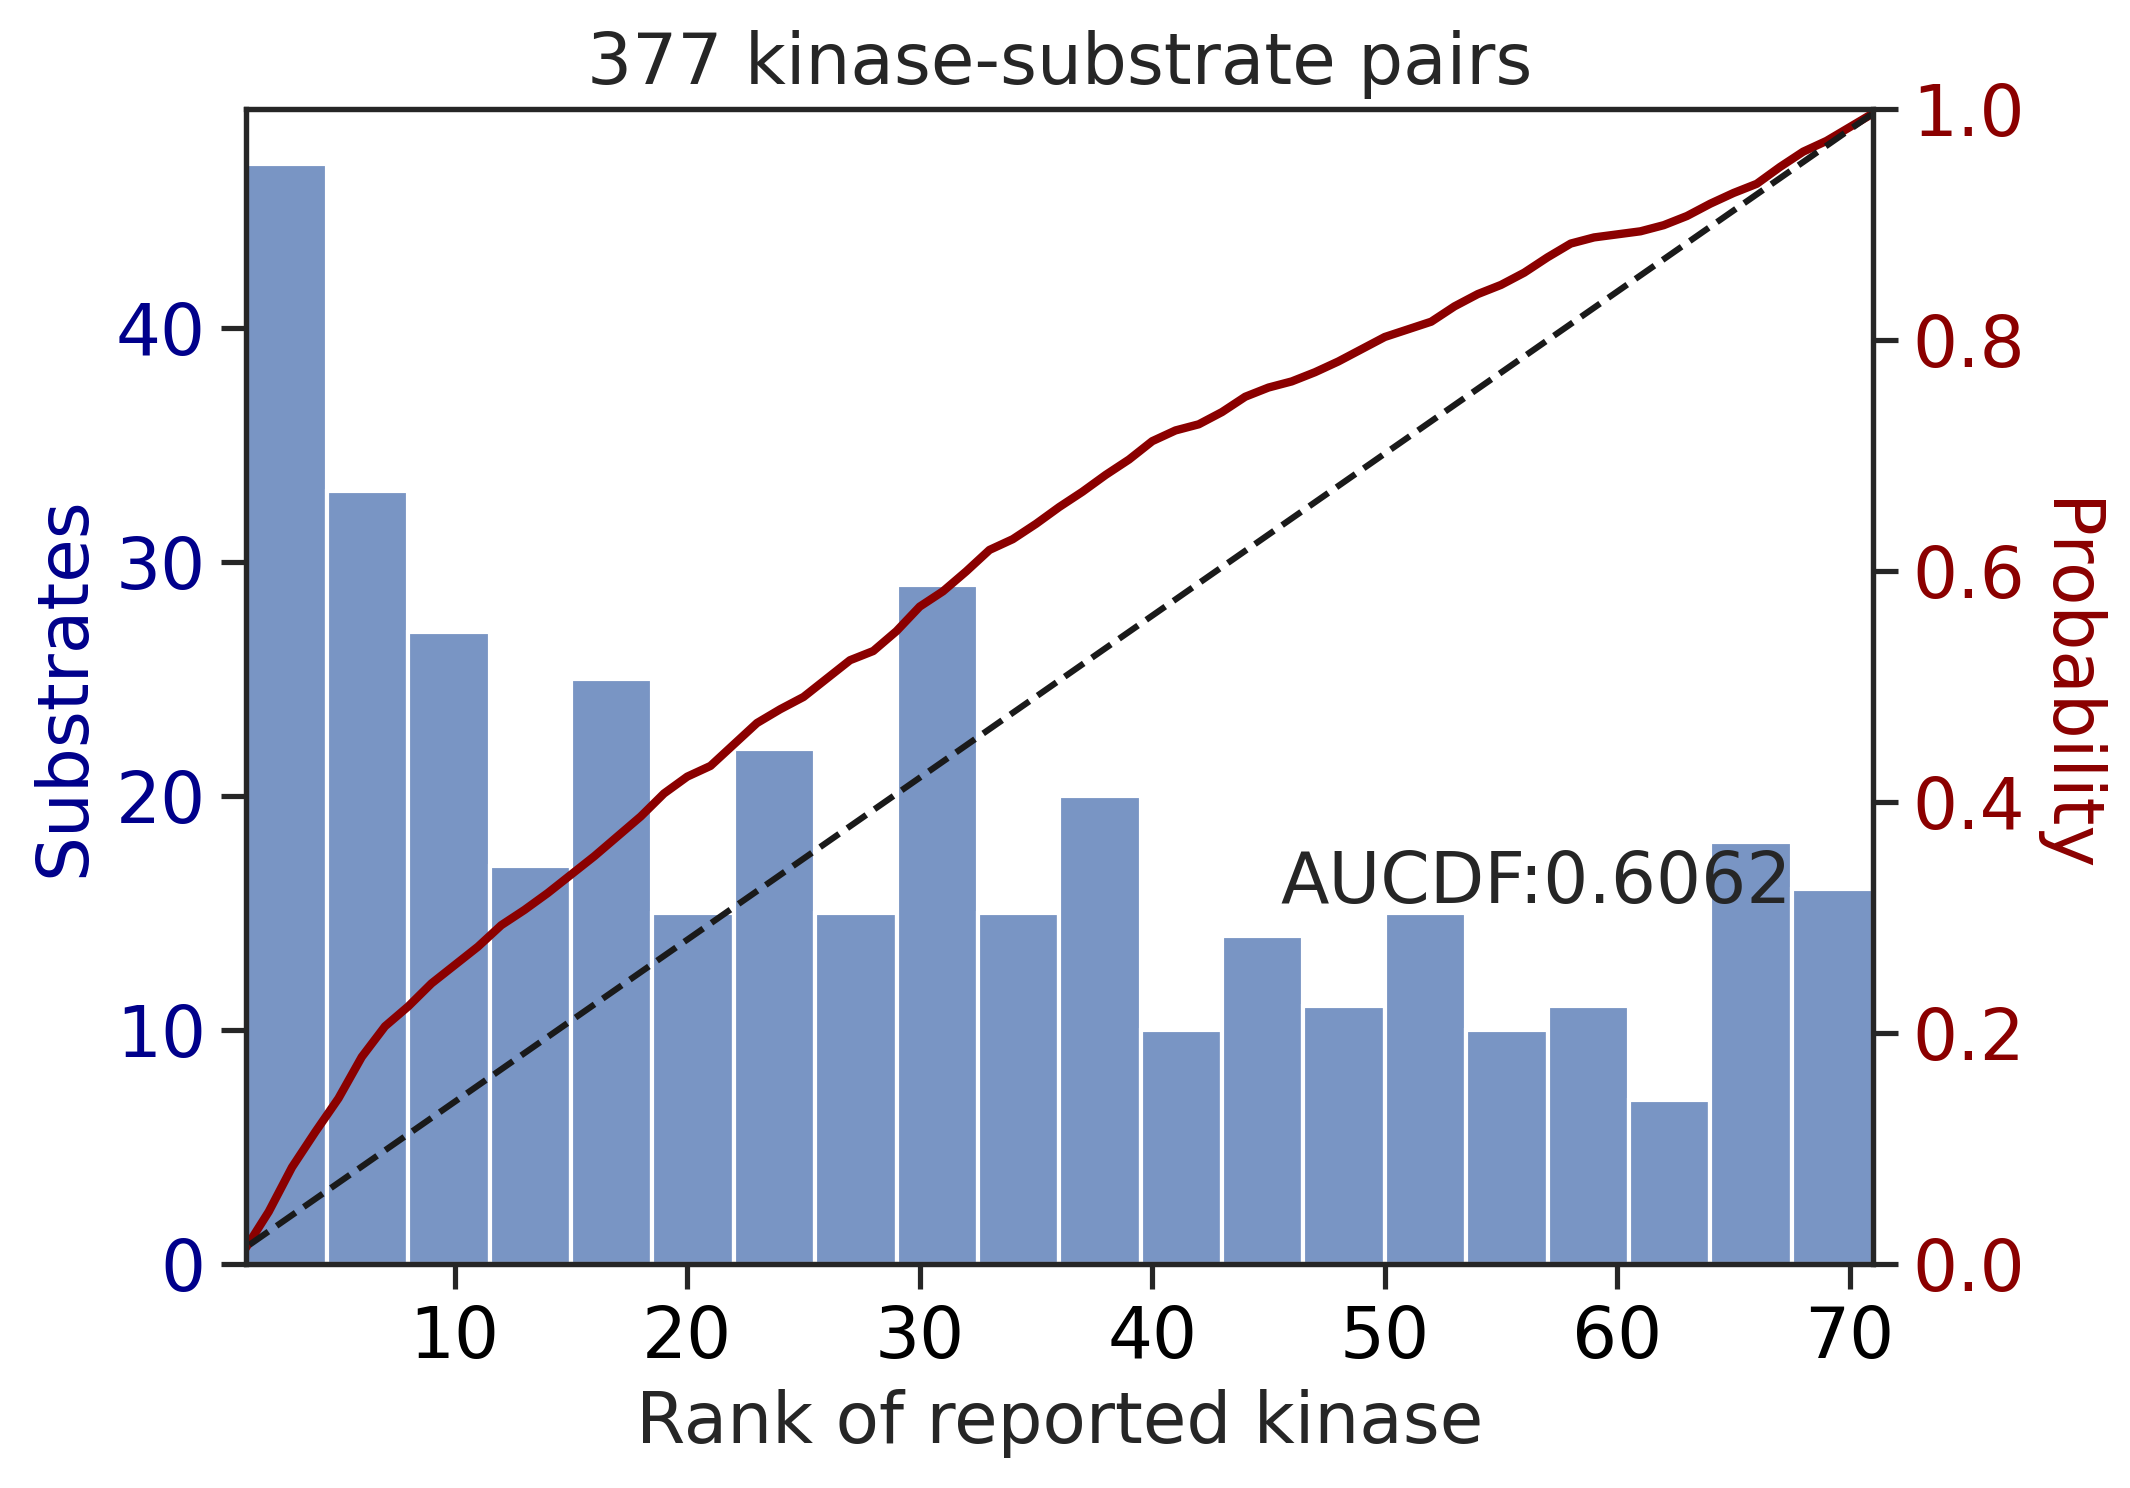

---------------------------------------------
PSPA: PSSM + multiply + pct
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 289.36it/s]


input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 808.54it/s]


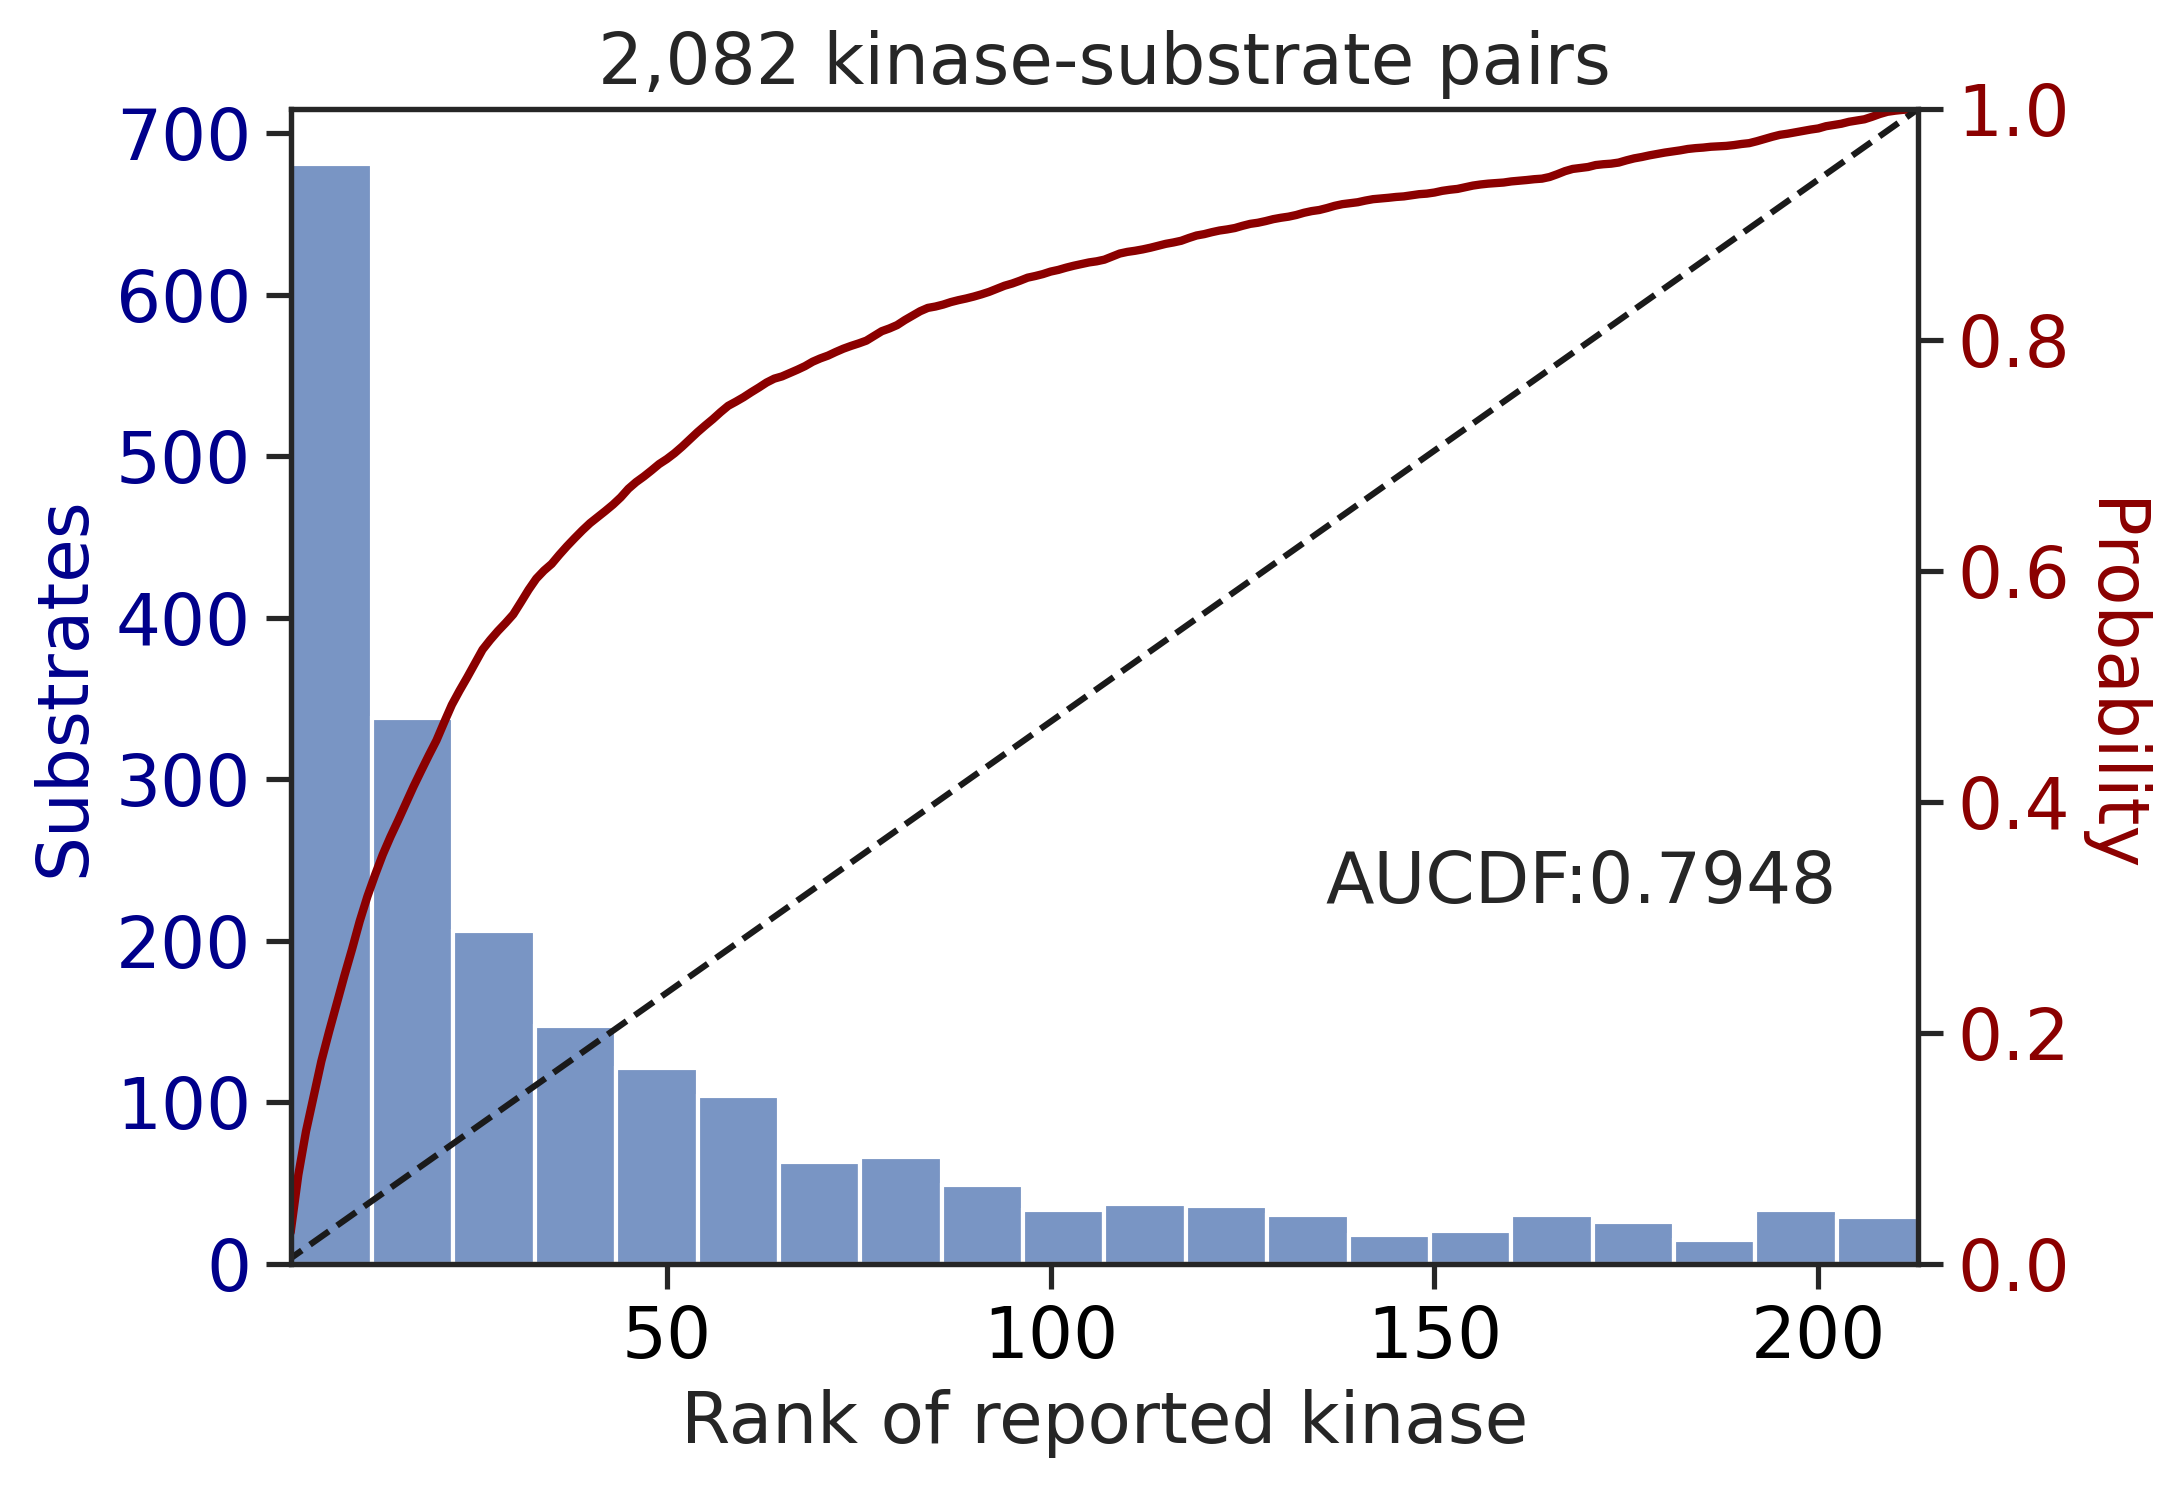

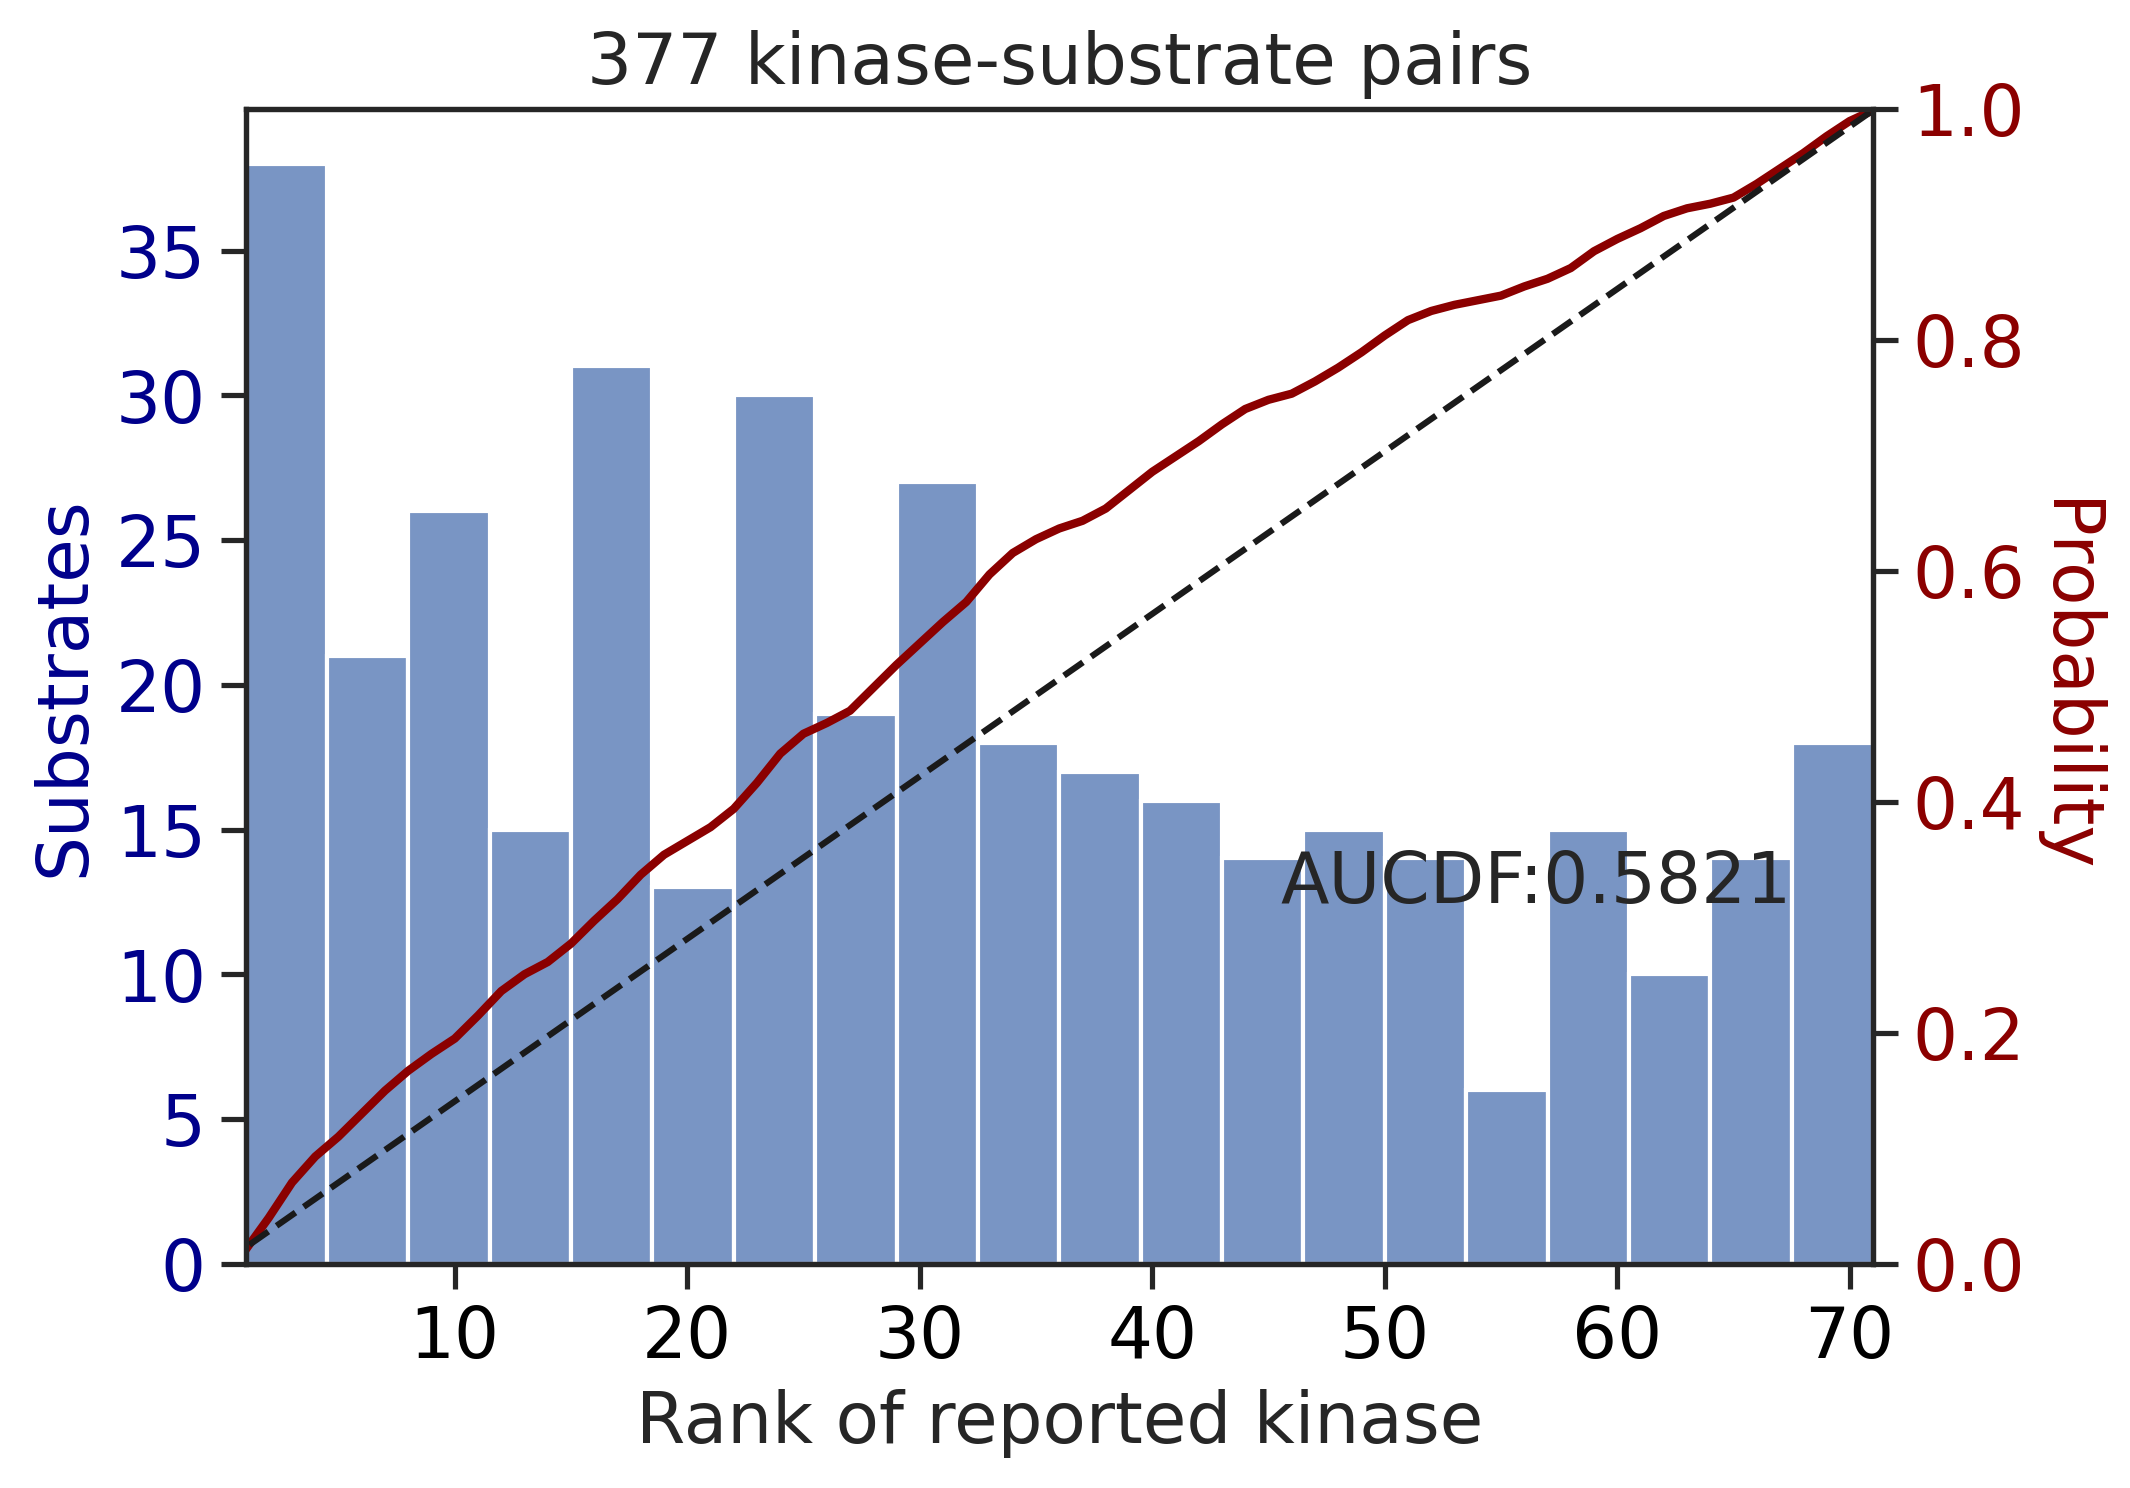

---------------------------------------------
CDDM: PSSM + multiply
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:01<00:00, 209.09it/s]


input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 475.58it/s]


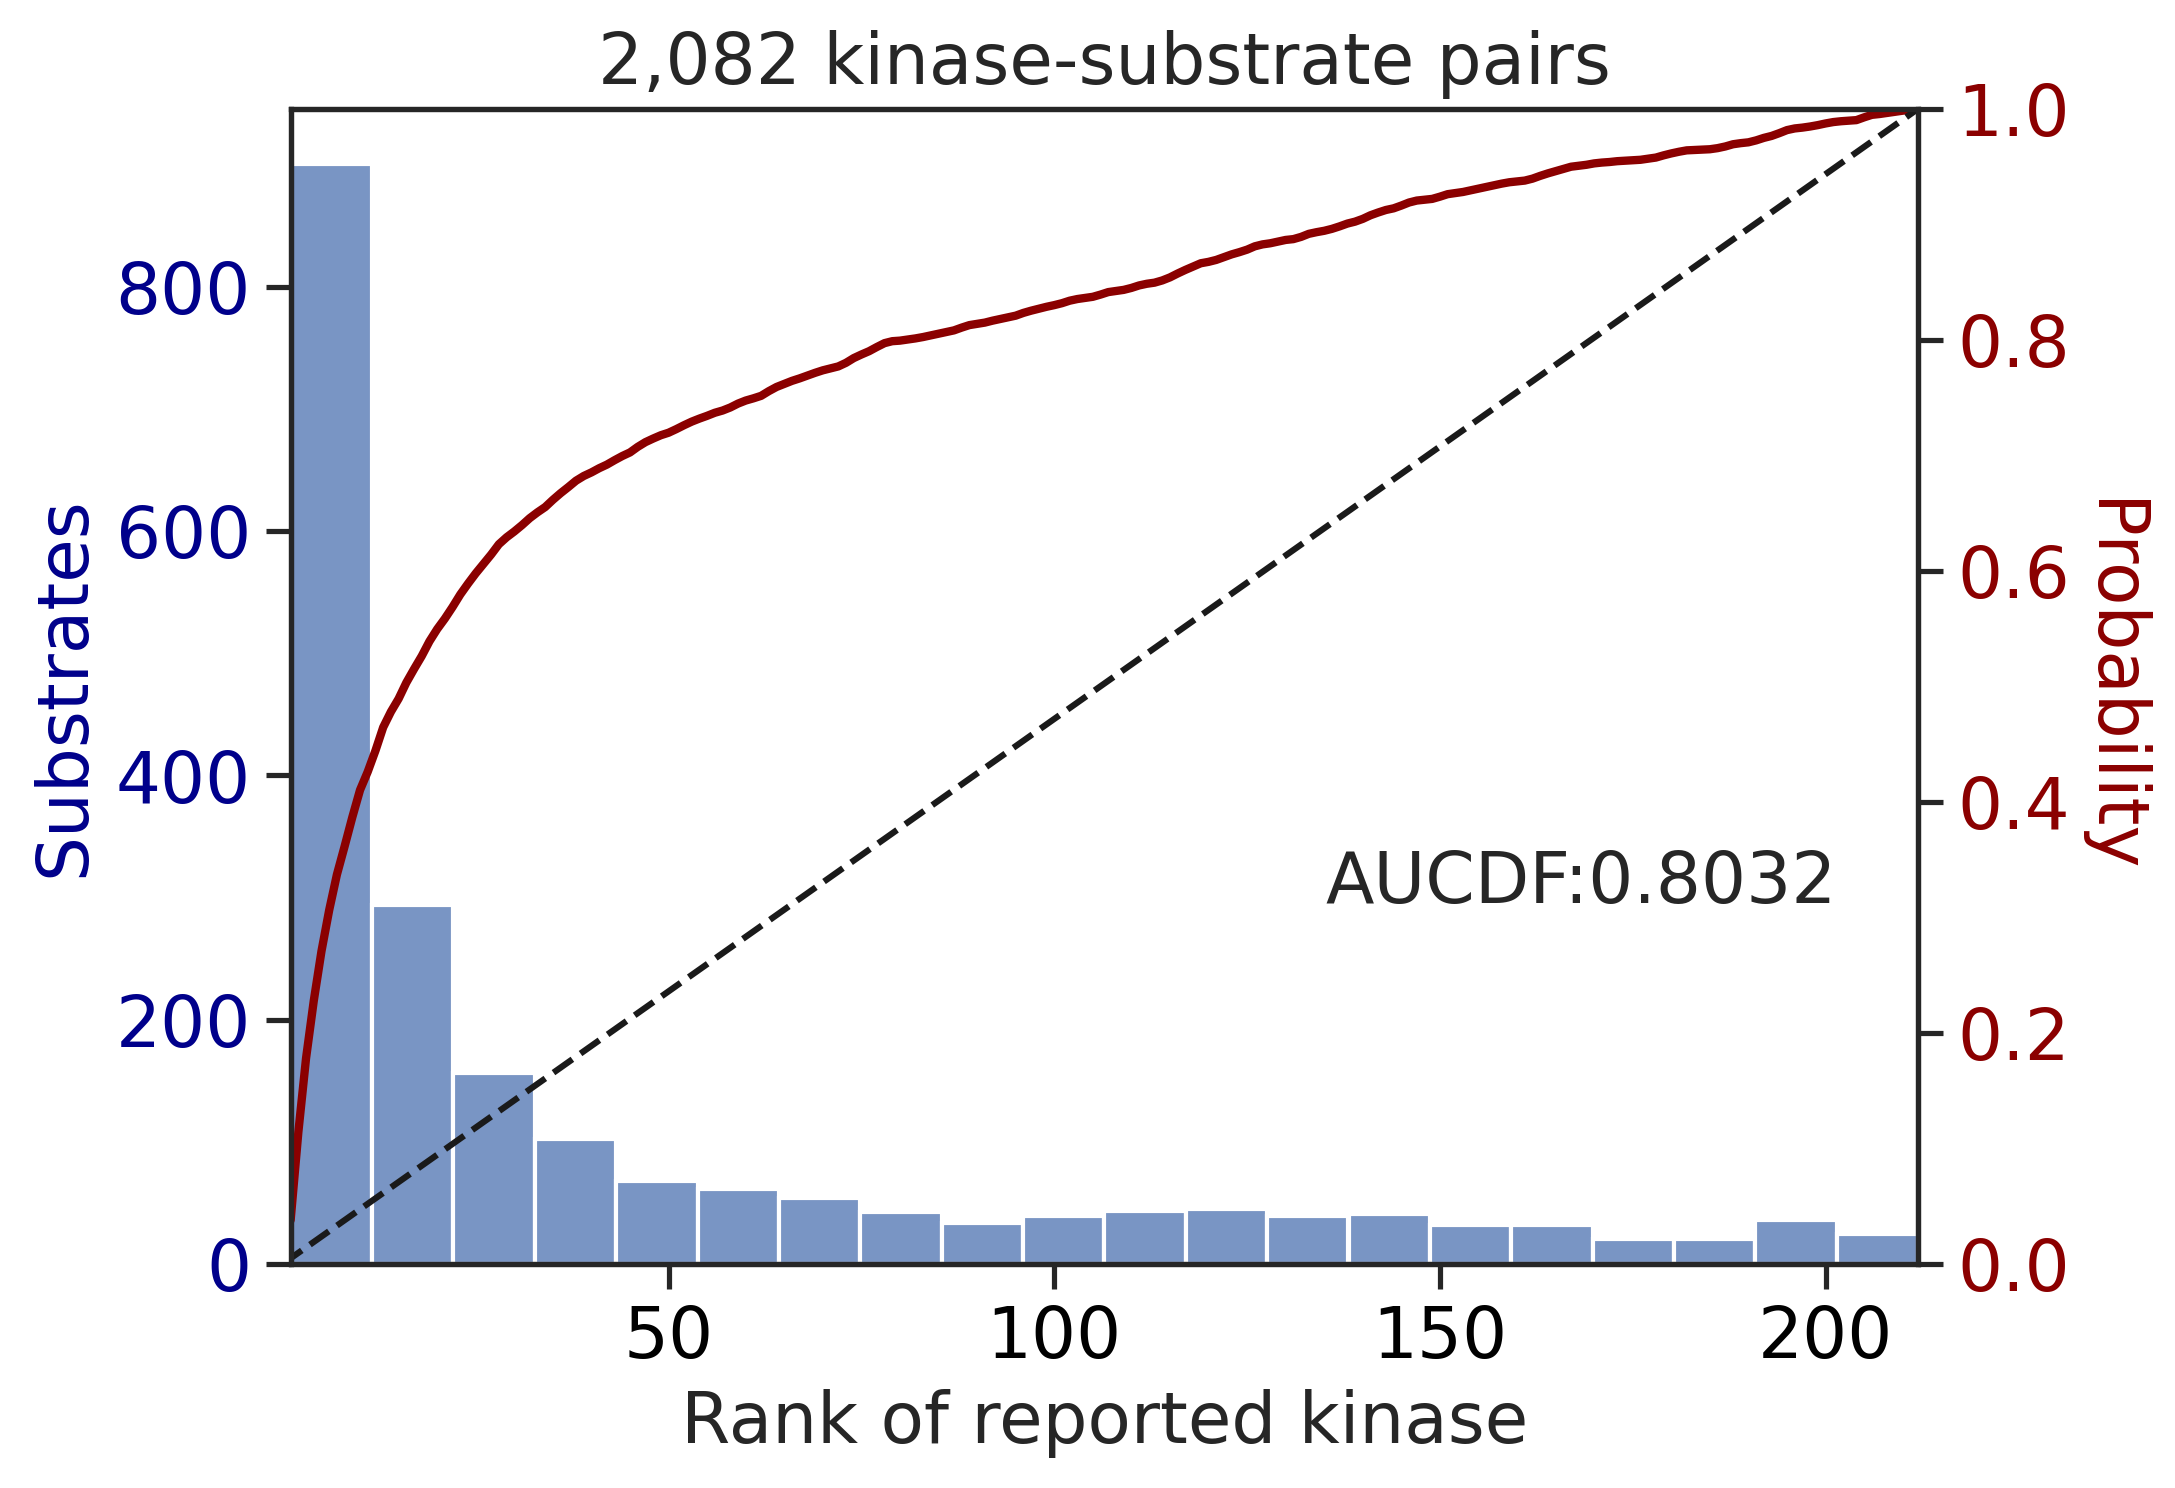

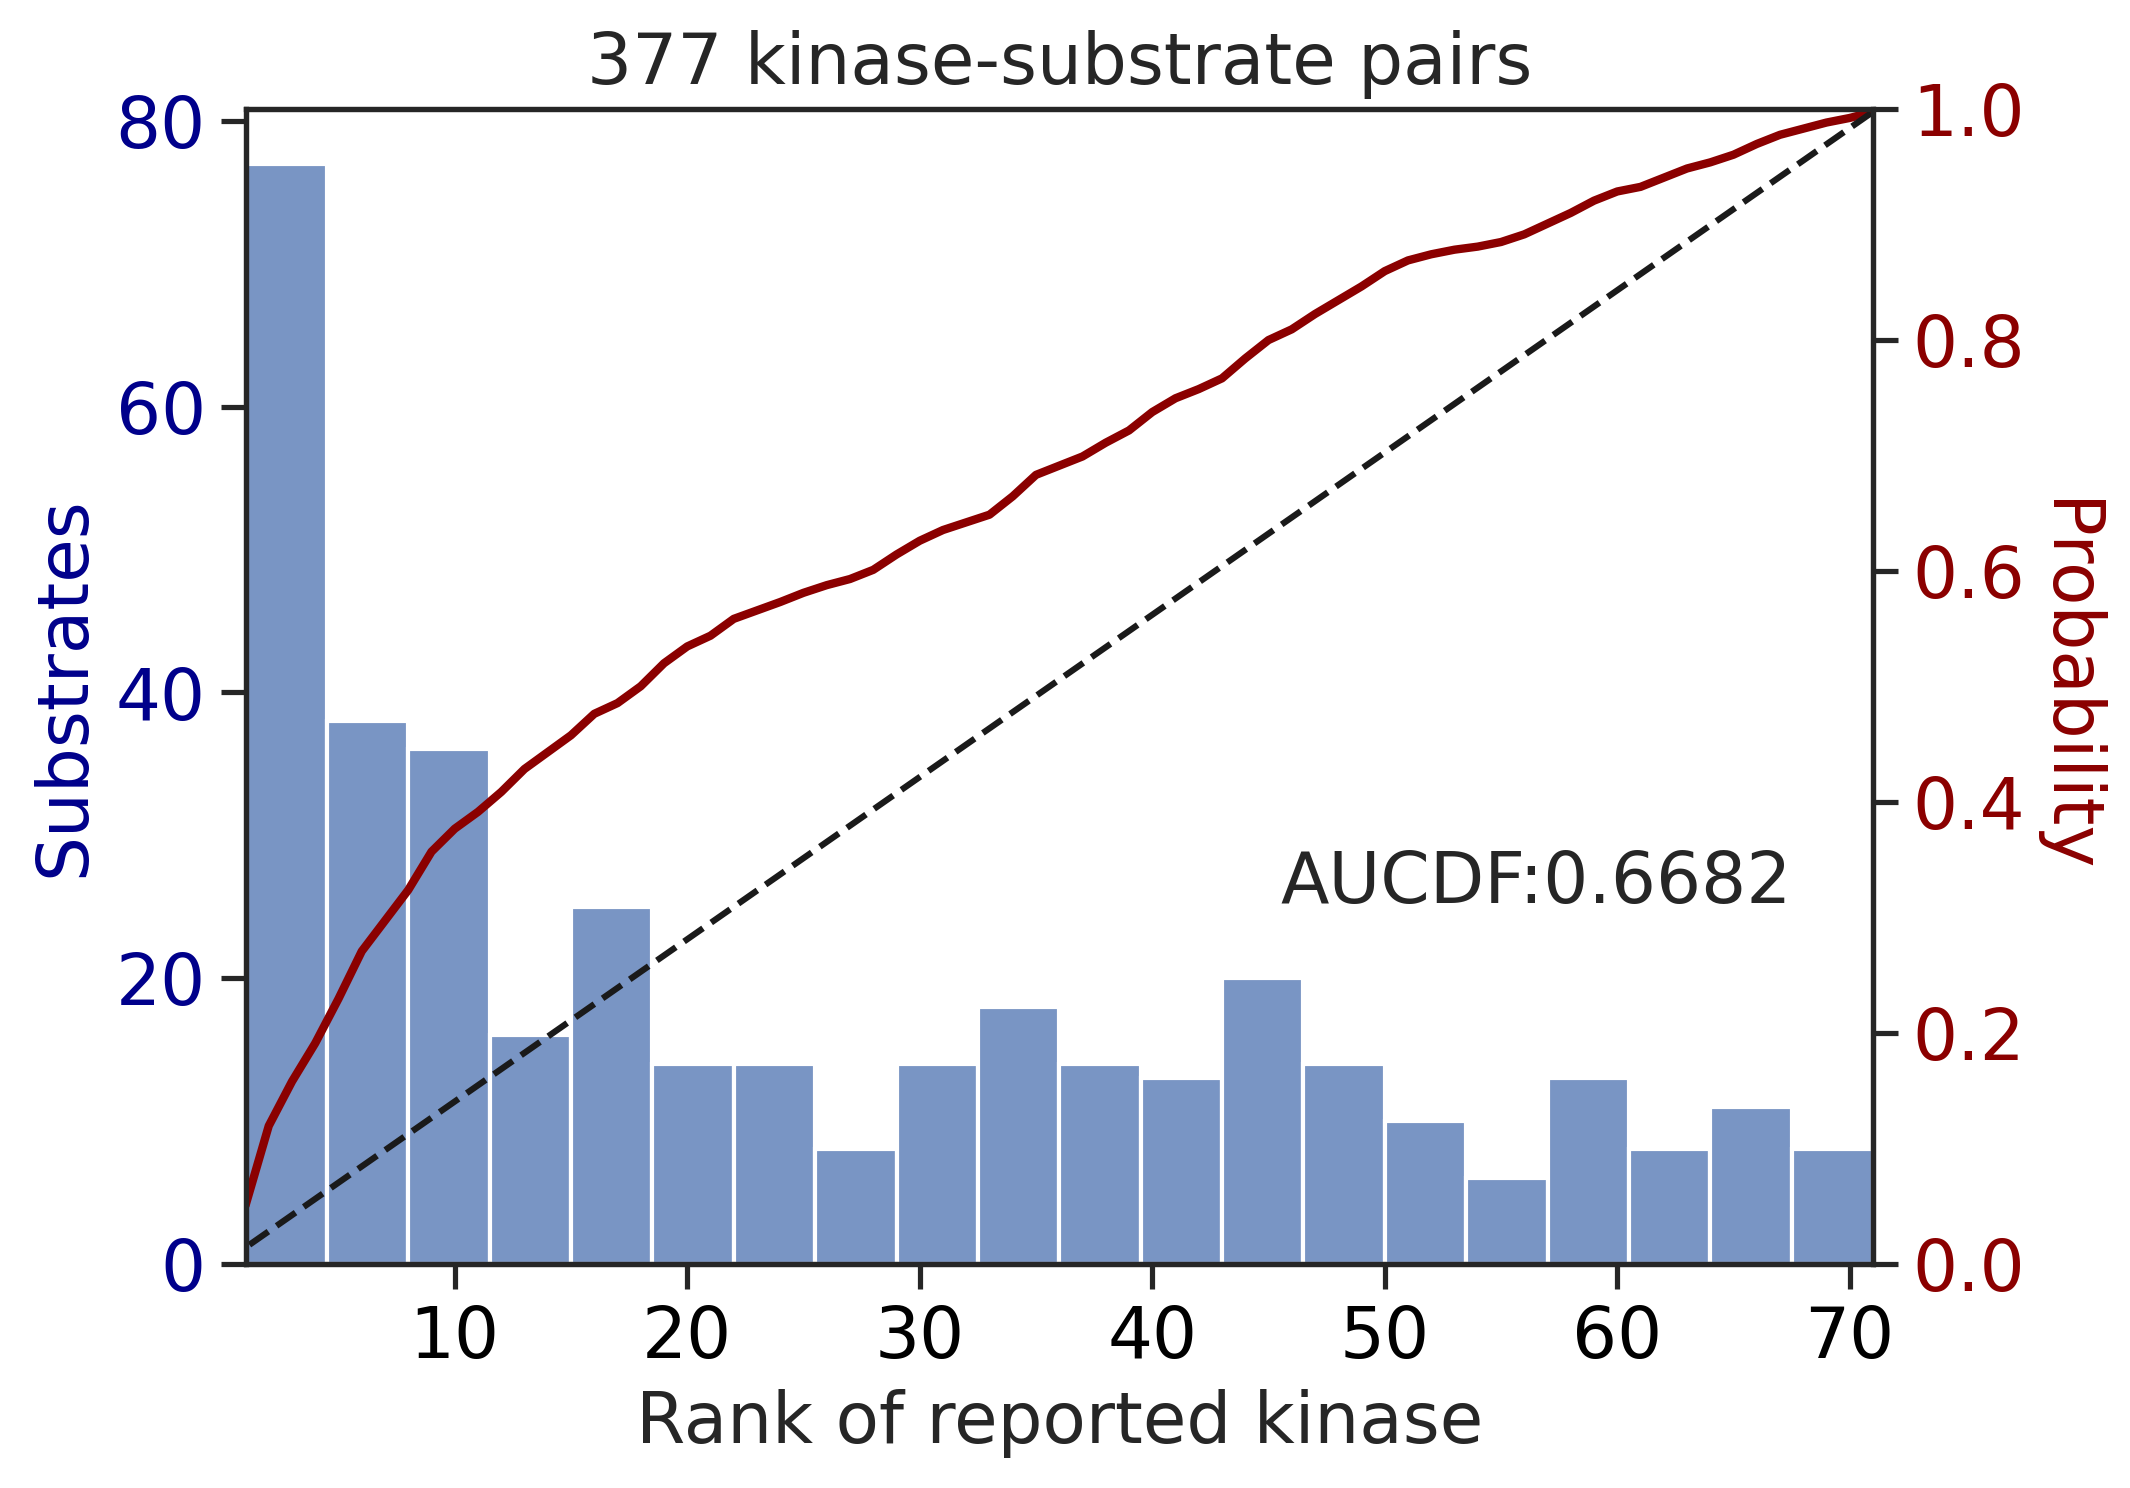

---------------------------------------------
CDDM: PSSM + multiply + pct
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 214.83it/s]


input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 816.89it/s]


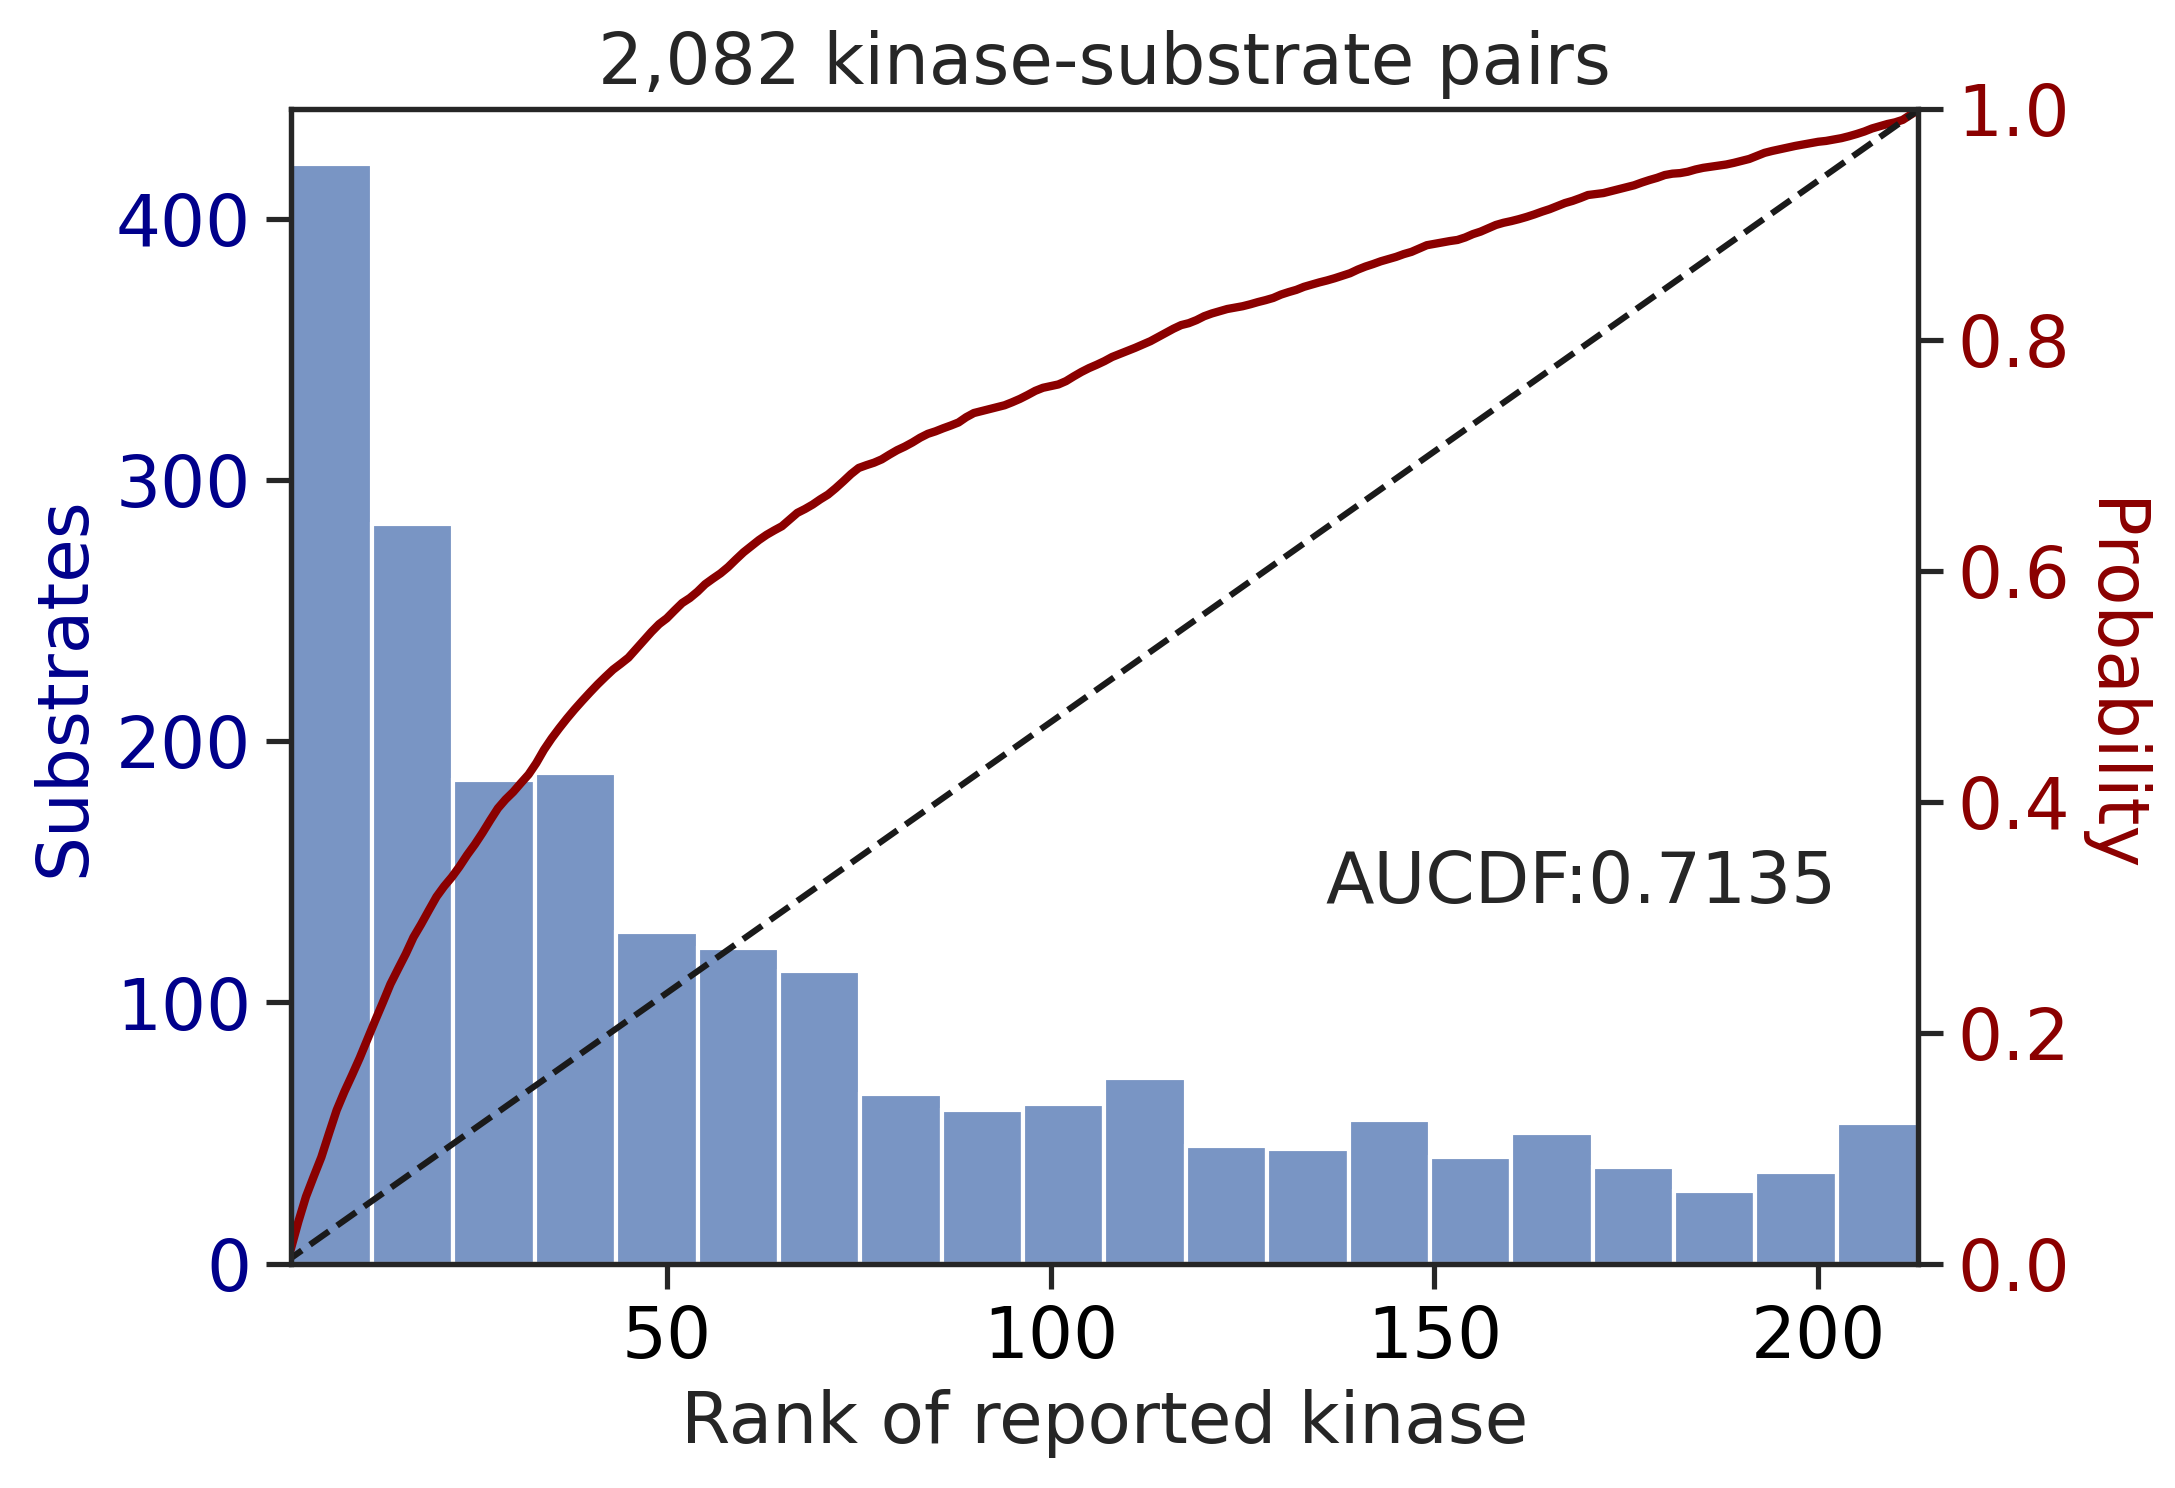

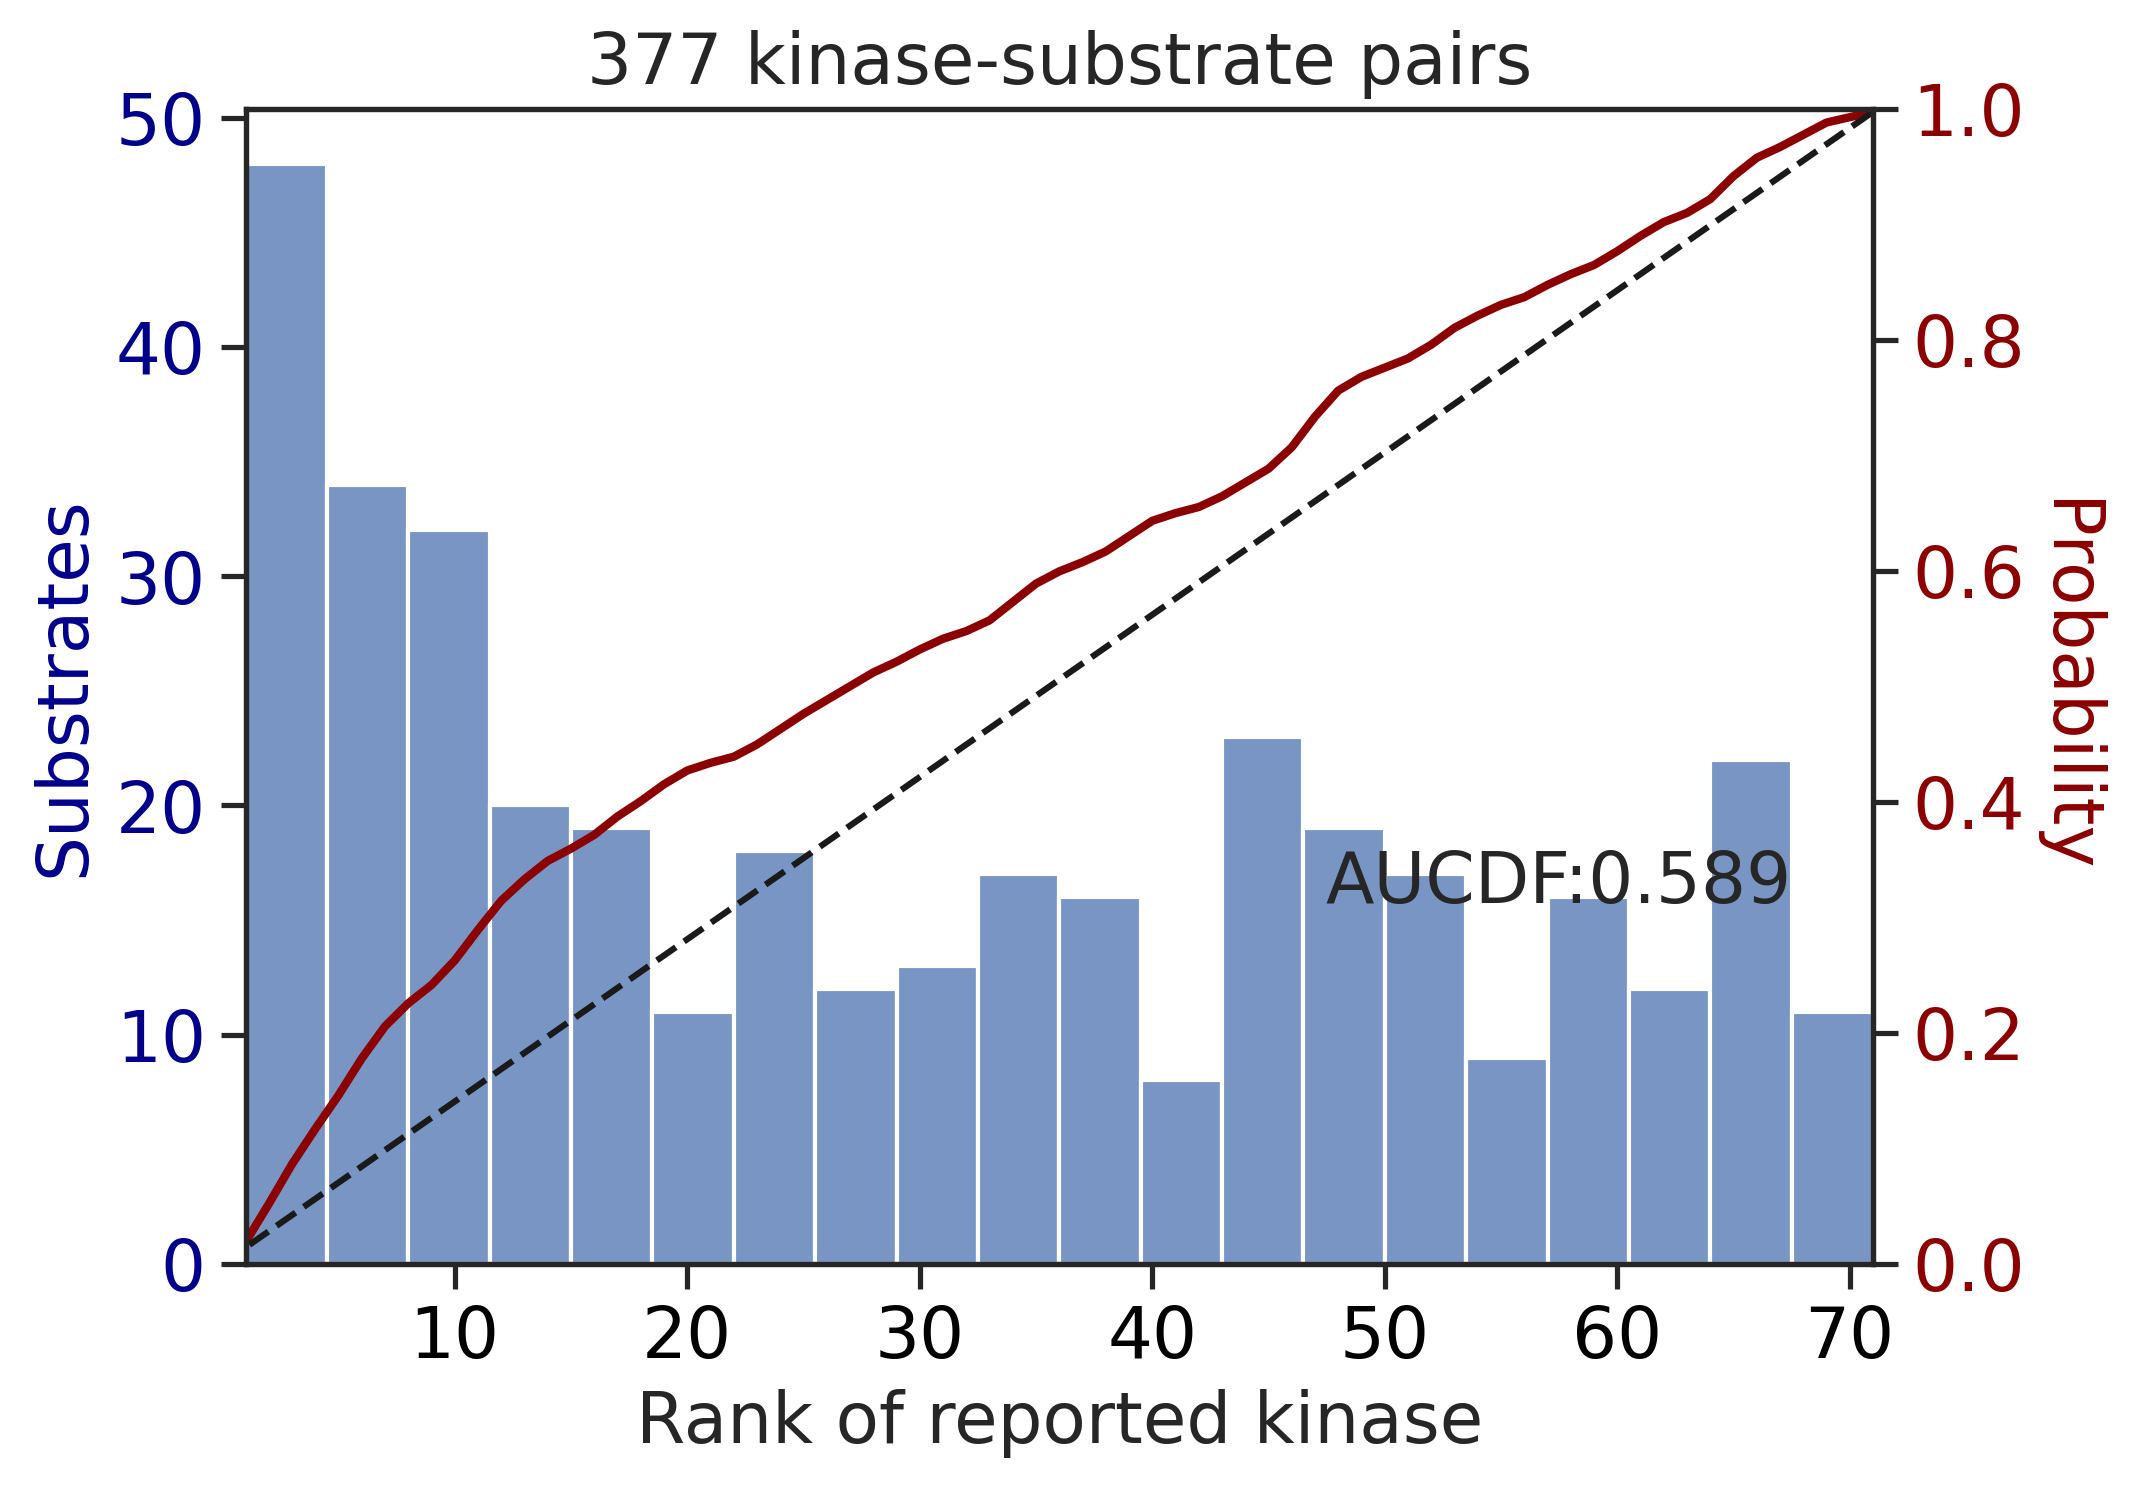

---------------------------------------------
CDDM: PSSM upper + multiply
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:01<00:00, 201.05it/s]


input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 471.58it/s]


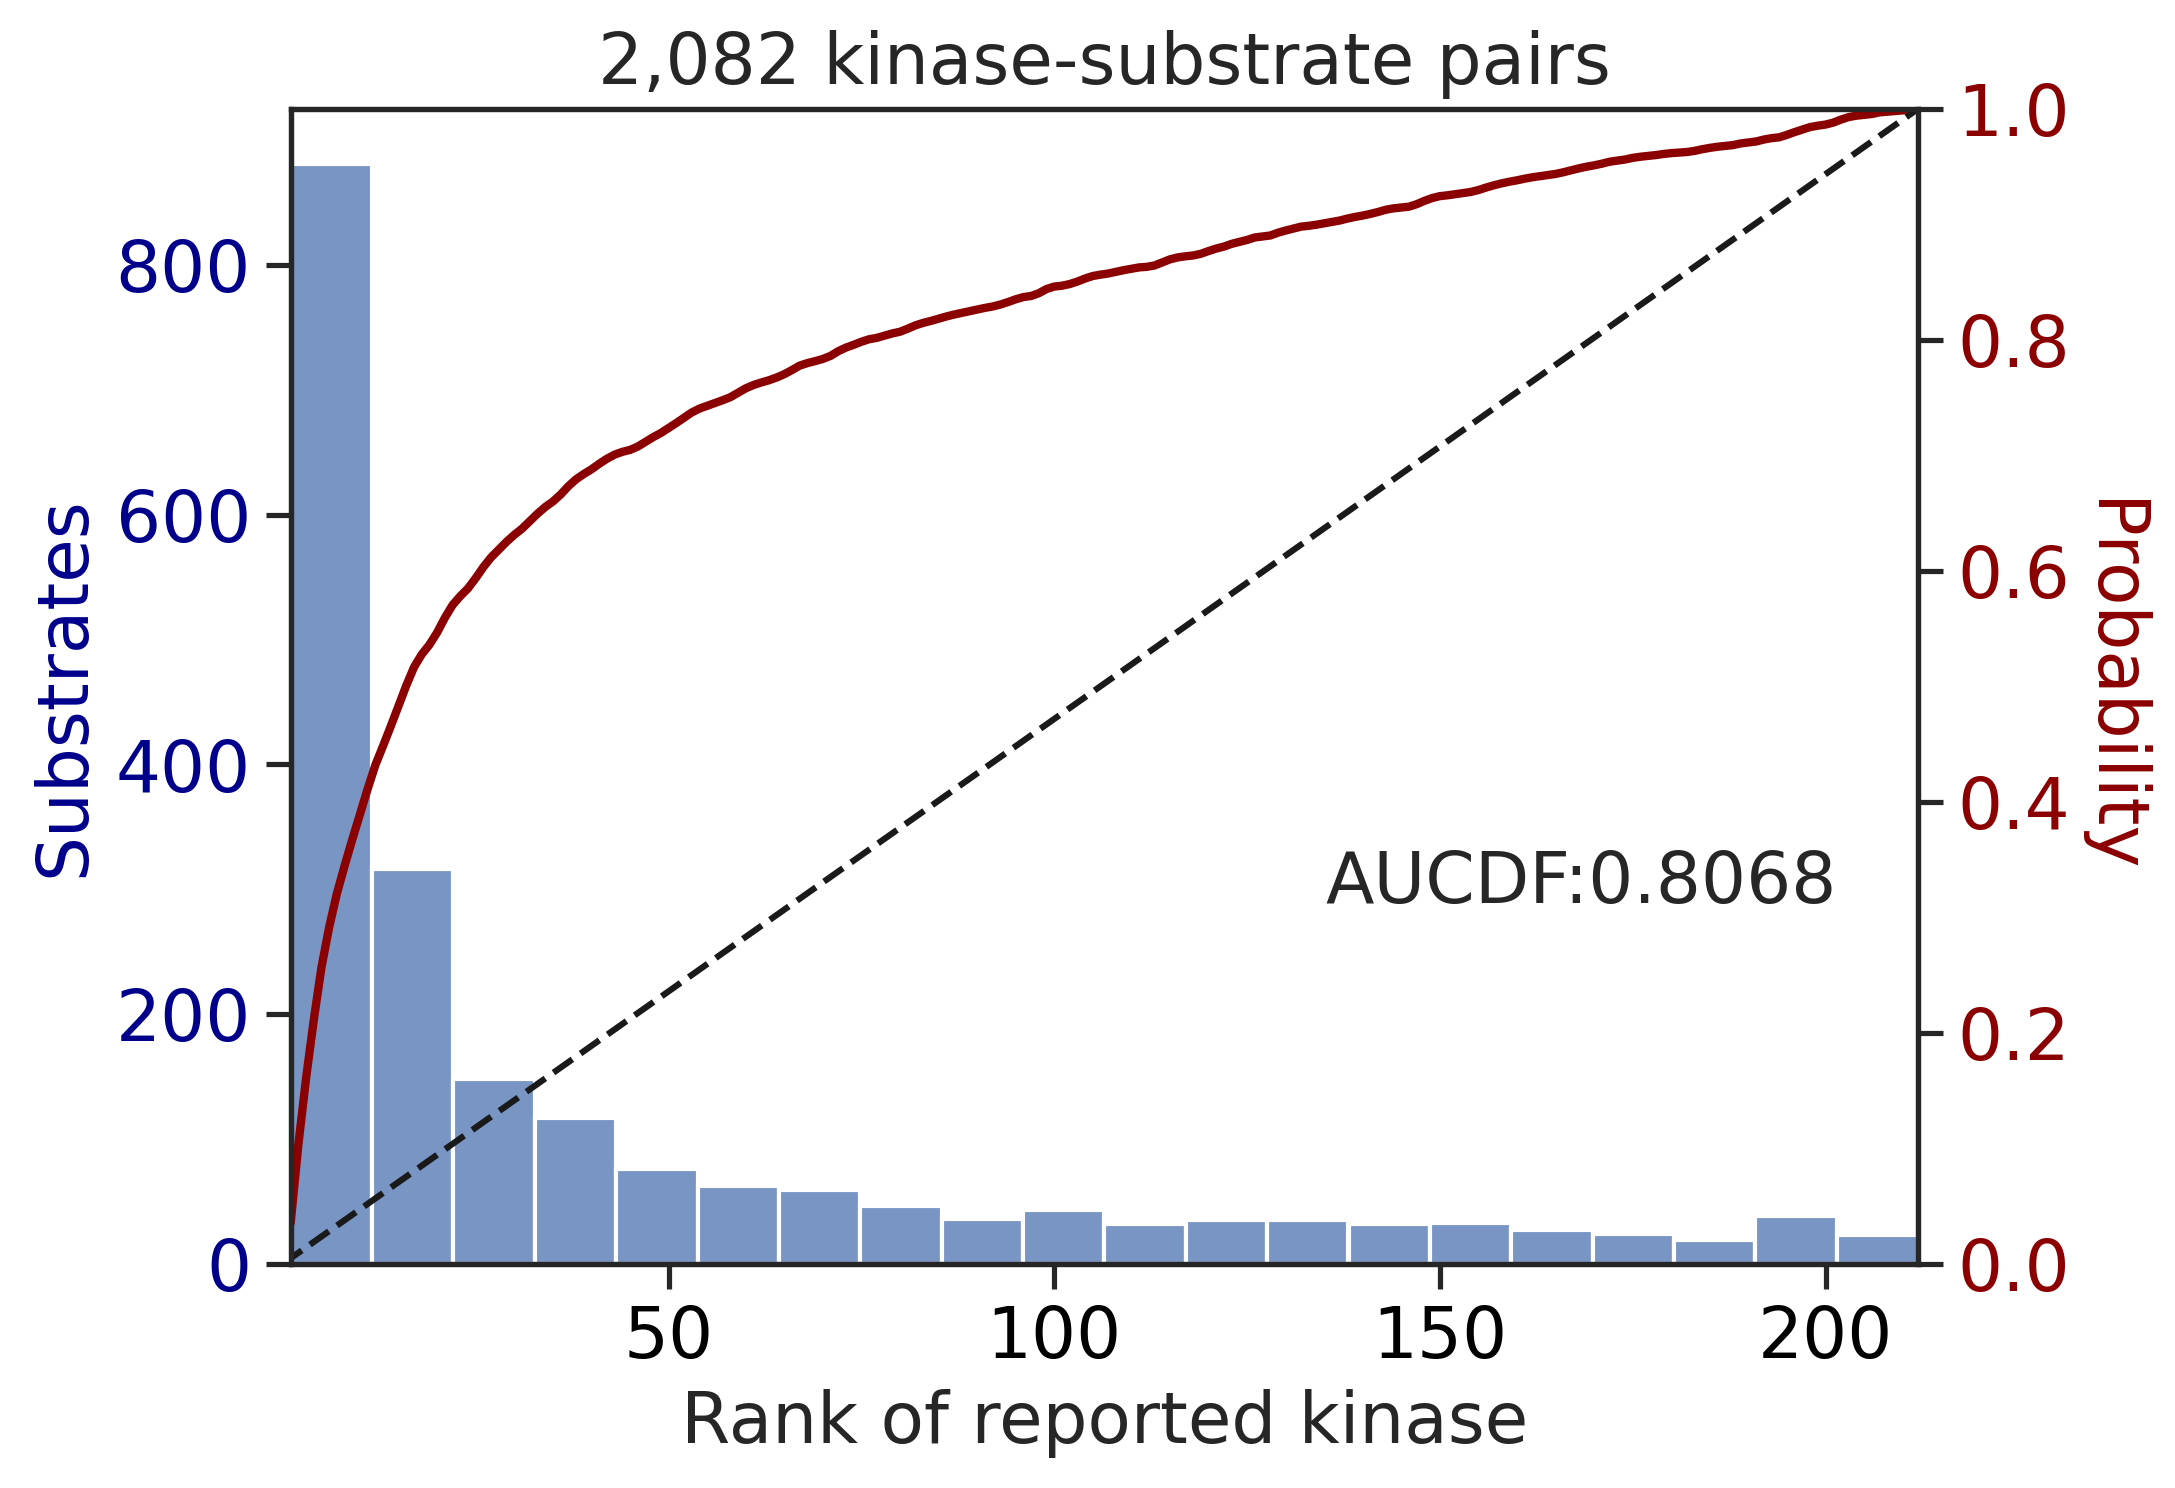

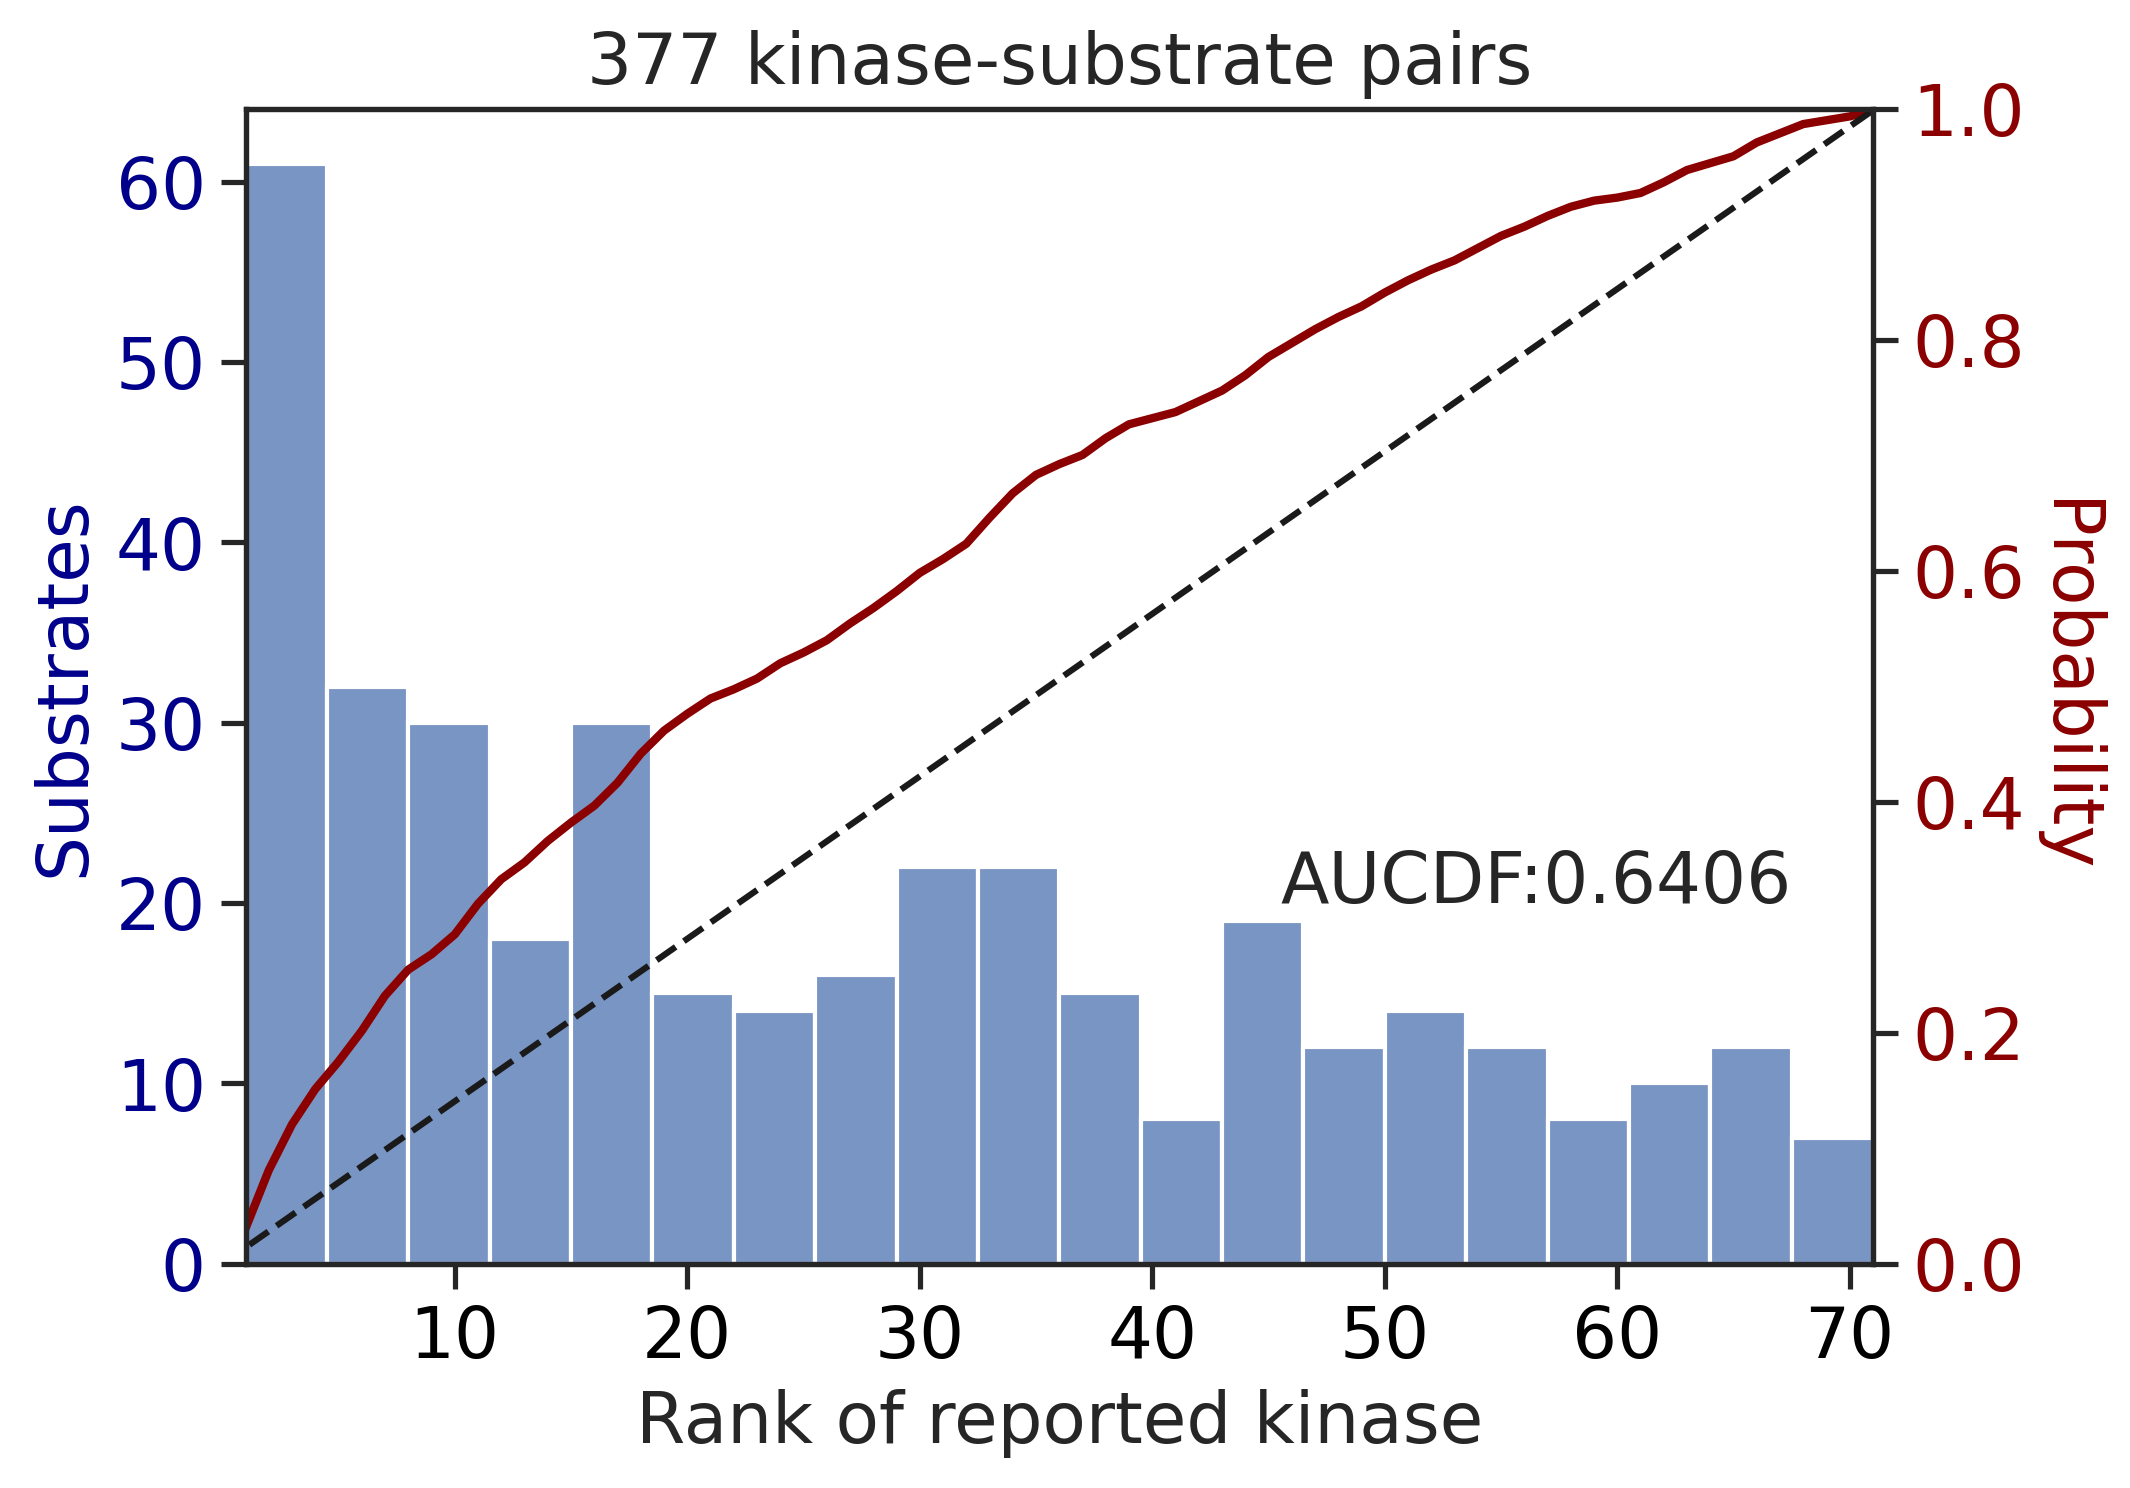

---------------------------------------------
CDDM: PSSM upper + multiply + pct
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████████████████████████████████████████████████████████████████████| 213/213 [00:01<00:00, 212.42it/s]


input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 839.41it/s]


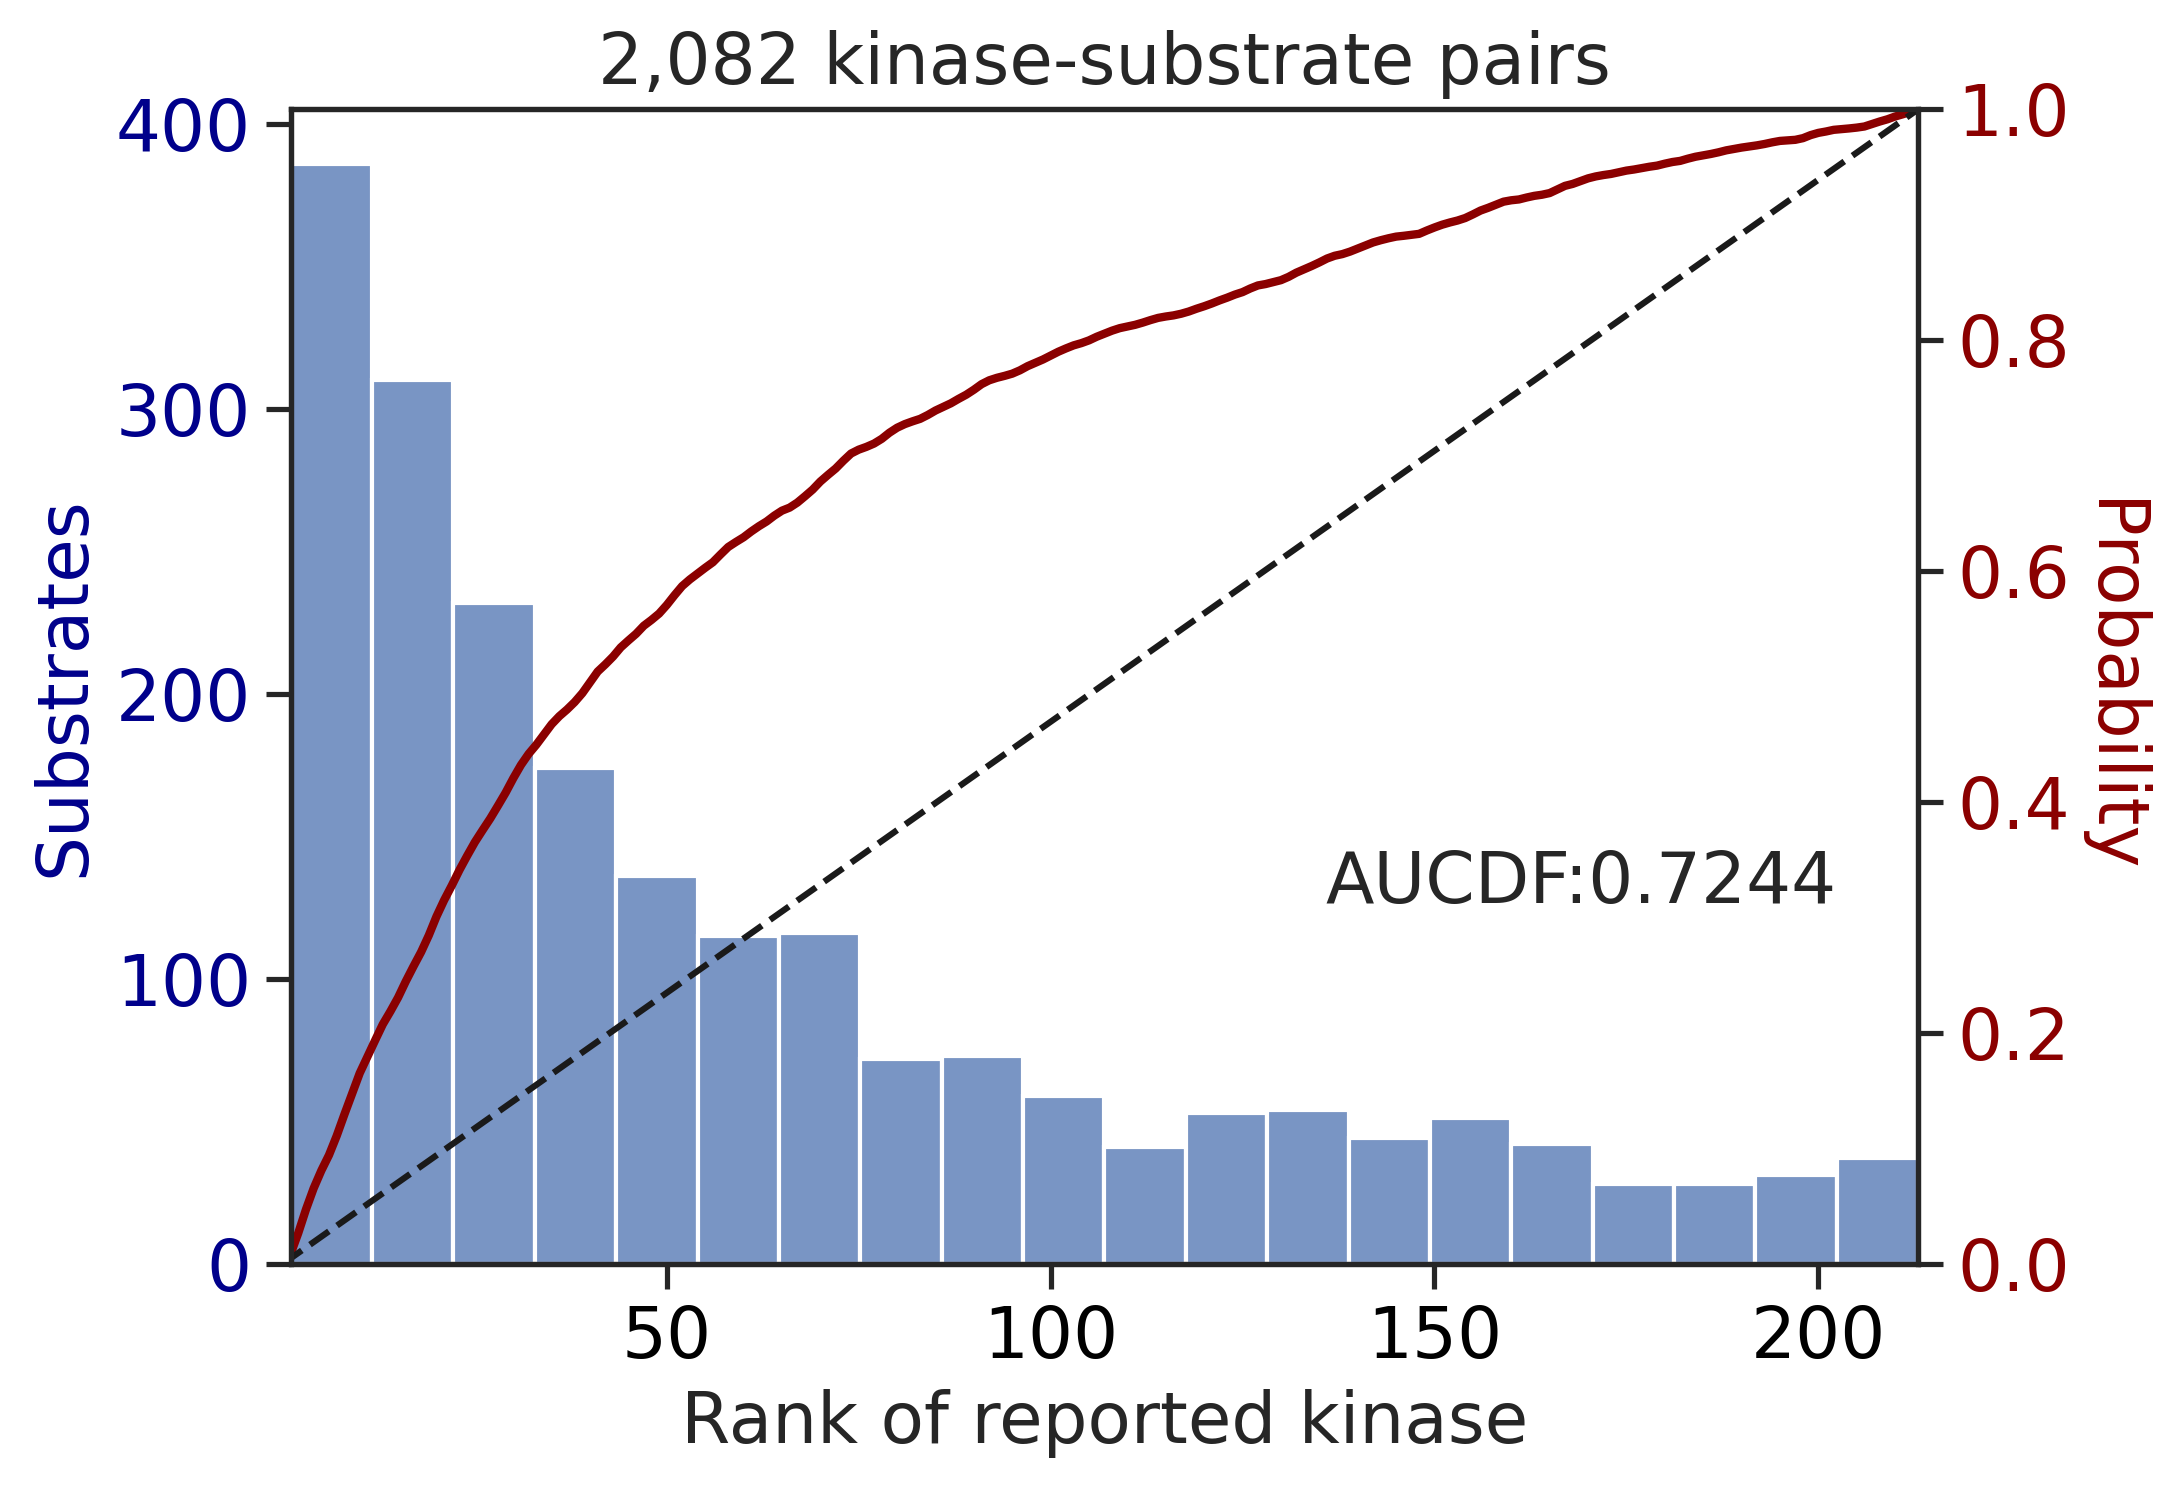

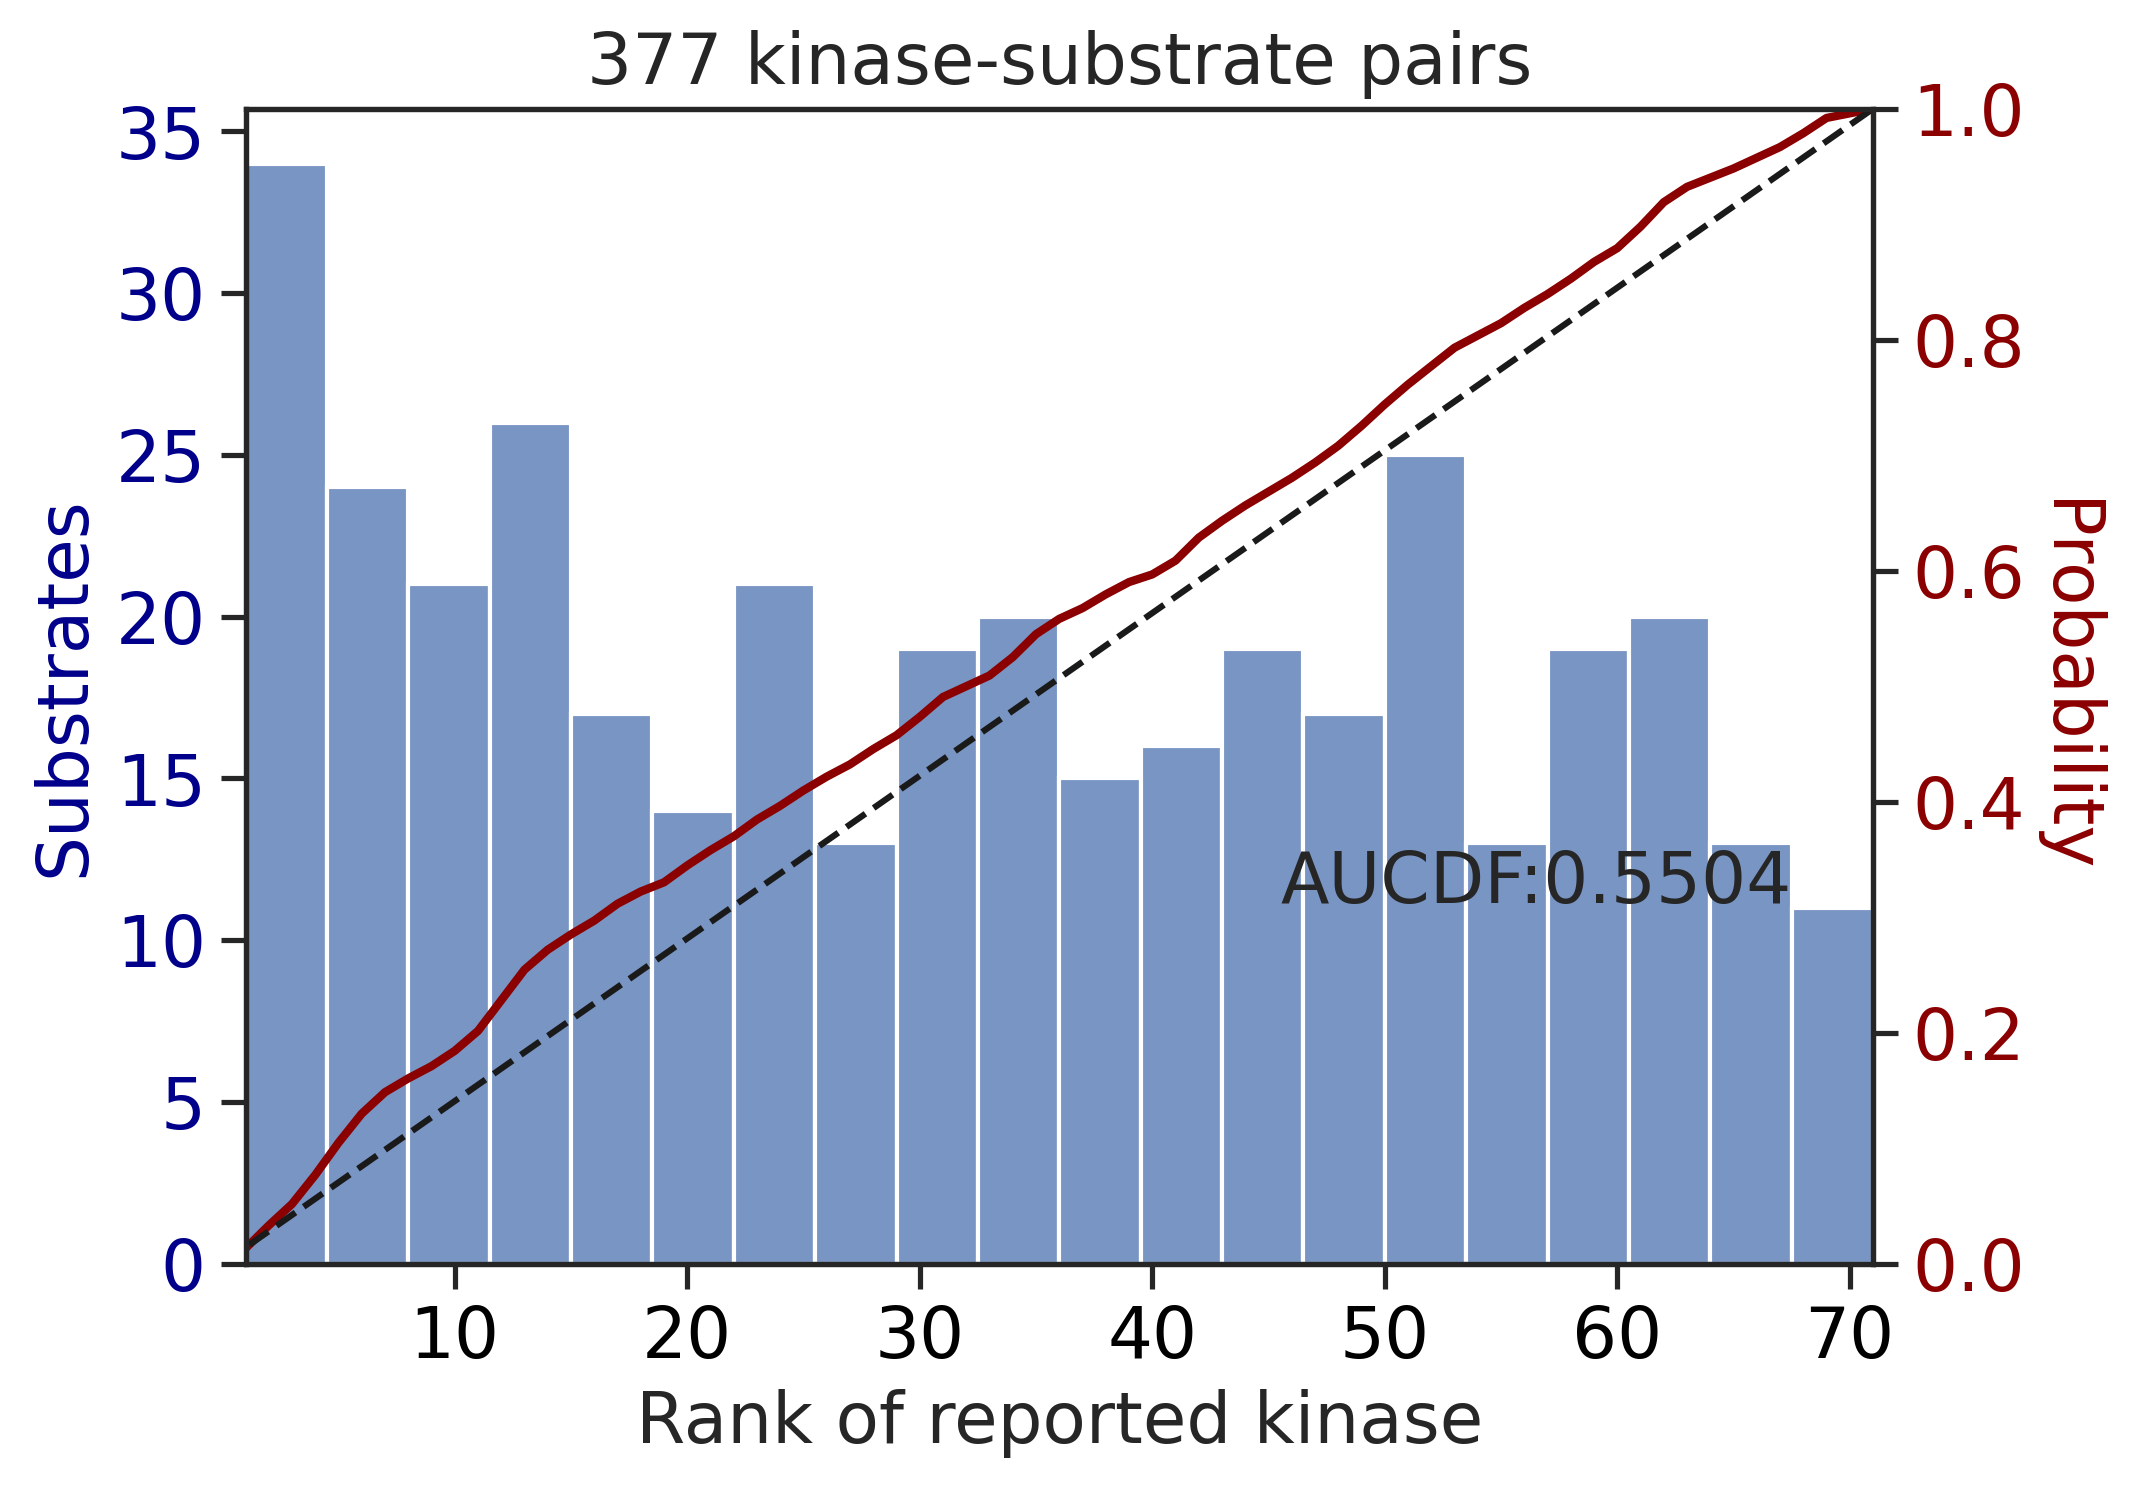

---------------------------------------------
CDDM: LO + sum
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging
input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


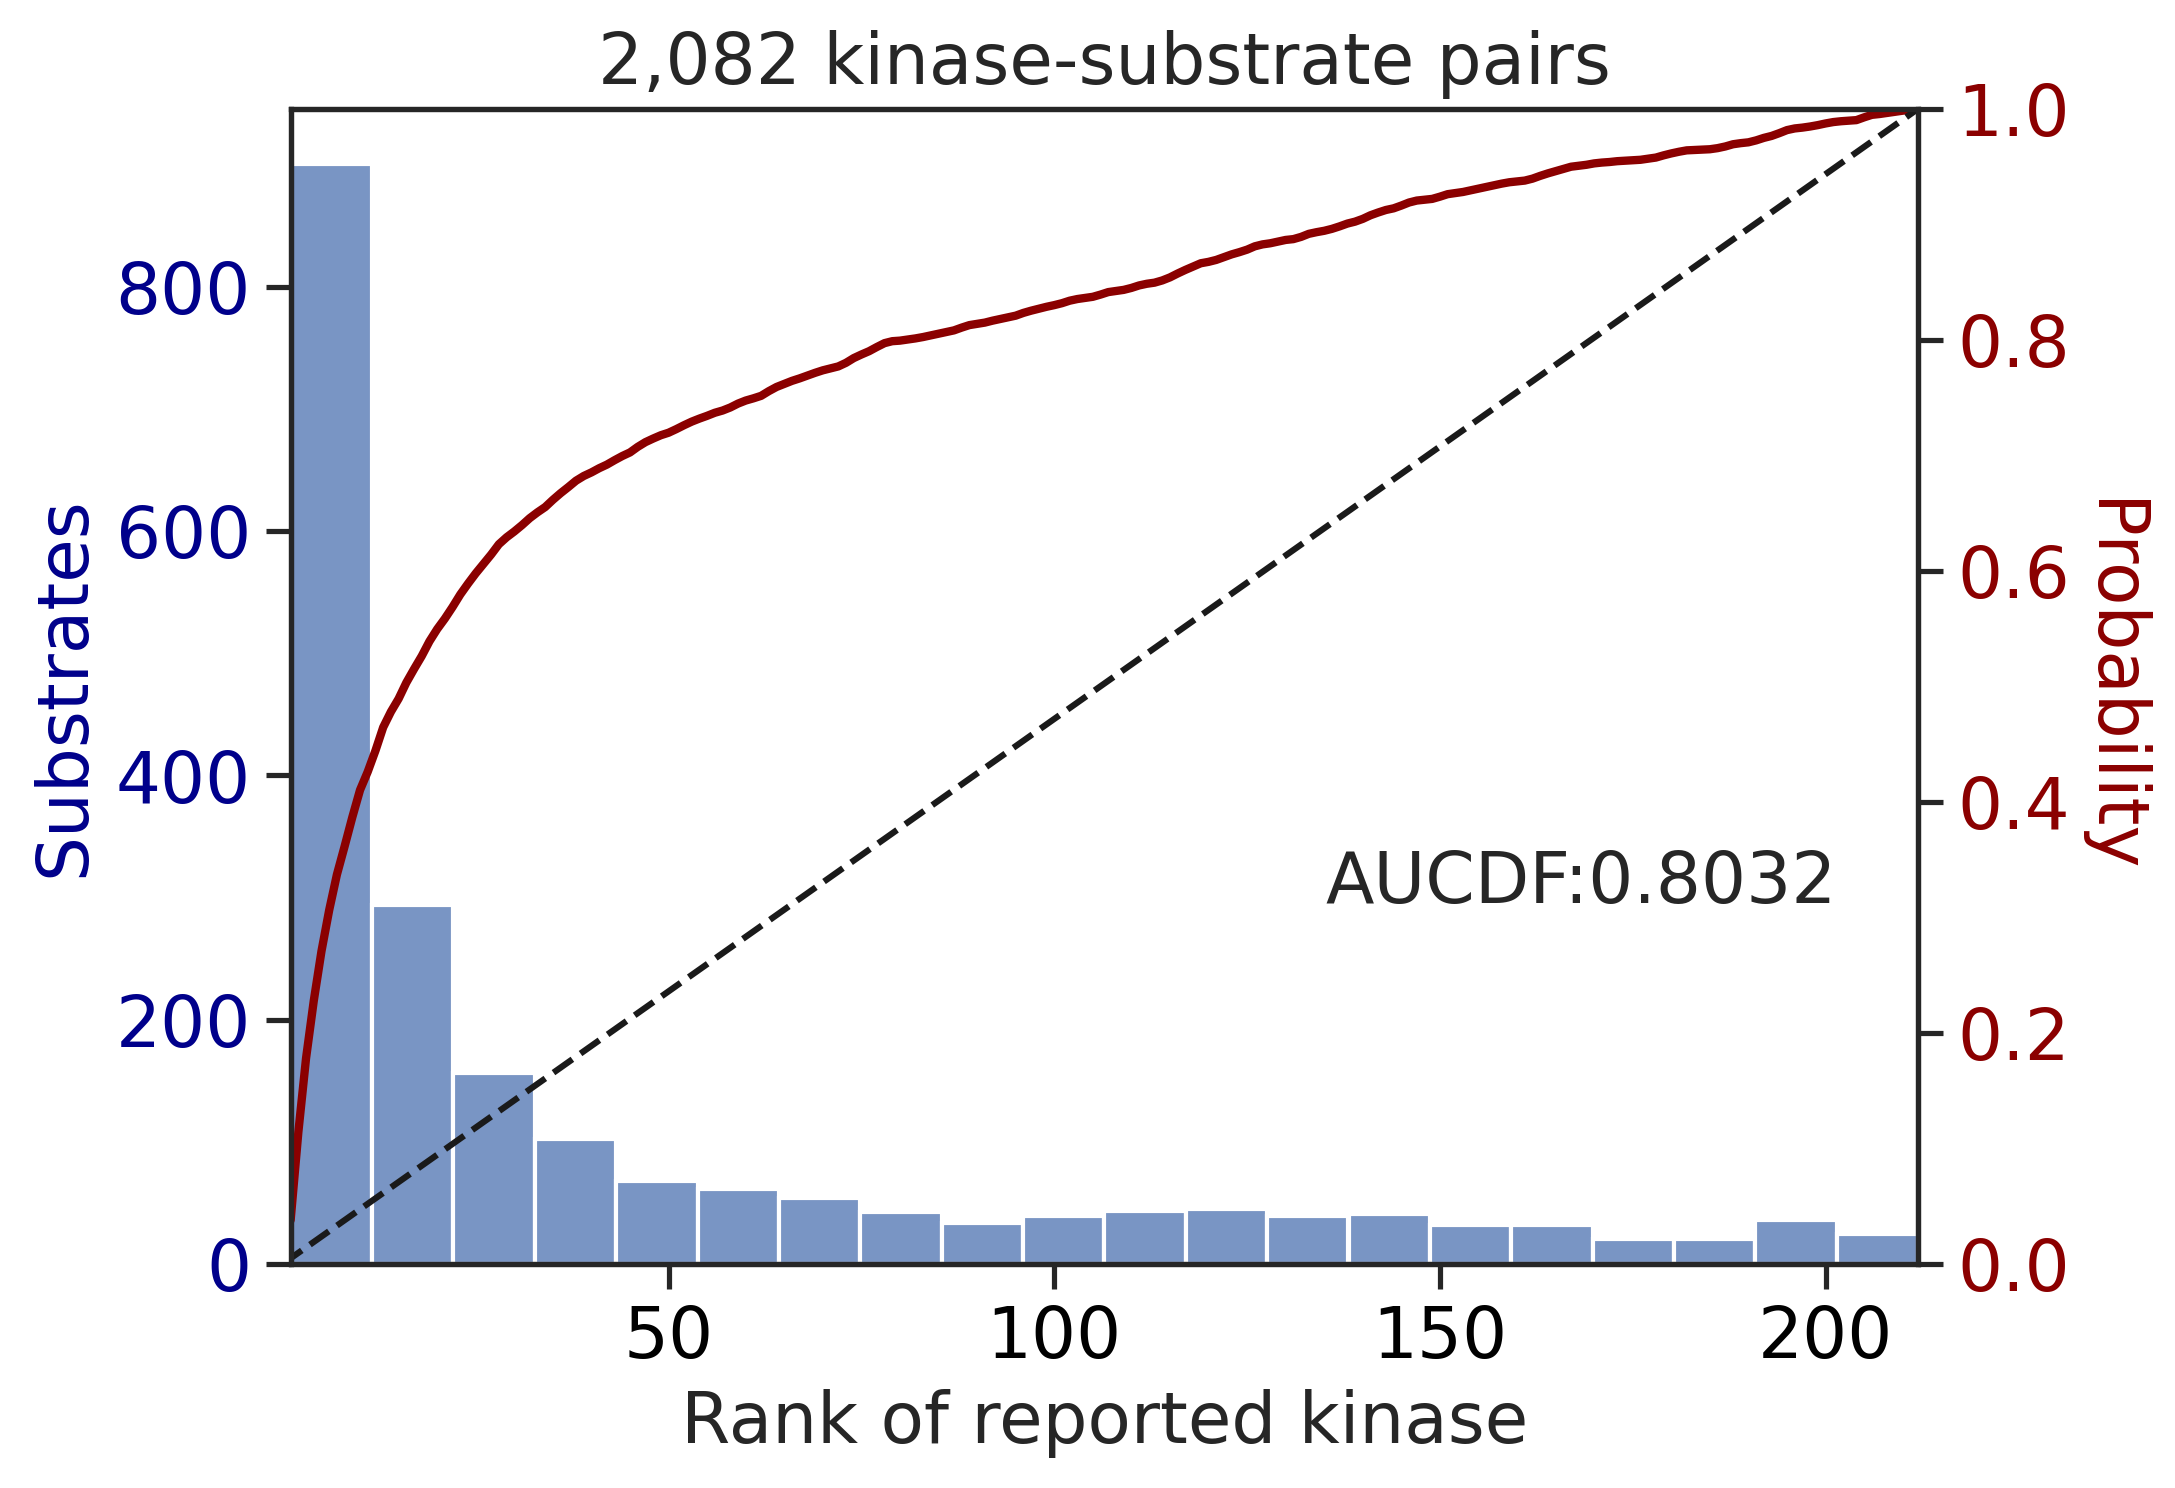

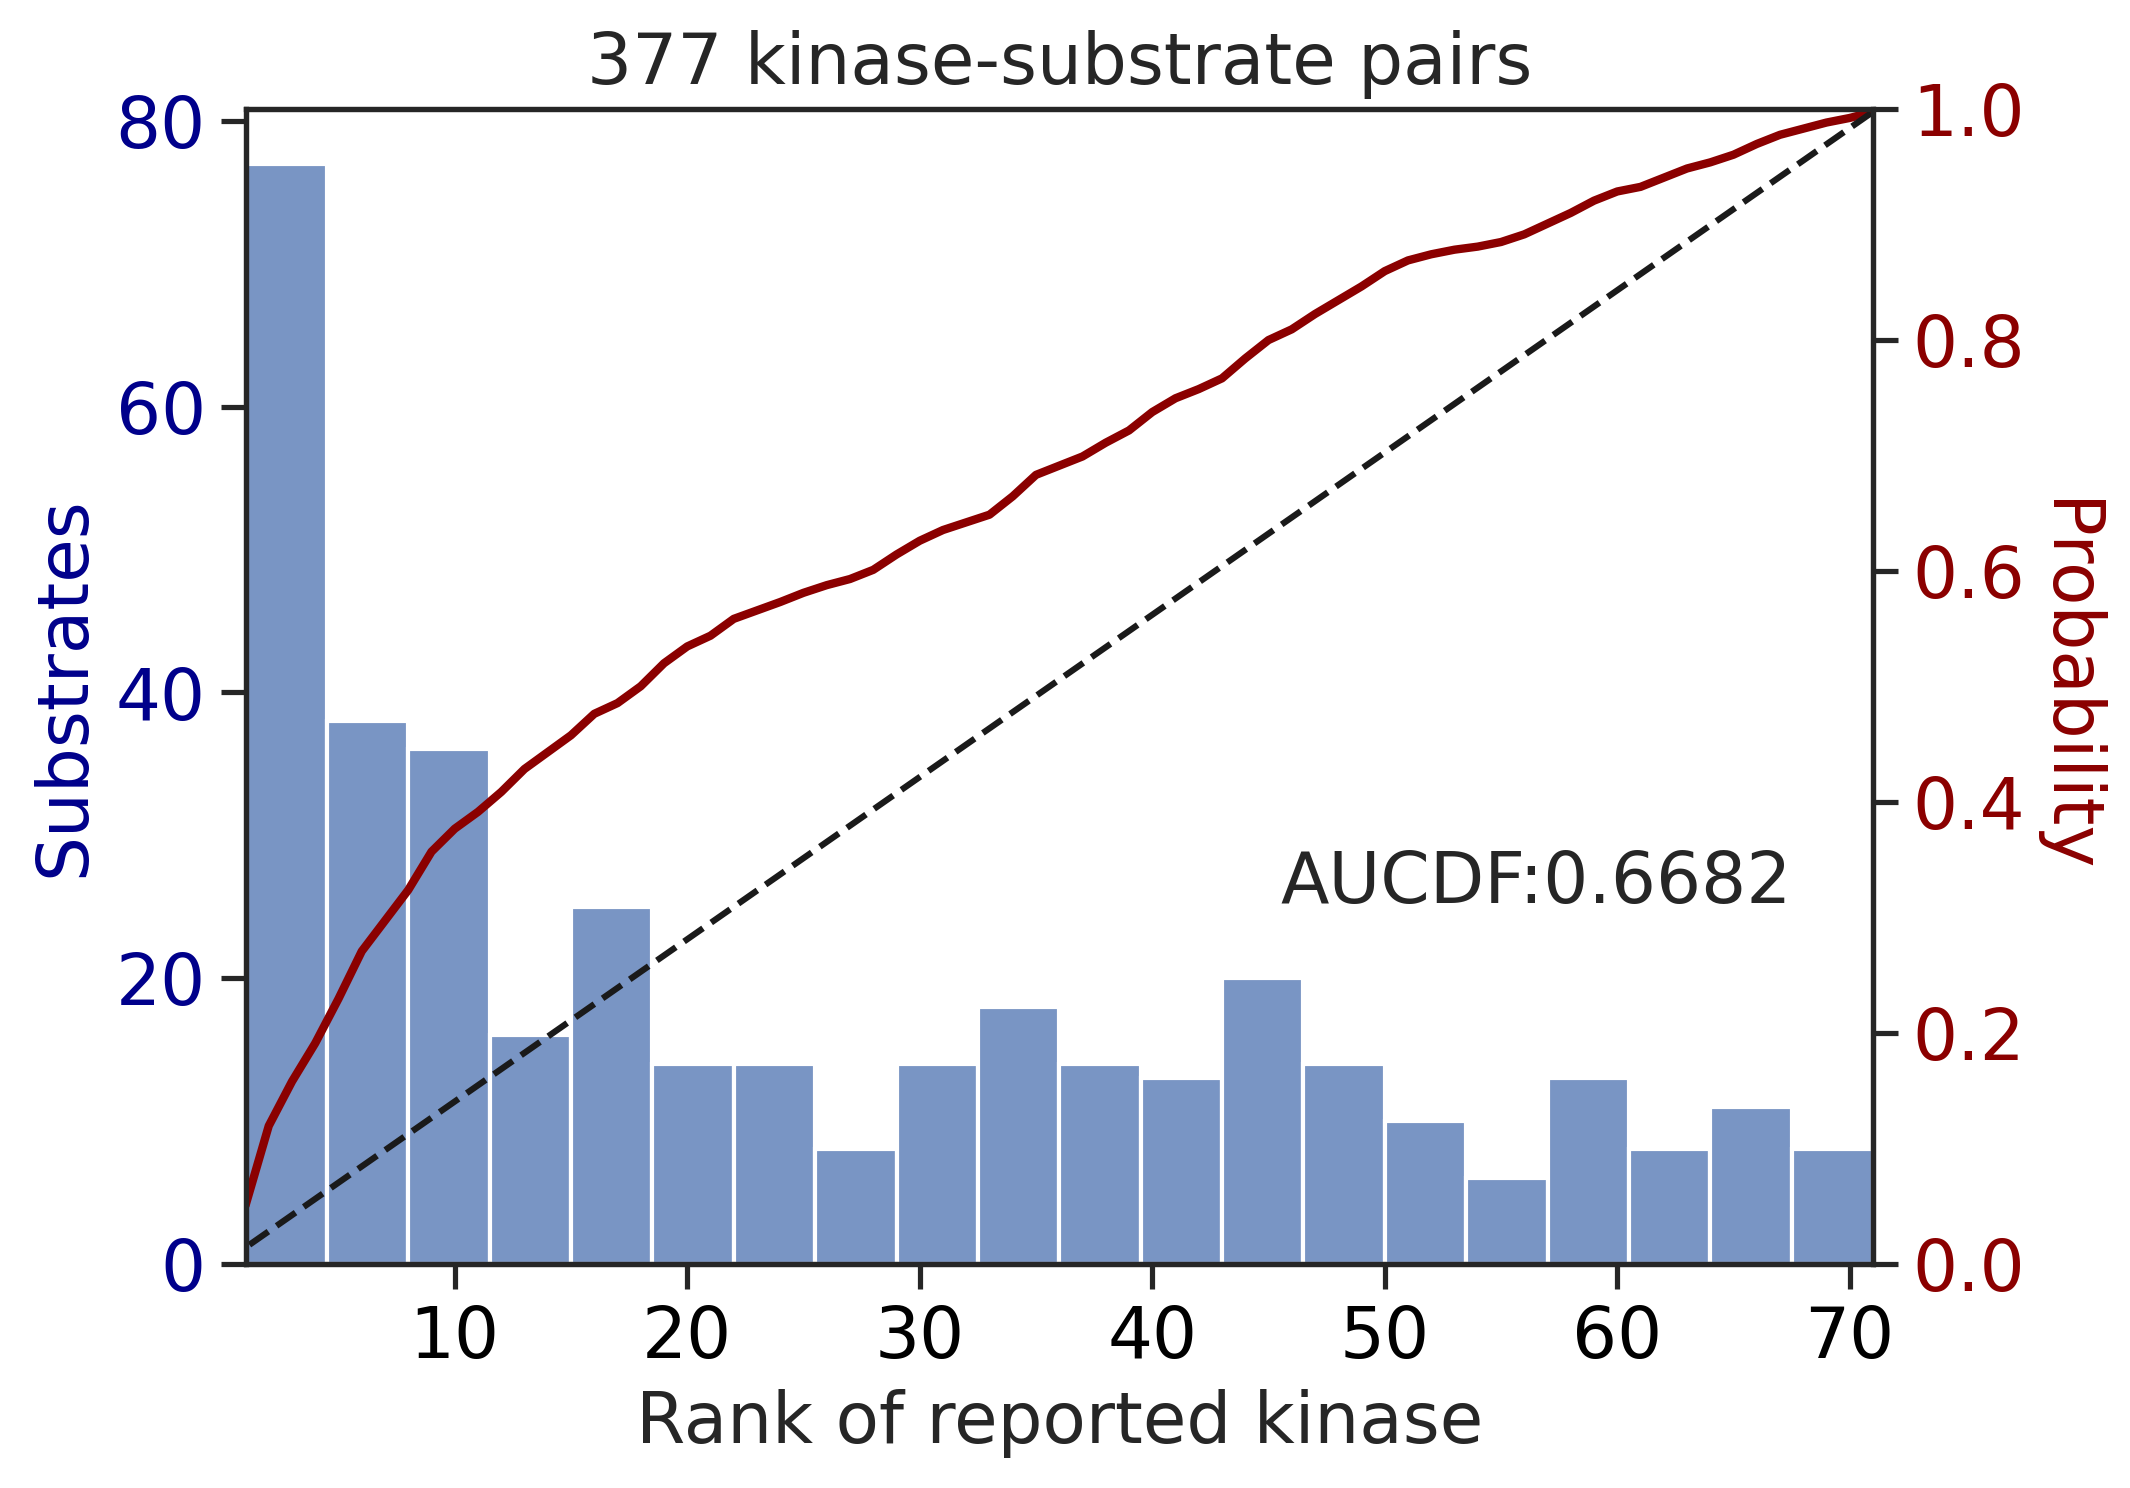

---------------------------------------------
CDDM: LO + sum + pct
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging
input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 832.33it/s]


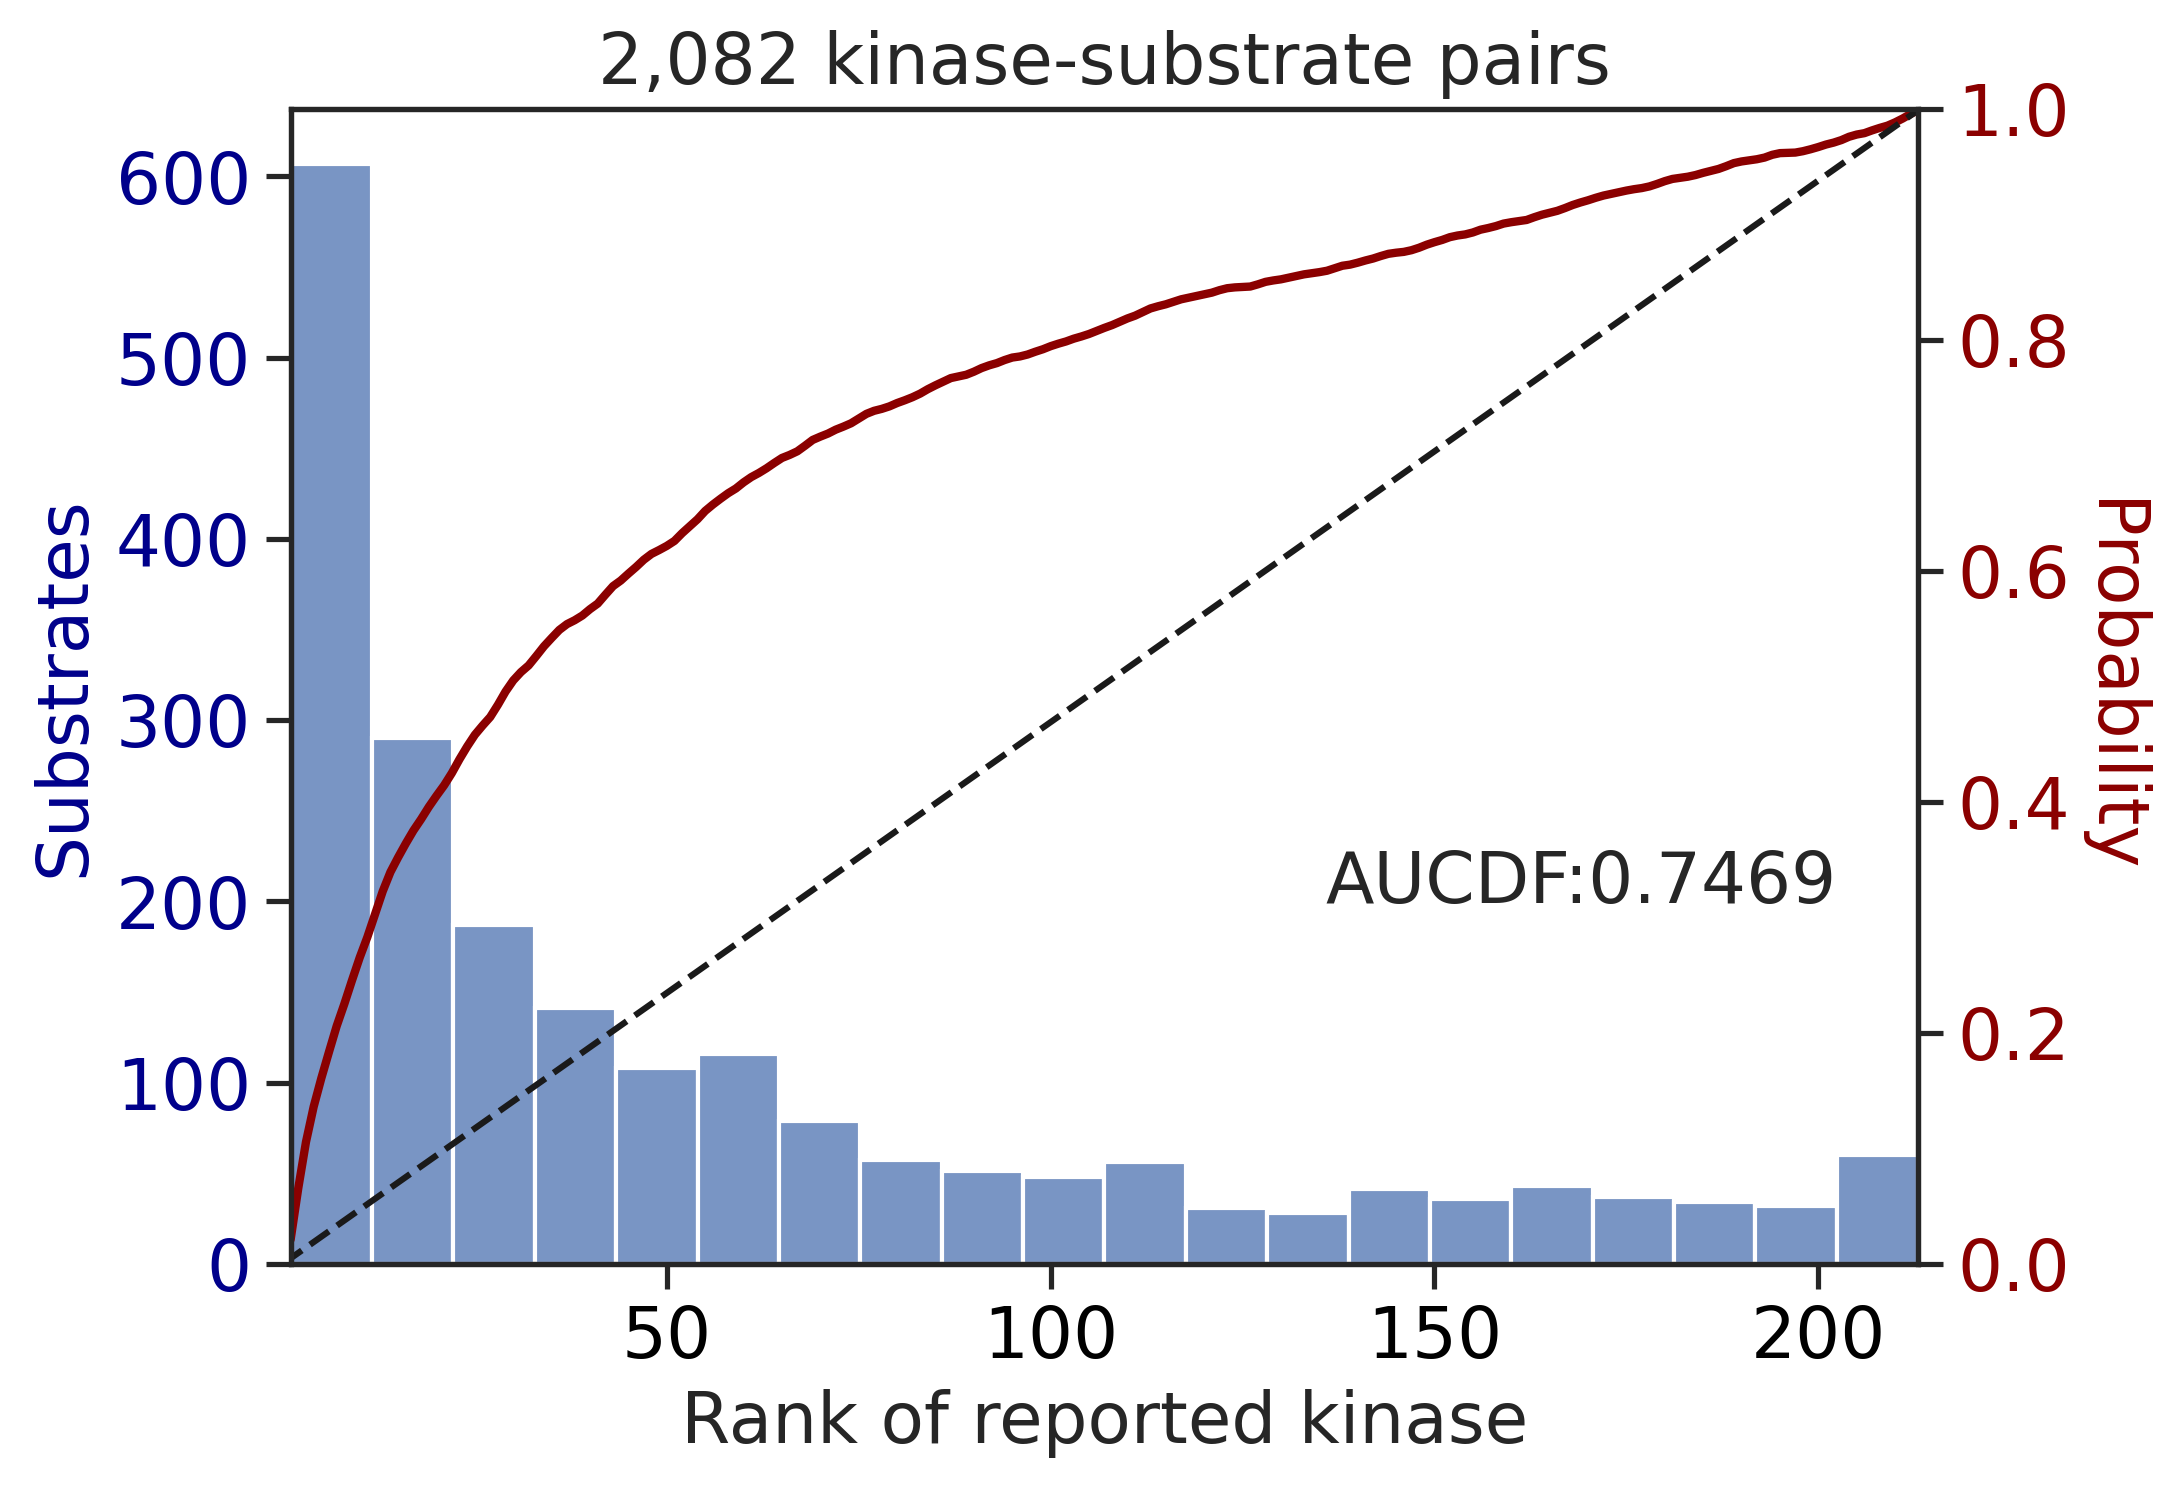

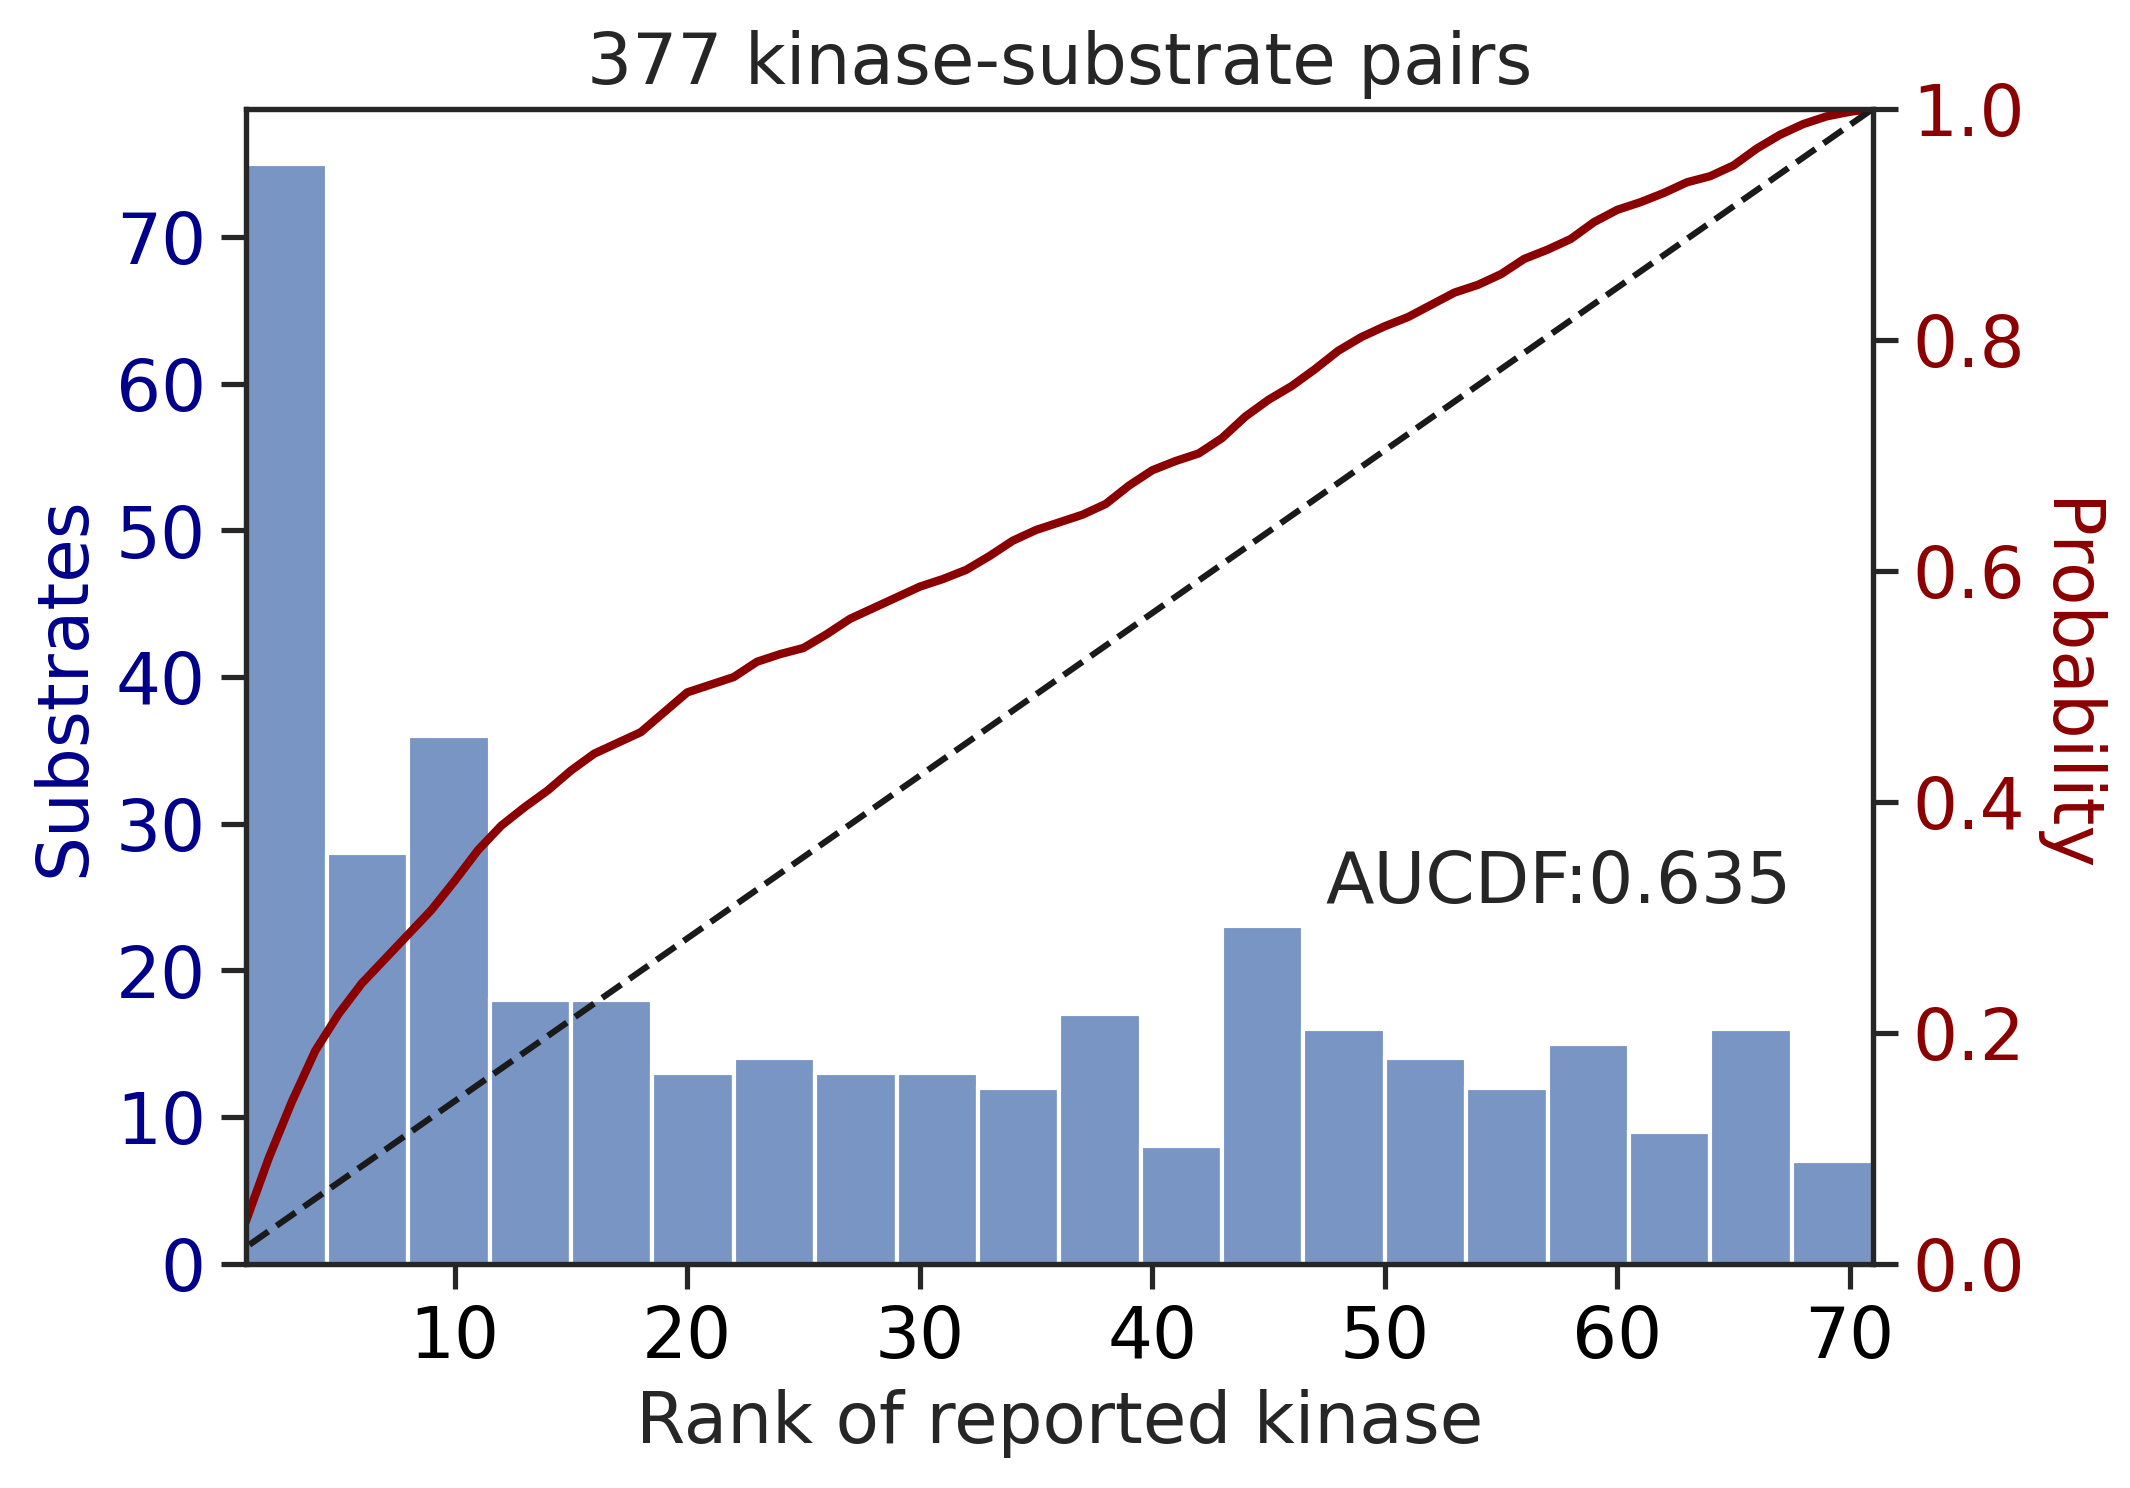

---------------------------------------------
CDDM: LO upper + sum
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging
input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


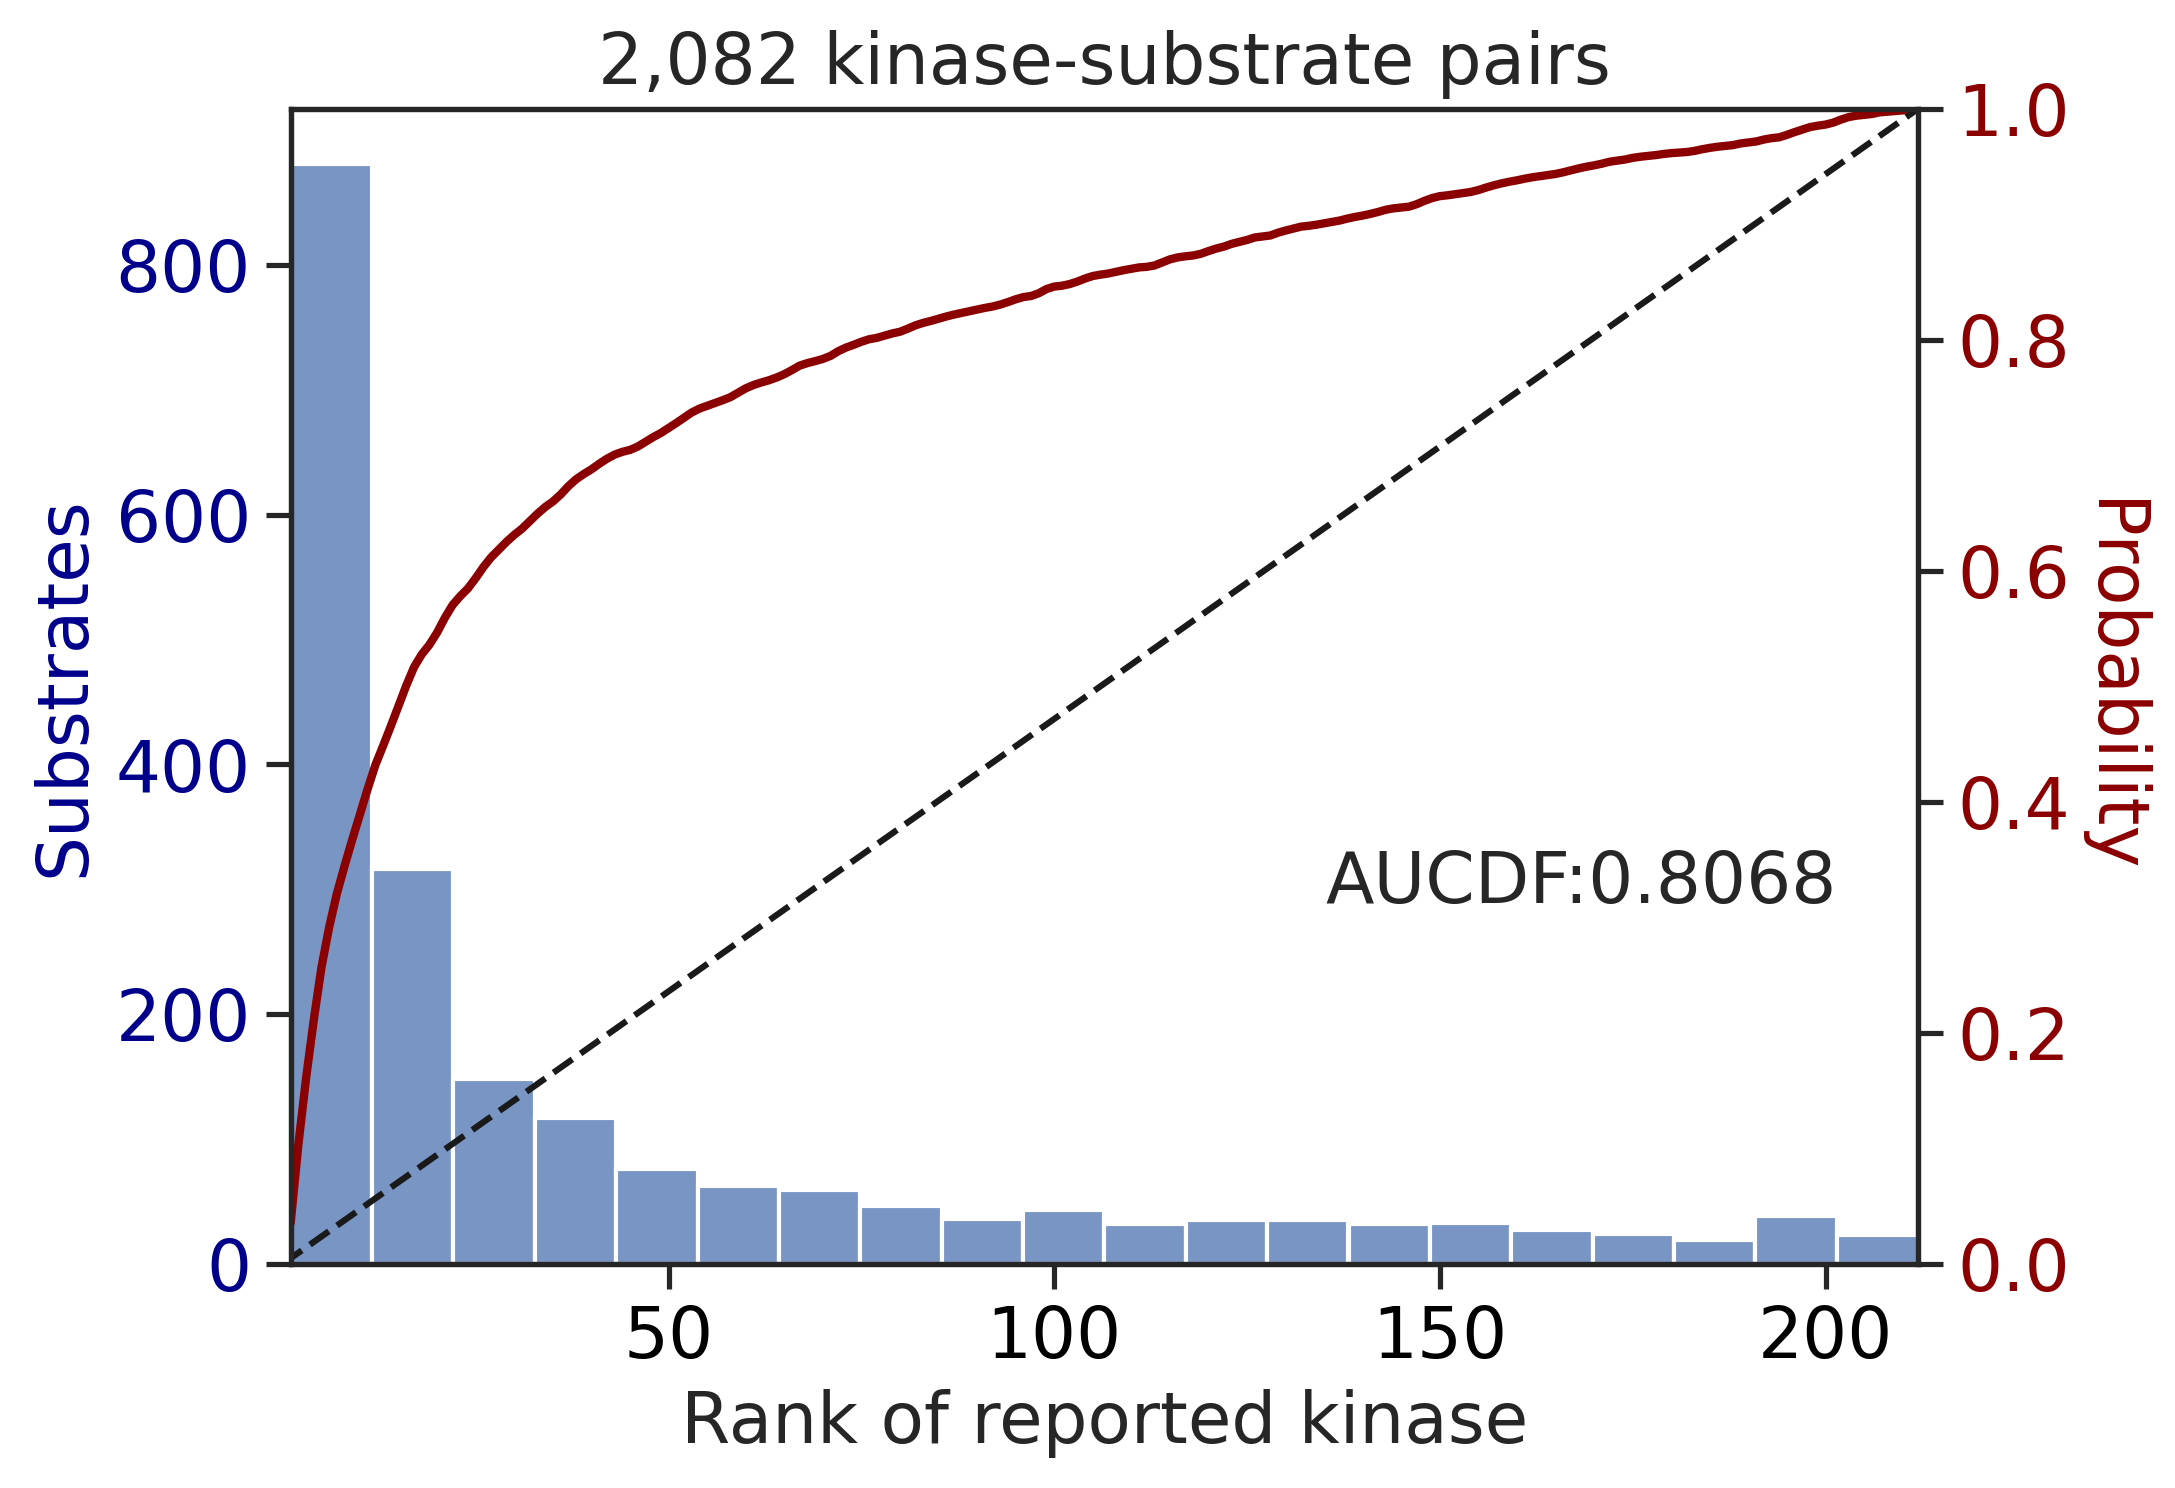

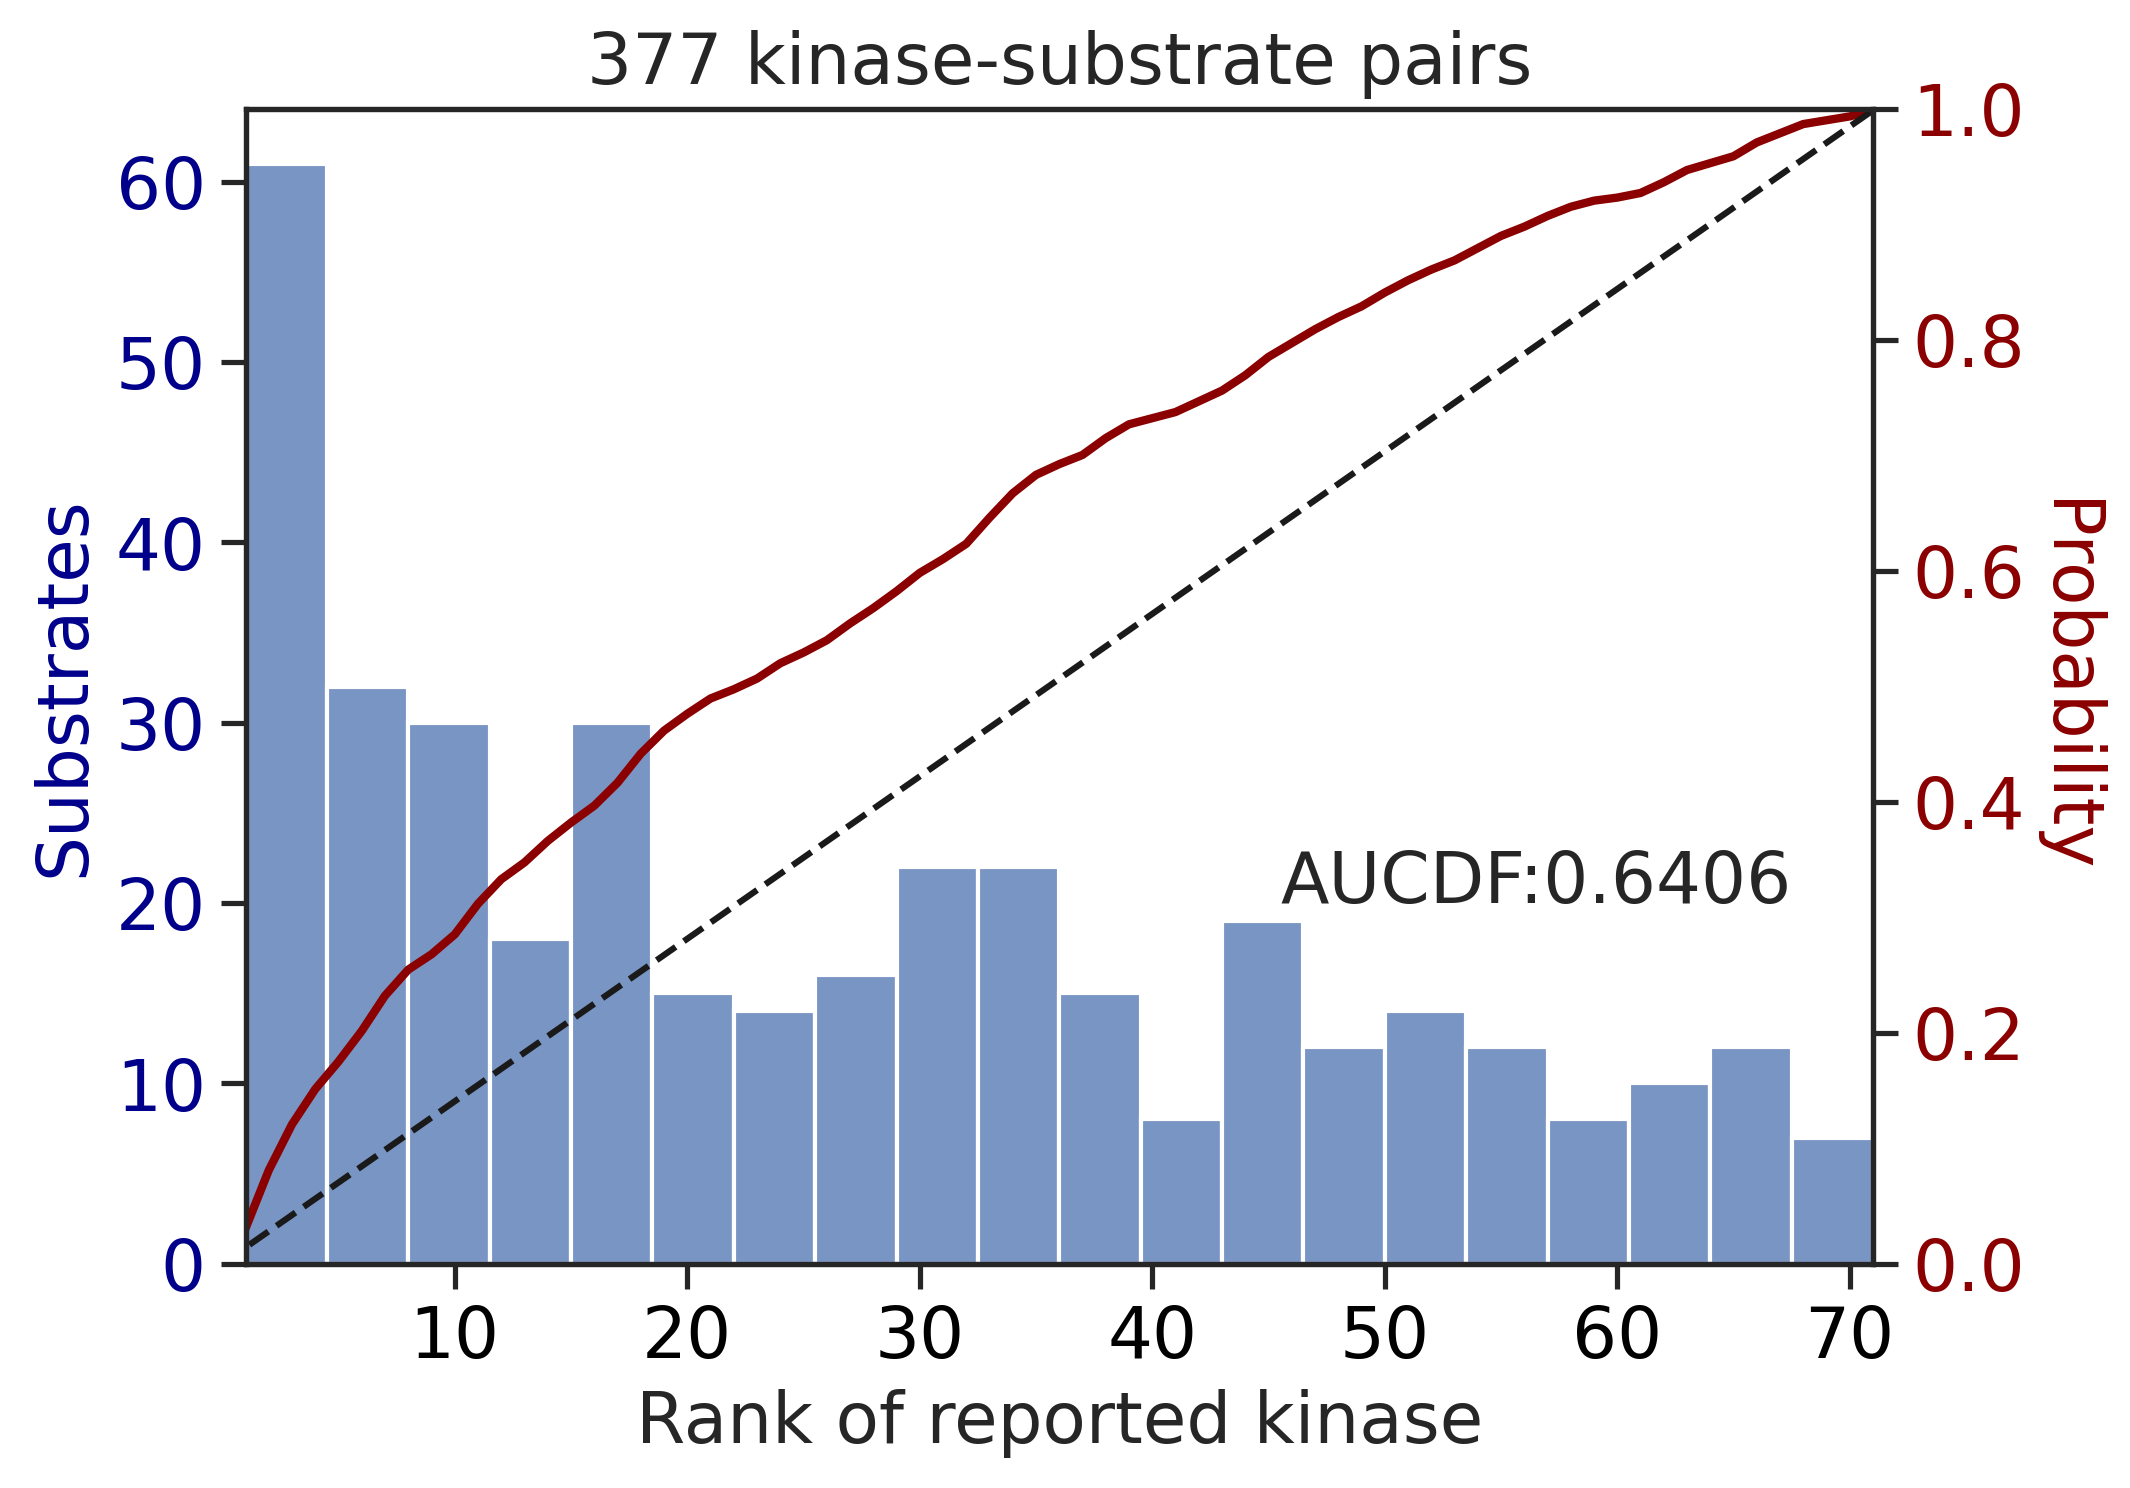

---------------------------------------------
CDDM: LO upper + sum + pct
input dataframe has a length 2082
Preprocessing
Finish preprocessing
Merging reference
Finish merging
input dataframe has a length 377
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 859.10it/s]


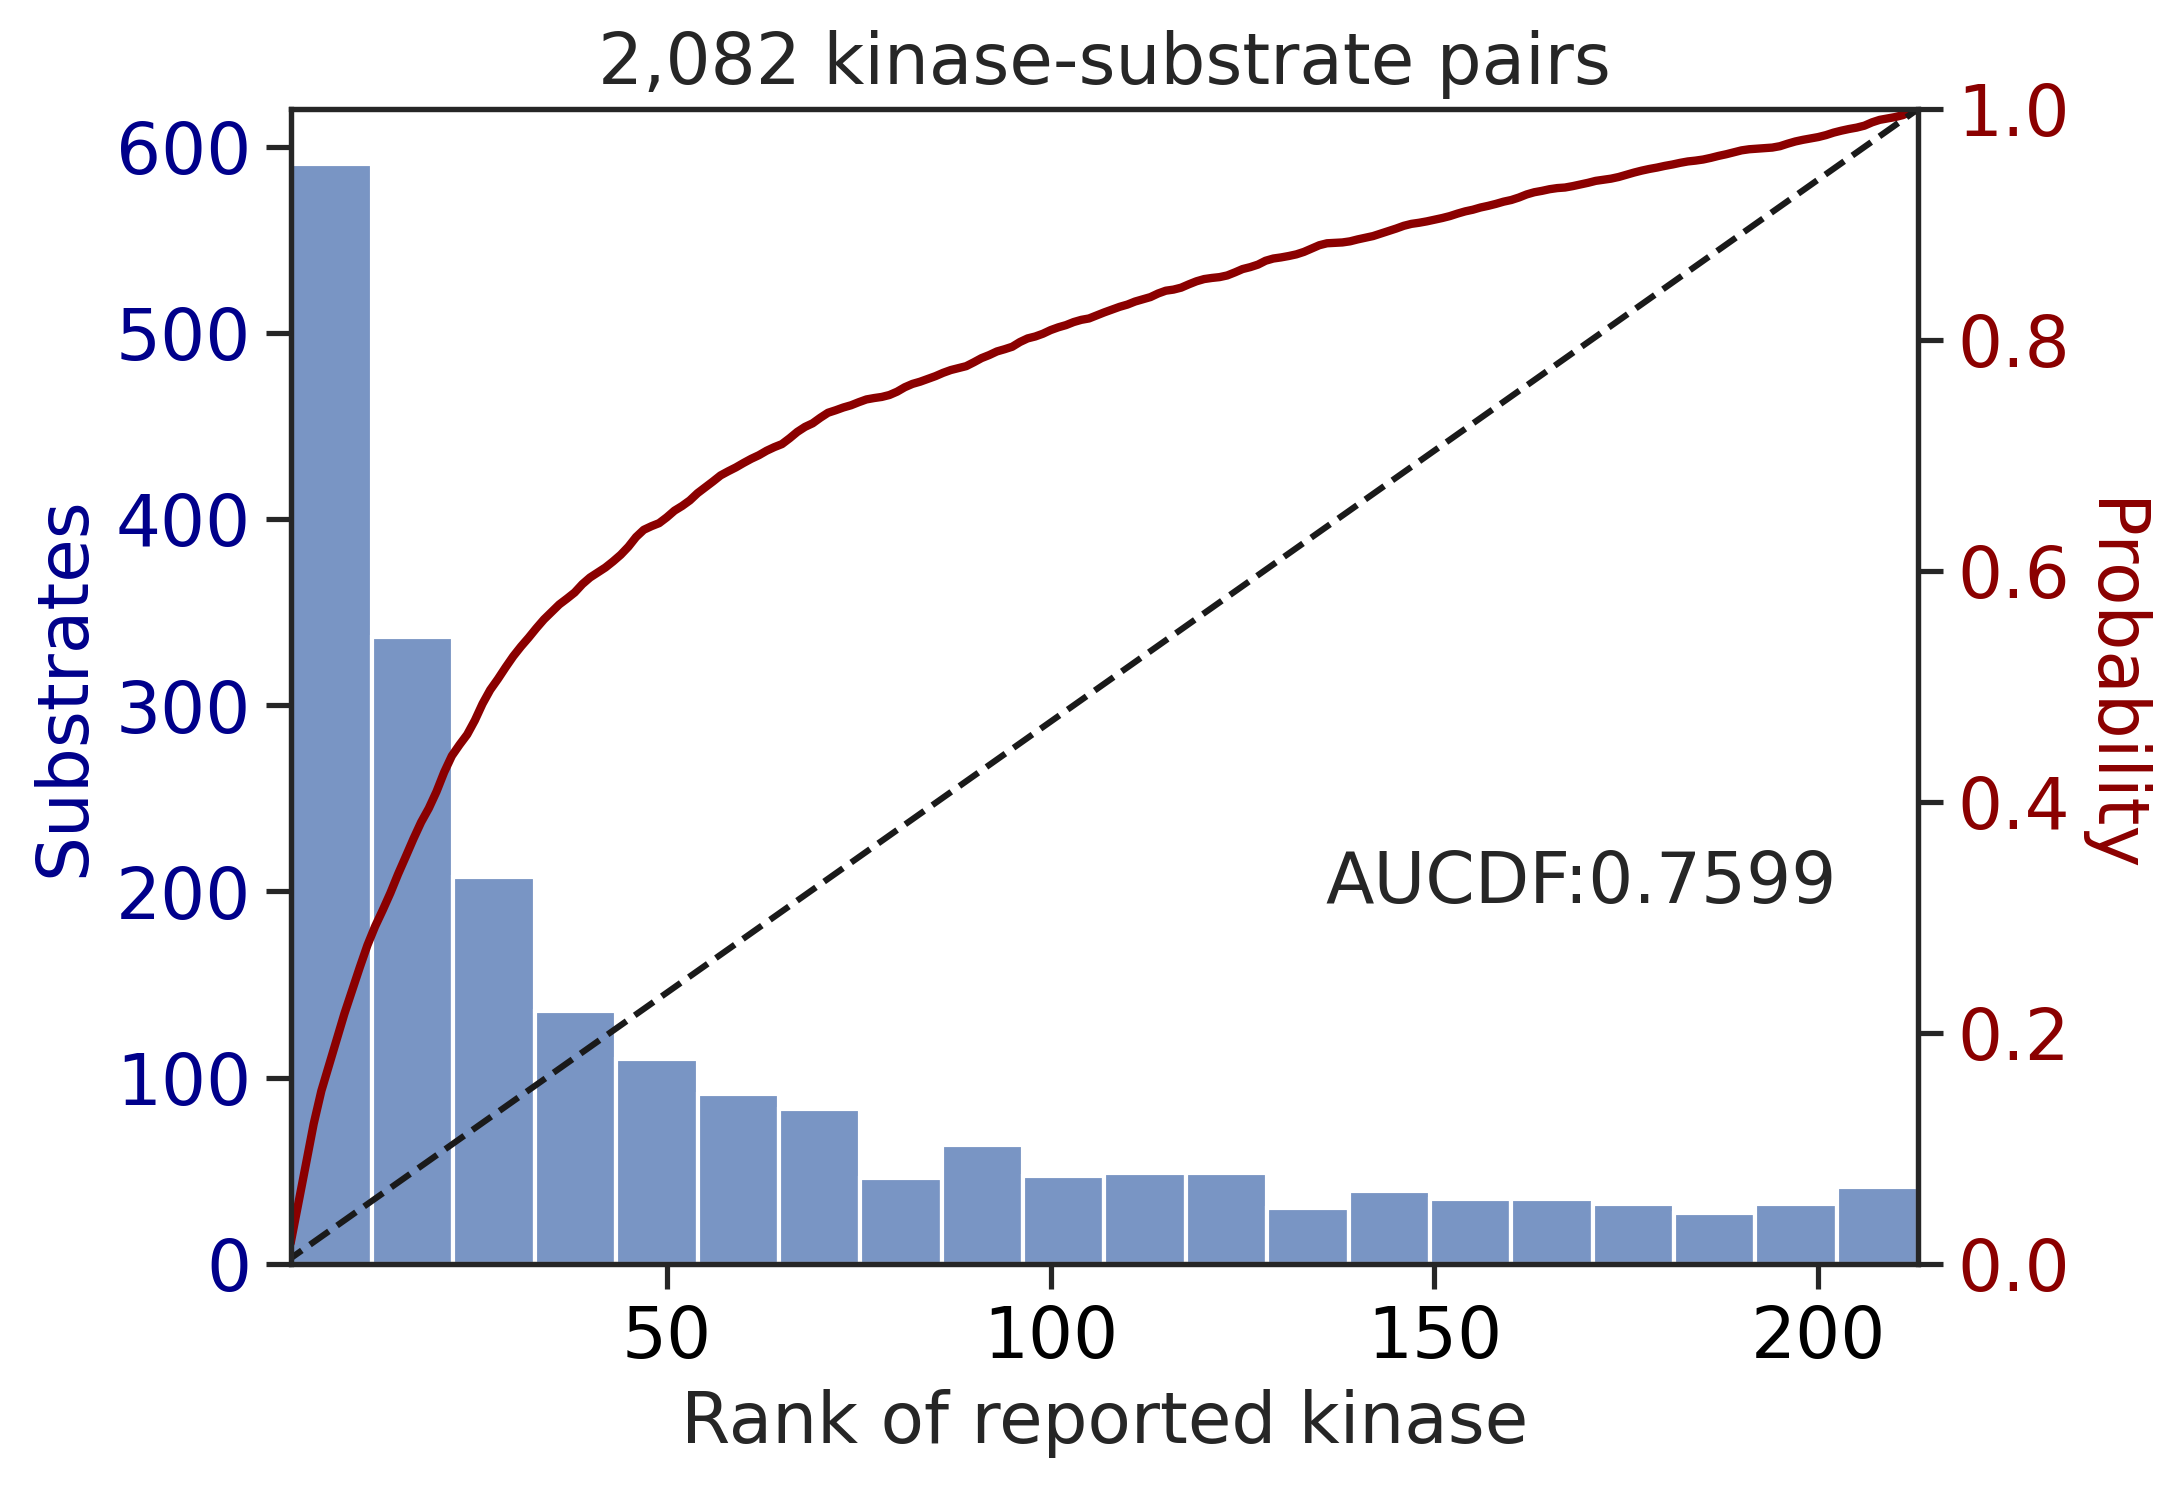

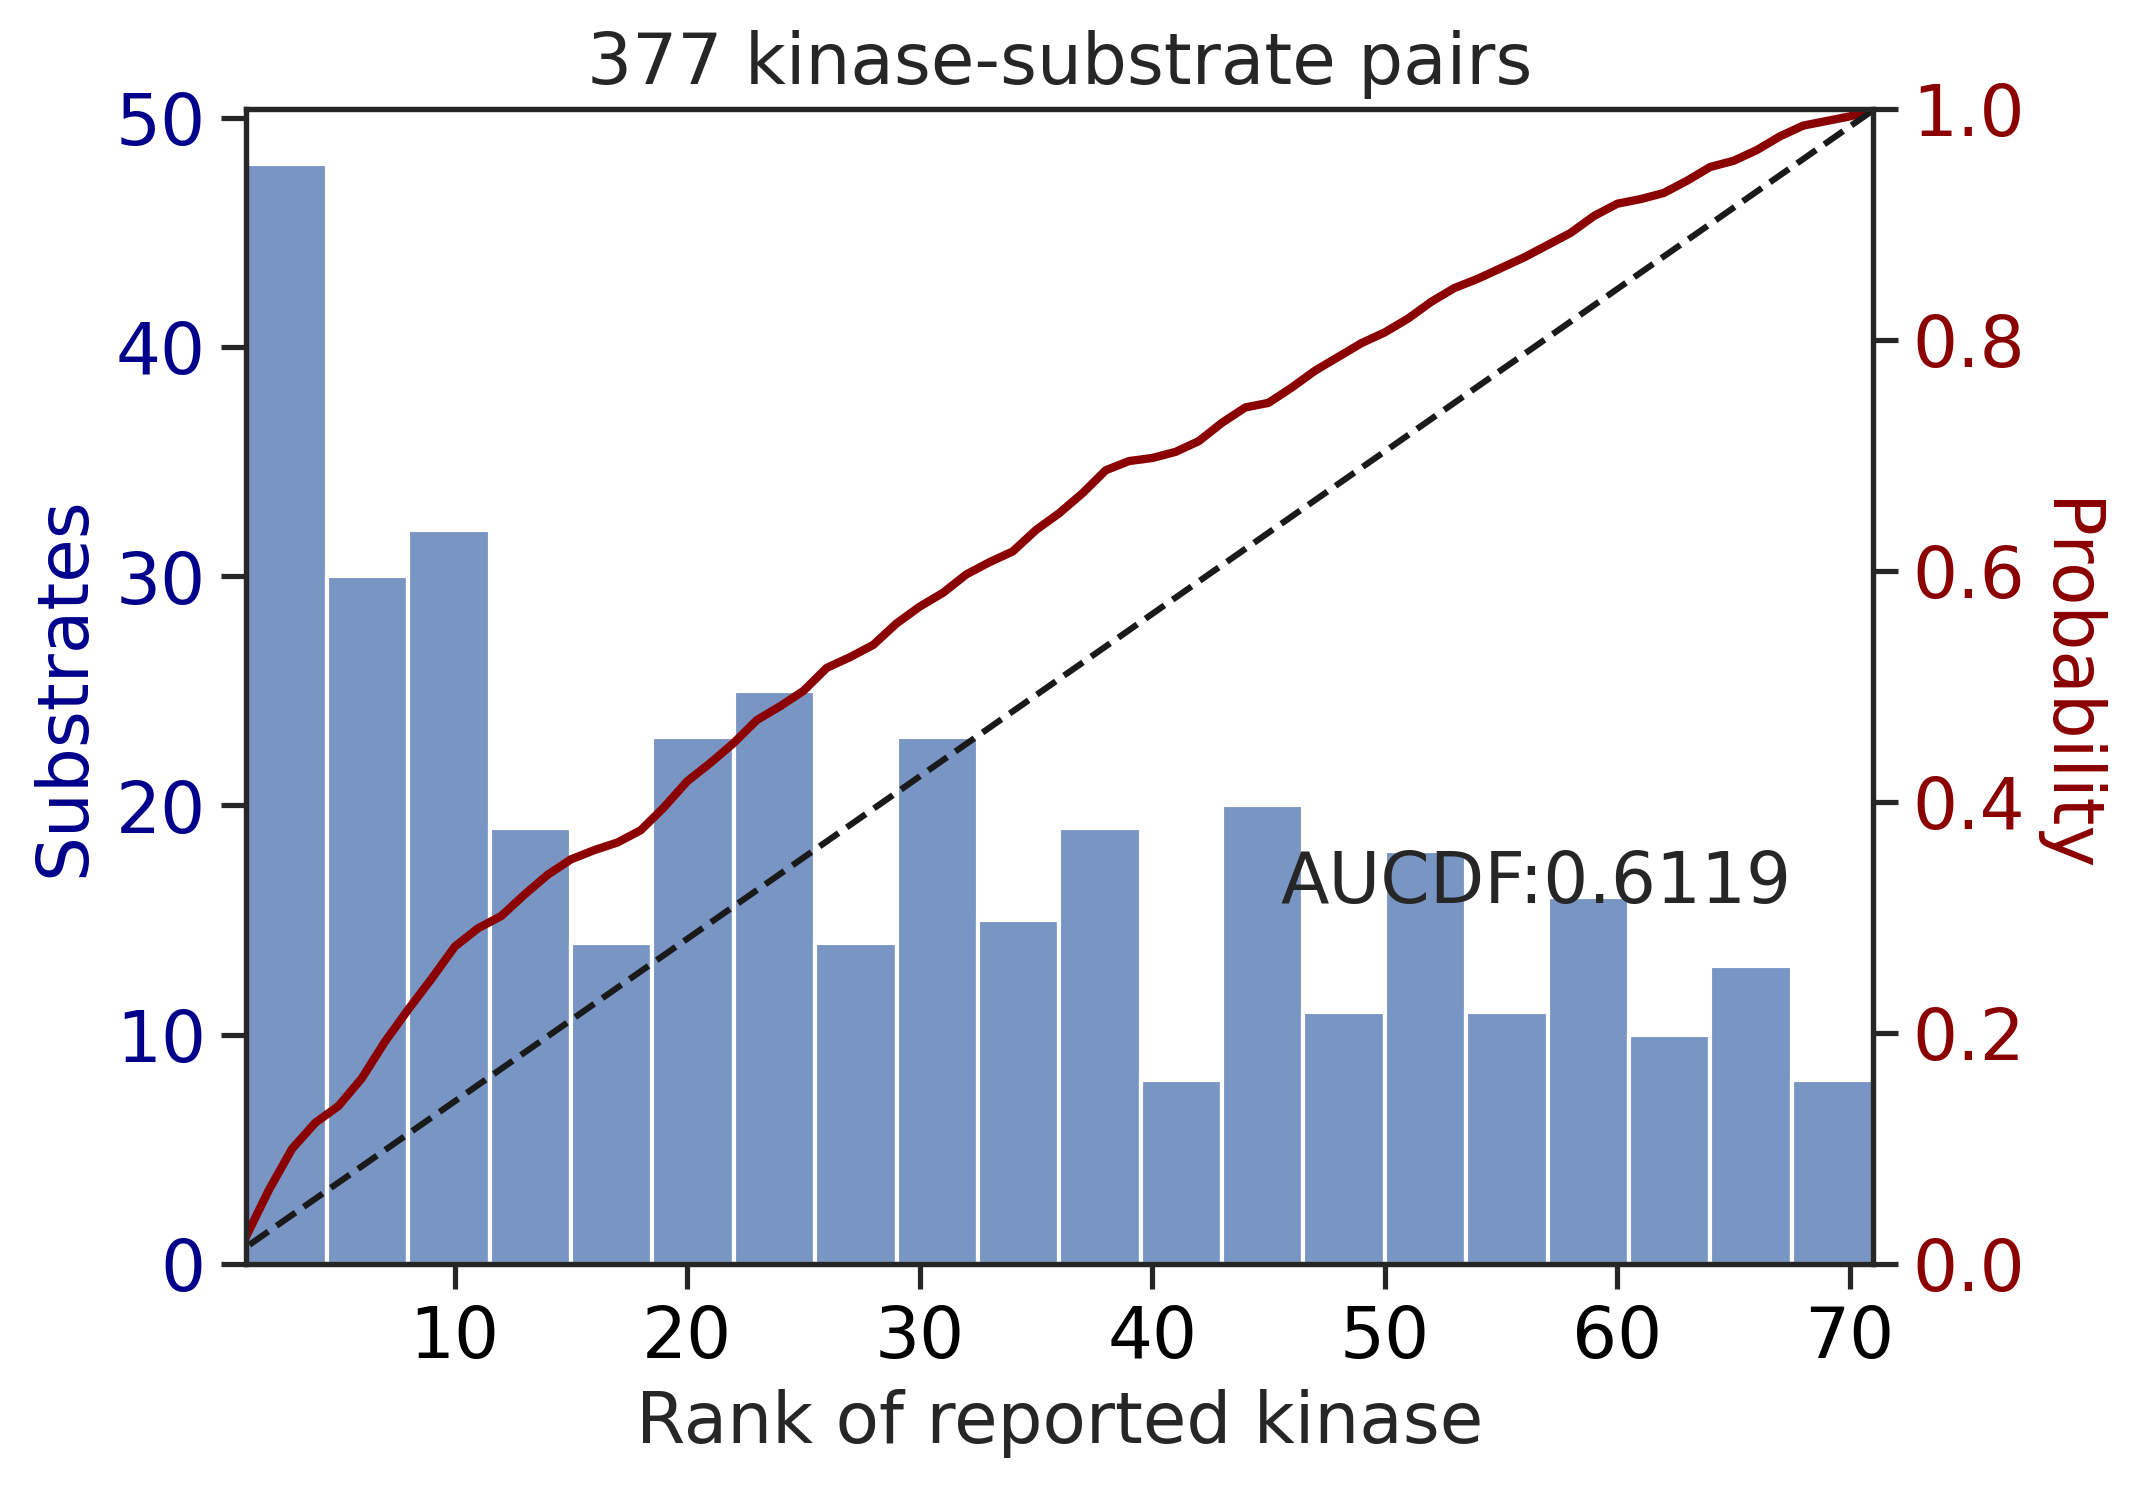

In [29]:
topk_dfs = []
aucdf = pd.DataFrame()
for name,(ref,seq_col,func,use_pct) in ref_dict.items():
    print('---------------------------------------------')
    print(name)
    pct_ref = pd.read_parquet(f'raw/{name[:-6]}.parquet') if use_pct else None # -6 to remove + pct from parquet name
    df_st,df_tyr,df_st_result,df_tyr_result = score_data(df,ref,seq_col=seq_col,func=func,pct_ref=pct_ref)
    topk,aucdf_st,aucdf_tyr = get_results(df_st,df_tyr,df_st_result,df_tyr_result)
    topk_dfs.append(topk)
    aucdf.loc[name,'ST'] = aucdf_st
    aucdf.loc[name,'Tyr'] = aucdf_tyr

In [31]:
aucdf = aucdf.T

In [32]:
aucdf = aucdf.reset_index(names='group')

In [33]:
aucdf

group  PSPA: PSSM + multiply  PSPA: PSSM + multiply + pct  \
0    ST               0.810725                     0.794840   
1   Tyr               0.606243                     0.582133   

   CDDM: PSSM + multiply  CDDM: PSSM + multiply + pct  \
0               0.803220                     0.713528   
1               0.668217                     0.589020   

   CDDM: PSSM upper + multiply  CDDM: PSSM upper + multiply + pct  \
0                     0.806753                           0.724447   
1                     0.640603                           0.550436   

   CDDM: LO + sum  CDDM: LO + sum + pct  CDDM: LO upper + sum  \
0        0.803220              0.746919              0.806753   
1        0.668217              0.634985              0.640603   

   CDDM: LO upper + sum + pct  
0                    0.759939  
1                    0.611936

In [34]:
aucdf.set_index('group').T.sort_values('Tyr')

group                                    ST       Tyr
CDDM: PSSM upper + multiply + pct  0.724447  0.550436
PSPA: PSSM + multiply + pct        0.794840  0.582133
CDDM: PSSM + multiply + pct        0.713528  0.589020
PSPA: PSSM + multiply              0.810725  0.606243
CDDM: LO upper + sum + pct         0.759939  0.611936
CDDM: LO + sum + pct               0.746919  0.634985
CDDM: LO upper + sum               0.806753  0.640603
CDDM: PSSM upper + multiply        0.806753  0.640603
CDDM: LO + sum                     0.803220  0.668217
CDDM: PSSM + multiply              0.803220  0.668217

Text(0, 0.5, 'AUCDF')

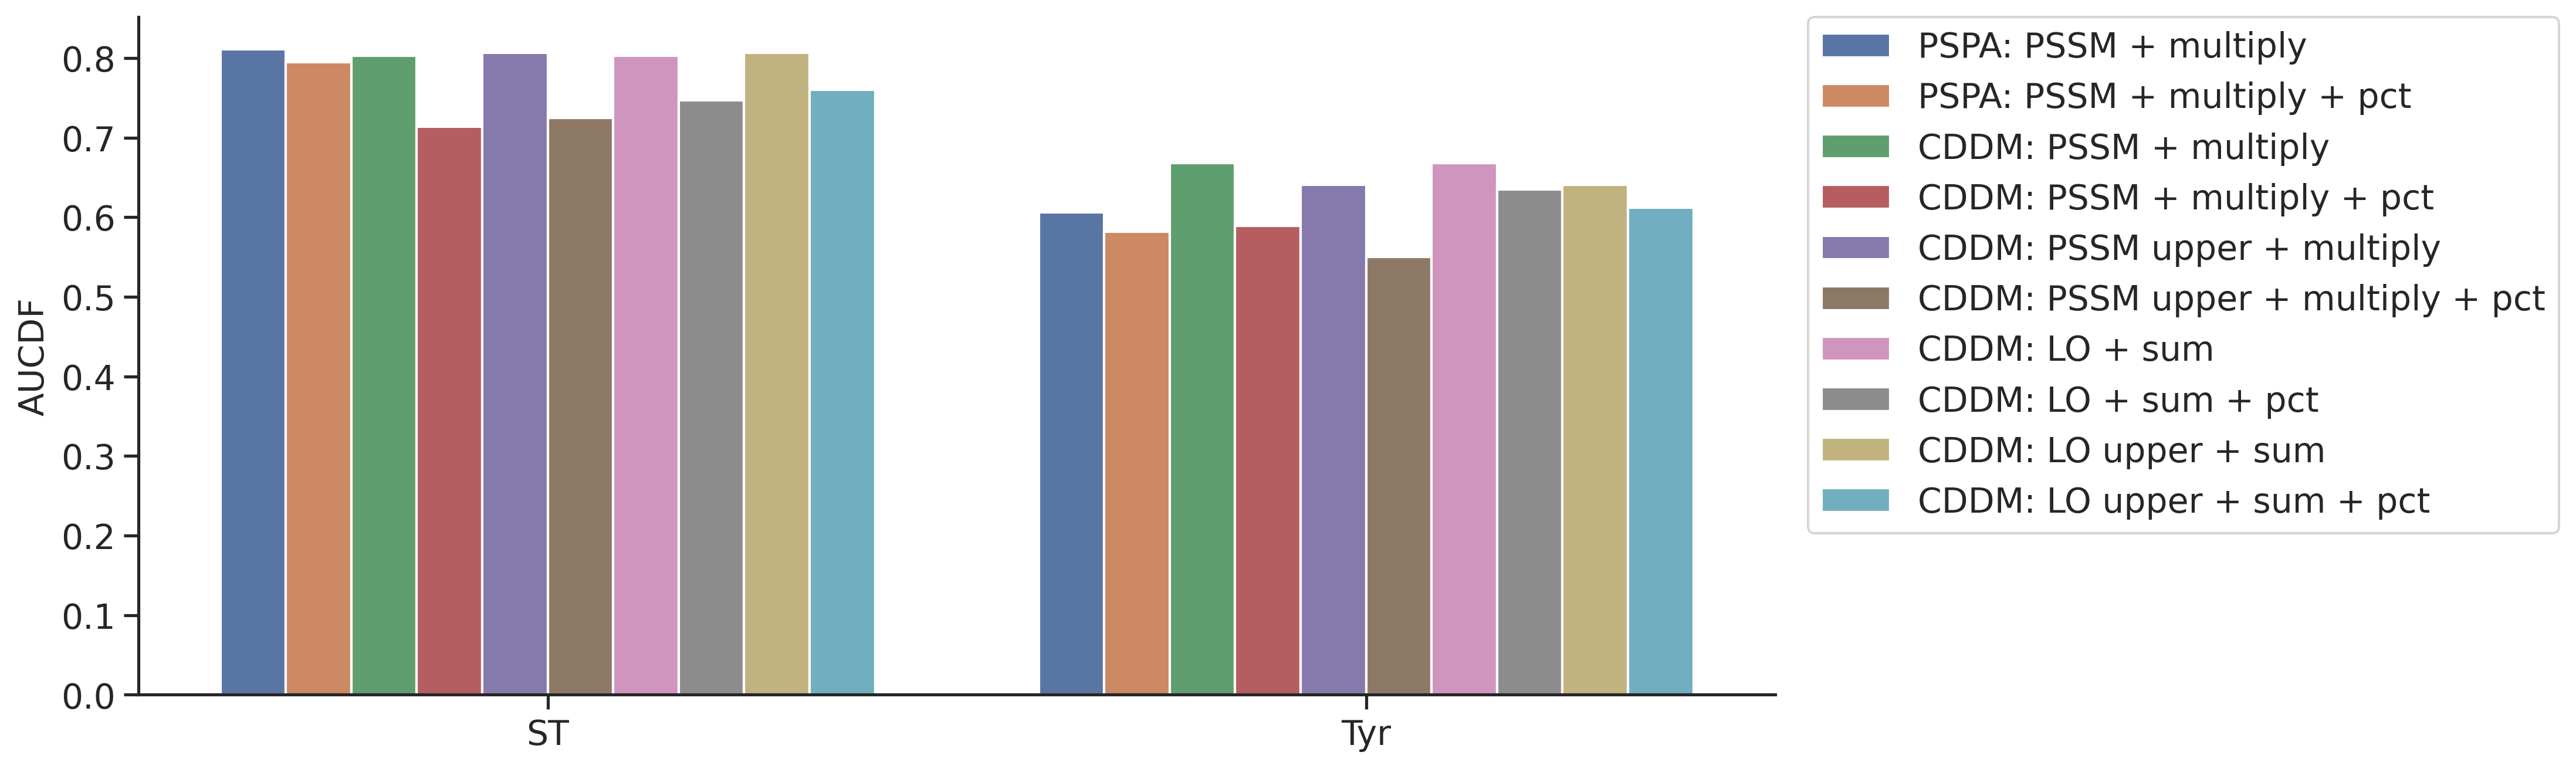

In [35]:
plot_group_bar(aucdf,value_cols=aucdf.columns[1:],group='group',rotation=0)
plt.ylabel('AUCDF')

Text(0, 0.5, 'AUCDF')

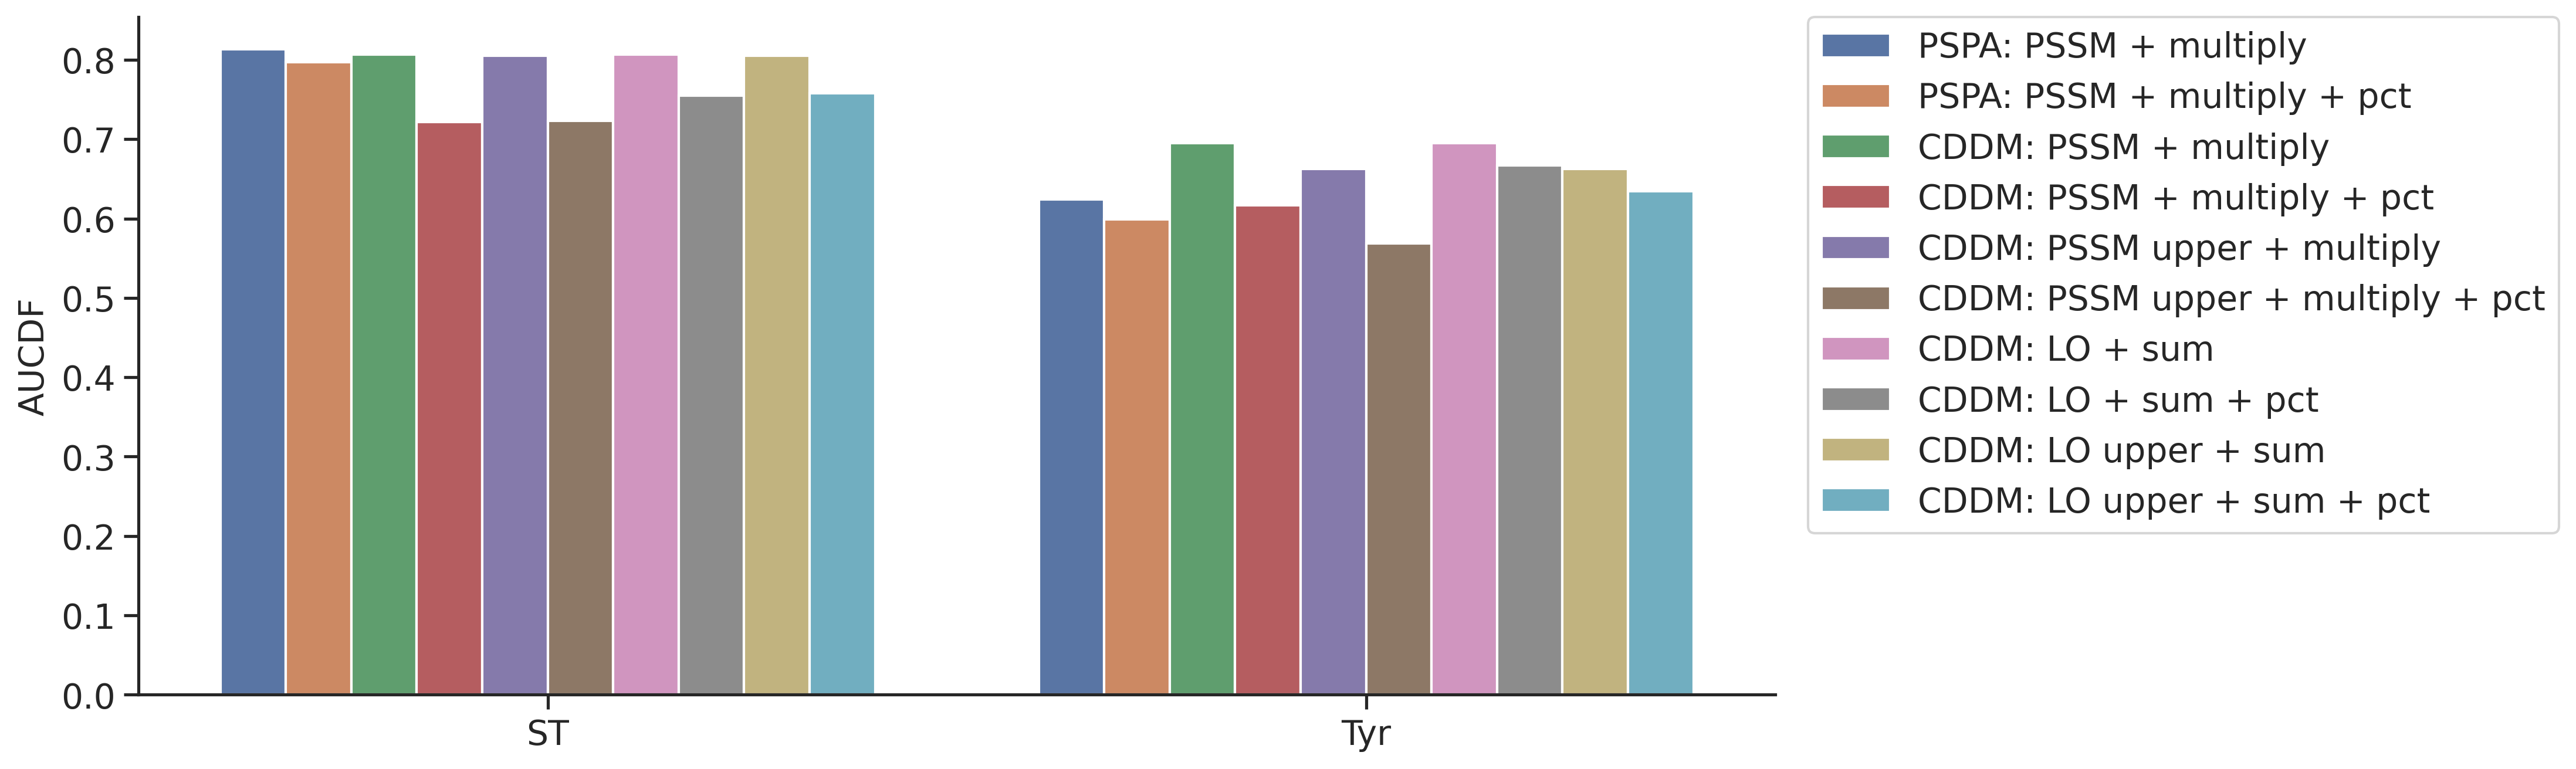

In [29]:
plot_group_bar(aucdf,value_cols=aucdf.columns[1:],group='group',rotation=0)
plt.ylabel('AUCDF')

In [36]:
topk_df = pd.concat(topk_dfs,axis=1)

In [37]:
topk_df.columns = ref_dict.keys()

In [38]:
idx_ordered = topk_df.mean(1).sort_values(ascending=False).index

In [39]:
topk_df = topk_df.loc[idx_ordered]

In [40]:
topk_df = topk_df.reset_index(names='group')

Text(0, 0.5, 'Top10 accuracy')

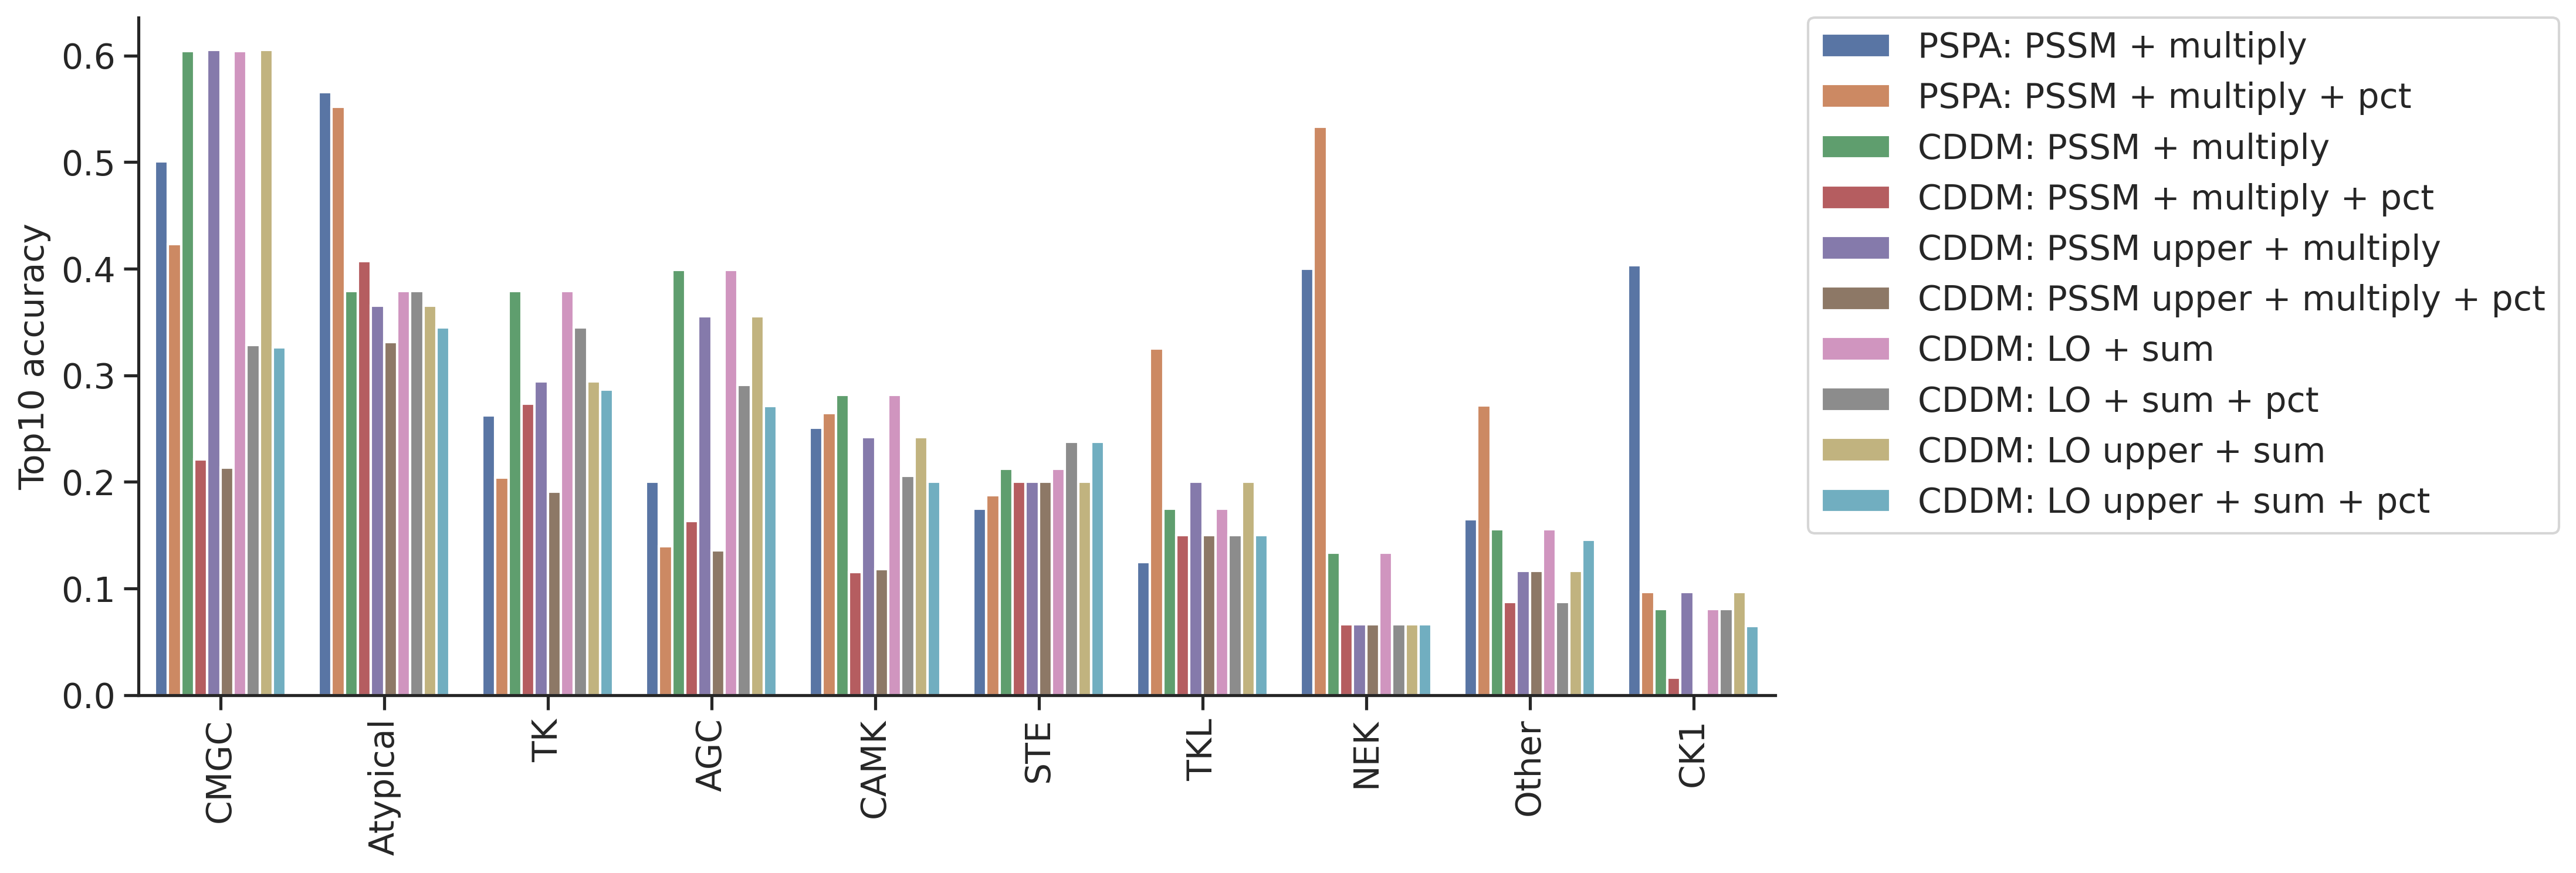

In [41]:
plot_group_bar(topk_df,value_cols=topk_df.columns[1:],group='group')
plt.ylabel('Top10 accuracy')

Text(0, 0.5, 'Top10 accuracy')

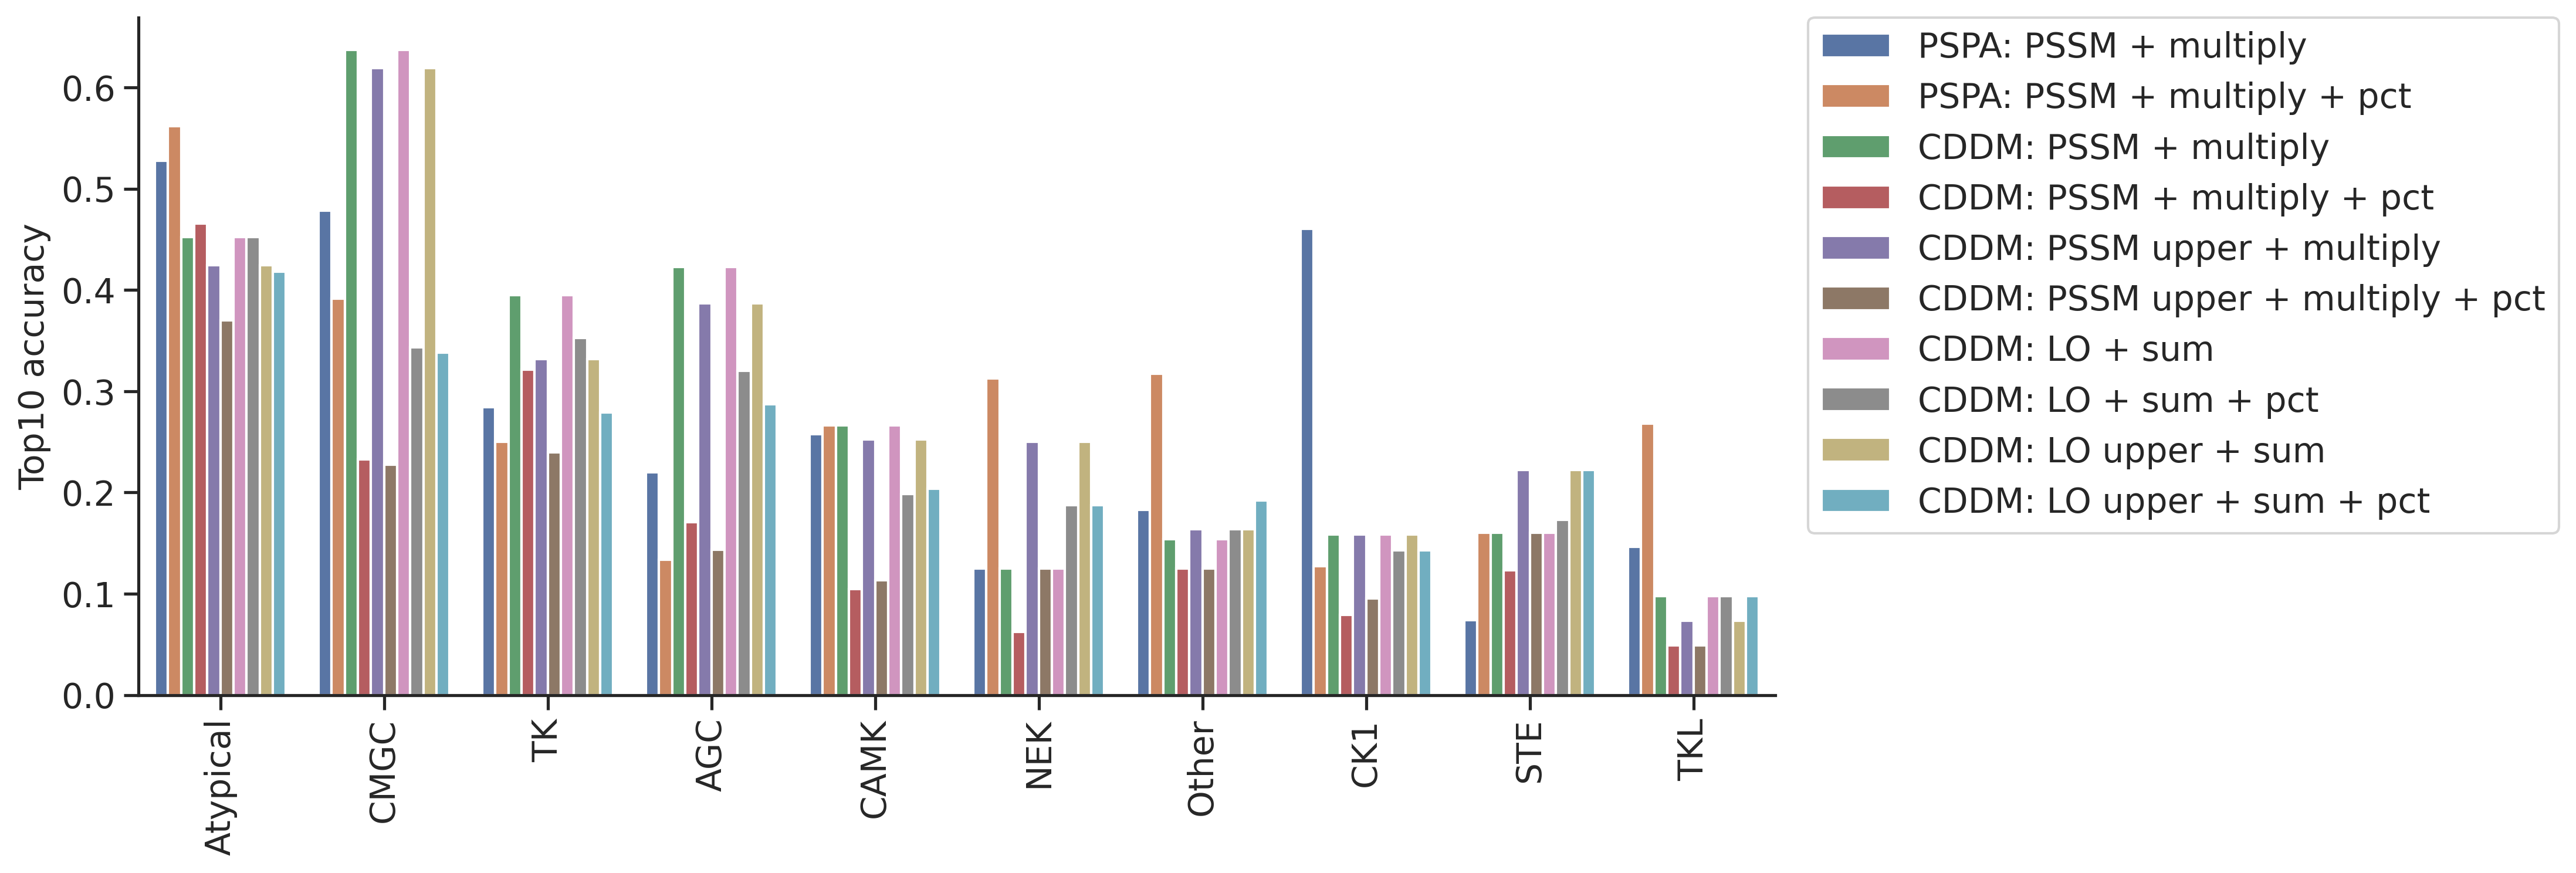

In [35]:
plot_group_bar(topk_df,value_cols=topk_df.columns[1:],group='group')
plt.ylabel('Top10 accuracy')

In [42]:
col = topk_df.columns[~topk_df.columns.str.contains('pct')][1:]

In [46]:
df.kinase_group.value_counts()

kinase_group
CMGC        777
AGC         510
TK          386
CAMK        357
Atypical    147
Other       104
STE          83
CK1          63
TKL          41
NEK          16
Name: count, dtype: int64

Text(0, 0.5, 'Top10 accuracy')

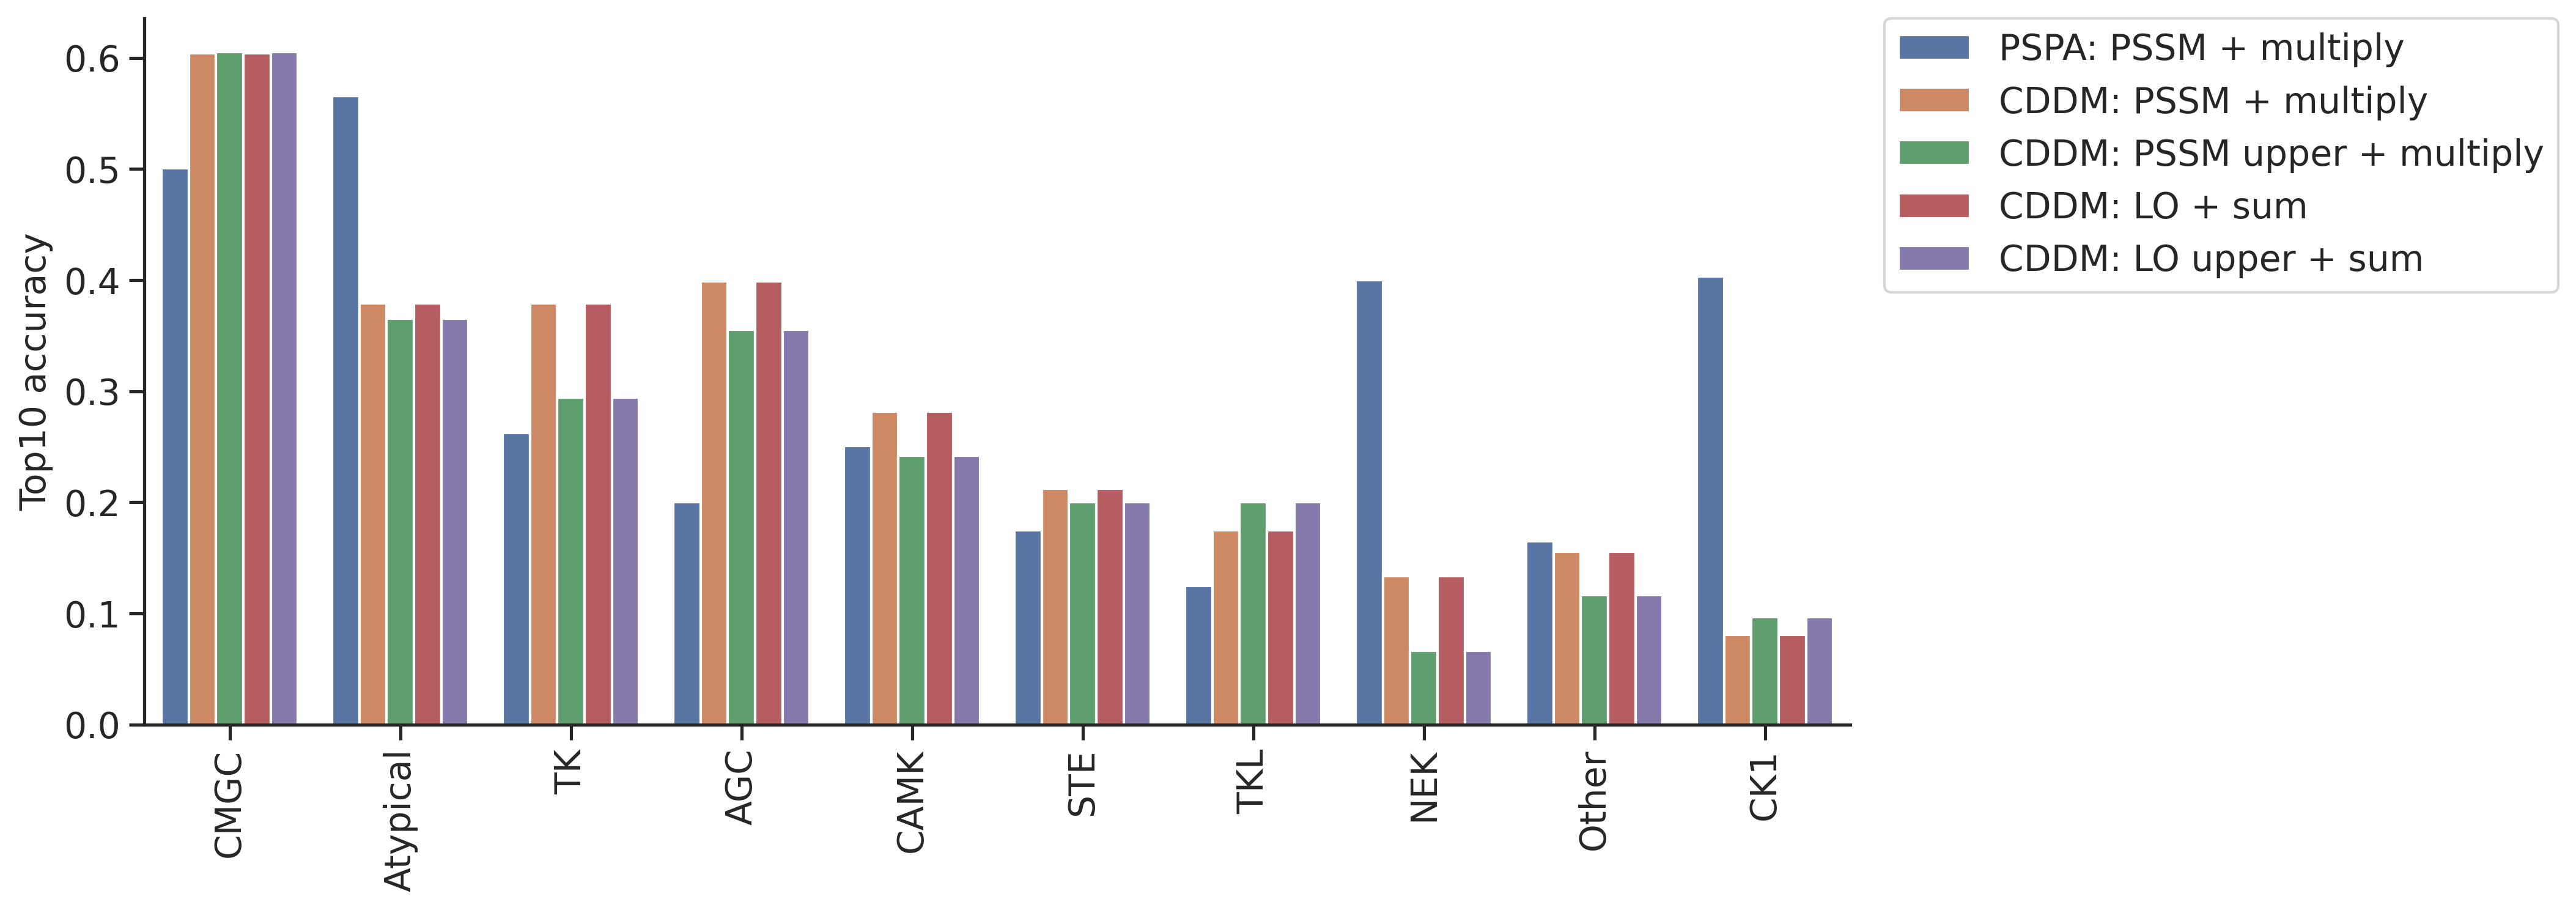

In [43]:
plot_group_bar(topk_df,value_cols=col,group='group')
plt.ylabel('Top10 accuracy')

Text(0, 0.5, 'Top10 accuracy')

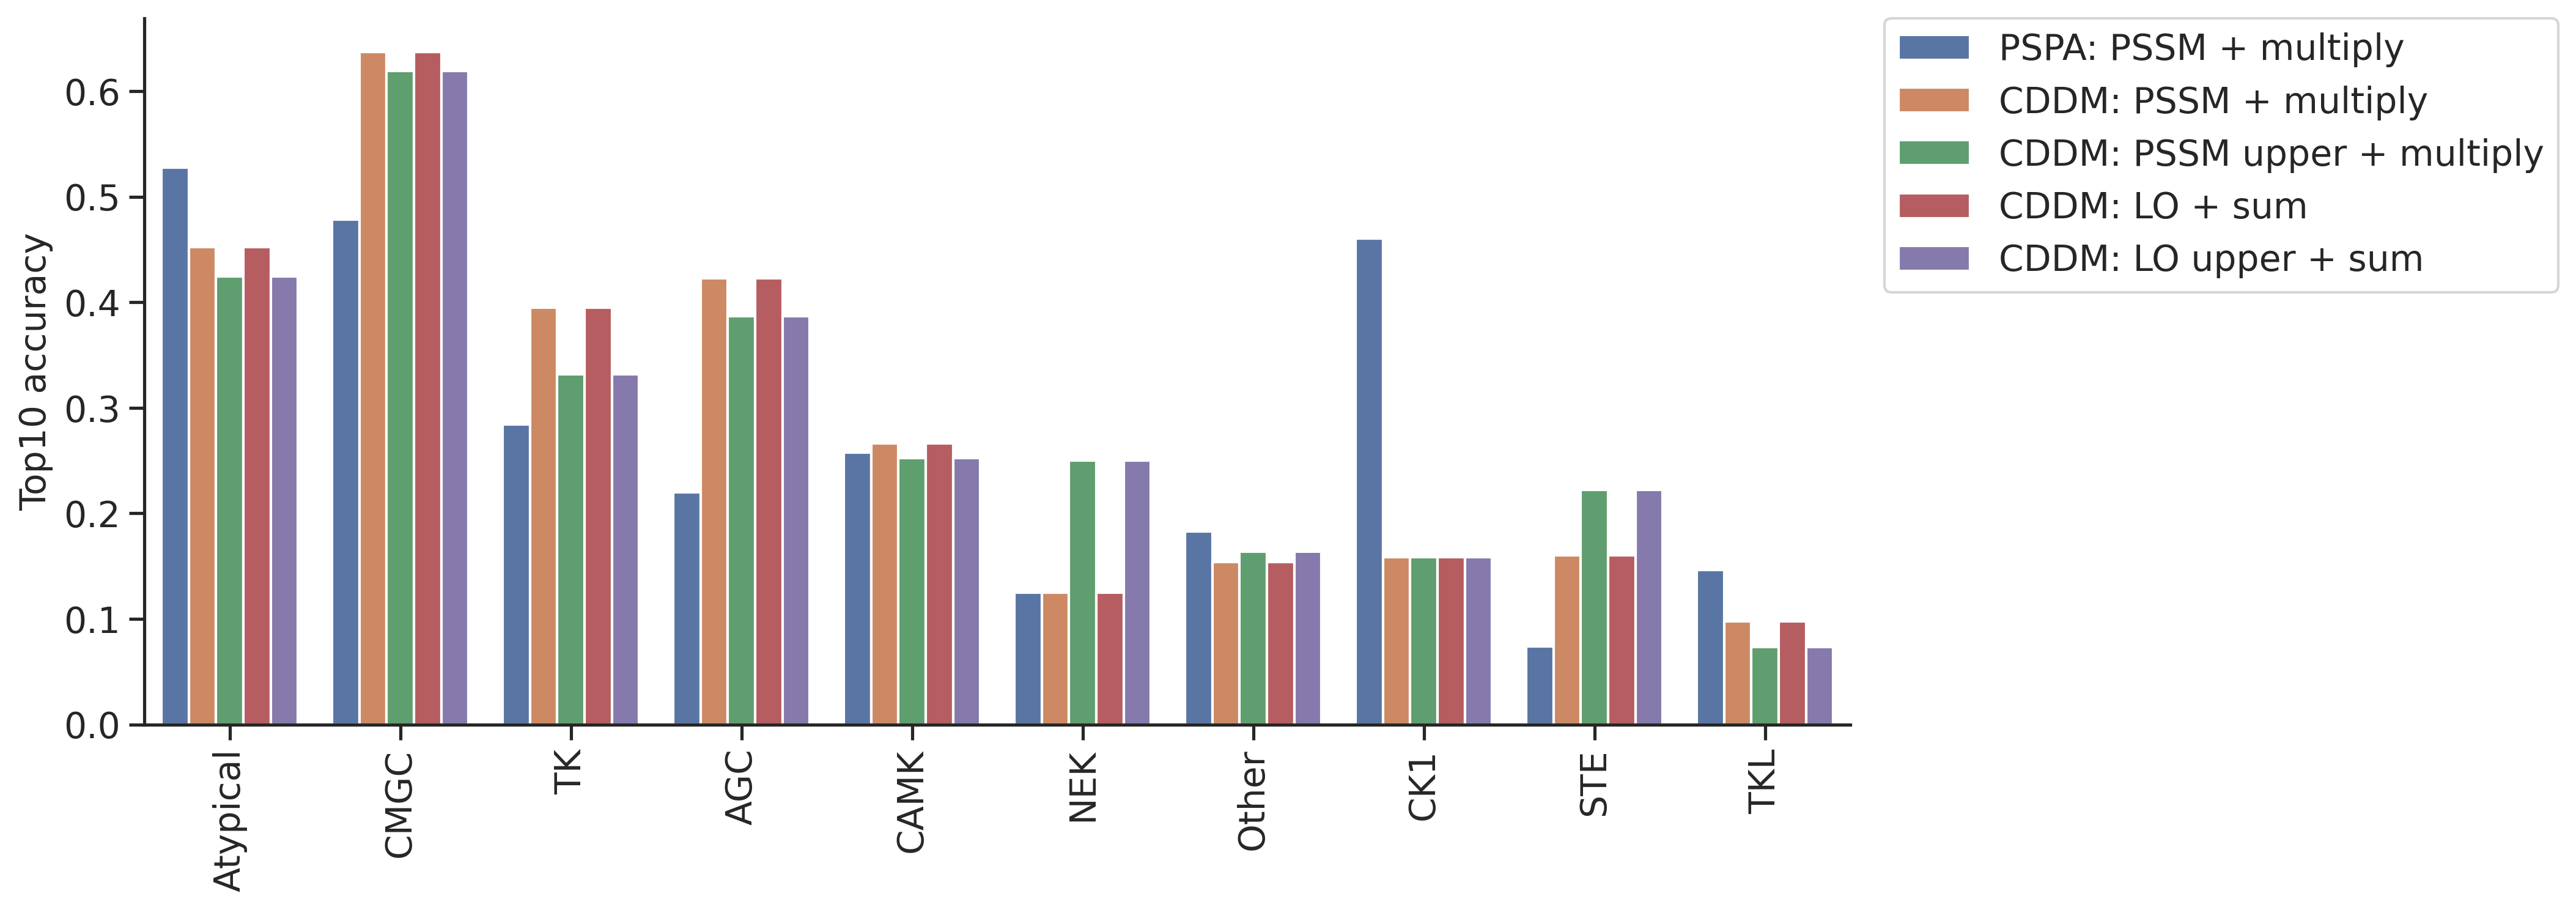

In [37]:
plot_group_bar(topk_df,value_cols=col,group='group')
plt.ylabel('Top10 accuracy')